# 🥁 All-in-One Drum Audio Classifier



**Complete end-to-end pipeline for drum sample classification**



This notebook consolidates all functionality from the MLAudioClassifier project into a single, self-contained workflow.



## 📋 Table of Contents



### Part 1: ML Development Features

1. [Environment Setup & Configuration](#1-environment-setup)

2. [MFCC Feature Extraction](#2-mfcc-feature-extraction)

3. [Model Training (Model 1)](#3-model-1-training)

4. [Model Training (Model 2 - Autoencoder)](#4-model-2-training)



### Part 2: Model Evaluation

5. [Load and Compare Models](#5-model-comparison)

6. [Performance Metrics & Visualizations](#6-performance-metrics)

7. [Confusion Matrices](#7-confusion-matrices)



### Part 3: Classification & Archive Generation

8. [Label Mapping Validation](#8-label-validation)

9. [Archive Classification (Production)](#9-production-classification)

10. [Archive Regeneration & Organization](#10-archive-organization)

11. [Statistics & Reporting](#11-statistics)



### Part 4: Notebook Appendices (Imported Workflows)

12. [MFCC Feature Extractor Notebook](#12-mfcc-feature-extractor-notebook)

13. [Model 1 Training Notebook](#13-model-1-training-notebook)

14. [Model 2 Training Notebook](#14-model-2-training-notebook)

15. [Model Evaluation Notebook](#15-model-evaluation-notebook)

16. [ArchiveClassifier Notebook](#16-archiveclassifier-notebook)

17. [Practical Demo Notebook](#17-practical-demo-notebook)

18. [Validate Mapping Notebook](#18-validate-mapping-notebook)

19. [Extract Training Labels Notebook](#19-extract-training-labels-notebook)

20. [Test Classifier Notebook](#20-test-classifier-notebook)



### Part 5: Utility Scripts (Converted)

21. [setup_directories.py](#21-setup-directories)

22. [strict_populate_training.py](#22-strict-populate-training)

23. [populate_test_data.py](#23-populate-test-data)

24. [extract_training_labels.py](#24-extract-training-labels-script)

25. [validate_mapping.py](#25-validate-mapping-script)

26. [test_classifier.py](#26-test-classifier-script)

27. [deep_folder_analysis.py](#27-deep-folder-analysis)

28. [inspect_catchment.py](#28-inspect-catchment)

29. [organize_drum_archive.py](#29-organize-drum-archive)

30. [update_notebook_paths.py](#30-update-notebook-paths)

31. [run_strict_examples.sh](#31-run-strict-examples)



### Part 6: Classifier Package Modules

32. [classifier/__init__.py](#32-classifier-init)

33. [classifier/features.py](#33-classifier-features)

34. [classifier/io.py](#34-classifier-io)

35. [classifier/infer.py](#35-classifier-infer)

36. [classifier/model.py](#36-classifier-model)

37. [classifier/cli.py](#37-classifier-cli)

38. [classifier/rebuild.py](#38-classifier-rebuild)

39. [classifier/README.md](#39-classifier-readme)



## 🎯 Quick Start Options



**Option A: Full Pipeline** - Run all cells in order (training → evaluation → classification)



**Option B: Classification Only** - If models already trained, jump to Part 3



**Option C: Training Only** - Run Parts 1-2 to create/update models



---

# Part 1: ML Development Features

## 1. Environment Setup & Configuration

In [269]:
# Core warnings and filesystem utilities
import warnings
import os
import json
import gc
import glob
import hashlib
import importlib
import importlib.util
import inspect
import argparse
import subprocess
import time
import tracemalloc
from datetime import datetime
from pathlib import Path
from collections import Counter, defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
from itertools import product
from math import log, pi, exp, ceil
from textwrap import dedent
from typing import Dict, List, Tuple, Optional, Any, Sequence, Callable
import statistics as st
import re
import types

# Scientific computing
import numpy as np
import pandas as pd

# Audio processing
import librosa
import librosa.display
import soundfile as sf

# Machine learning and deep learning
import keras
import tensorflow as tf
from keras import Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

# Classical ML utilities
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# Scientific helpers
import scipy.io as io
import scipy.stats as stats
import cv2

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress and diagnostics
from tqdm.auto import tqdm
import psutil

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

print("✅ All imports successful")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"Librosa version: {librosa.__version__}")

✅ All imports successful
TensorFlow version: 2.20.0
Keras version: 3.11.3
Librosa version: 0.11.0


In [340]:
# Model-aware preprocessing + demo classification wrapper
# This cell overwrites the older demo_classify_samples with a version that
# automatically adapts to the model input shape (MFCC vs image/spectrogram).
import numpy as np
import librosa
import shutil
from pathlib import Path
import math
import pandas as pd

# optional: prefer cv2 for resizing if available
try:
    import cv2
except Exception:
    cv2 = None
    try:
        from skimage.transform import resize as sk_resize
    except Exception:
        sk_resize = None


def _model_expected_shape(model):
    shape = getattr(model, 'input_shape', None)
    if shape is None:
        # fallback to layers
        shape = getattr(model.layers[0], 'input_shape', None)
    if shape is None:
        return None
    # remove batch dim
    if isinstance(shape, tuple) and len(shape) > 0:
        return tuple(shape[1:])
    return None


def _to_mel_image(wav_path, target_hw=(16,16), sr=44100, n_fft=1024, hop_length=256, n_mels=64):
    y, _ = librosa.load(str(wav_path), sr=sr, mono=True)
    if len(y) < 512:
        y = librosa.util.fix_length(y, 512)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_db = librosa.power_to_db(S, ref=np.max)
    # normalize 0..1
    Sn = (S_db - S_db.min()) / (S_db.max() - S_db.min() + 1e-9)
    H, W = target_hw
    if cv2 is not None:
        img = cv2.resize(Sn, (W, H), interpolation=cv2.INTER_AREA)
    elif sk_resize is not None:
        img = sk_resize(Sn, (H, W), mode='reflect', anti_aliasing=True)
    else:
        # naive resize by cropping/padding
        img = np.zeros((H, W), dtype=np.float32)
        h0 = min(H, Sn.shape[0])
        w0 = min(W, Sn.shape[1])
        img[:h0, :w0] = Sn[:h0, :w0]
    return img.astype(np.float32)


def _ensure_channels(img2d, channels):
    if channels == 1:
        return img2d[..., None]
    if img2d.ndim == 2:
        imgC = np.stack([img2d]*channels, axis=-1)
        return imgC
    # already has channels
    if img2d.shape[-1] >= channels:
        return img2d[..., :channels]
    # tile
    return np.tile(img2d, (1,1,math.ceil(channels / img2d.shape[-1])))[:,:,:channels]


def prepare_input_for_model(model, mfcc=None, wav_path=None, spec_params=None):
    """Return input array with batch dim matching model expected input."""
    expected = _model_expected_shape(model)
    if expected is None:
        raise RuntimeError('Unable to determine model input shape')

    spec_params = spec_params or {}

    # 2D expectation (n_mfcc, n_frames)
    if len(expected) == 2:
        # produce MFCC if not provided
        if mfcc is None:
            if wav_path is None:
                raise ValueError('mfcc or wav_path required for 2D inputs')
            mfcc = librosa.feature.mfcc(
                y=librosa.load(str(wav_path), sr=spec_params.get('sr', AUDIO_CONFIG.get('sr', 44100)))[0],
                sr=spec_params.get('sr', AUDIO_CONFIG.get('sr', 44100)),
                n_mfcc=spec_params.get('n_mfcc', AUDIO_CONFIG.get('n_mfcc', 40)),
                n_fft=spec_params.get('n_fft', AUDIO_CONFIG.get('n_fft', 2048)),
                hop_length=spec_params.get('hop_length', AUDIO_CONFIG.get('hop_length', 512))
            )
        mfcc = mfcc.astype(np.float32)
        # align frequency axis
        if mfcc.shape[0] != expected[0]:
            if mfcc.shape[1] == expected[0]:
                mfcc = mfcc.T
            else:
                out = np.zeros(expected, dtype=np.float32)
                min_f = min(expected[0], mfcc.shape[0])
                min_t = min(expected[1], mfcc.shape[1])
                out[:min_f, :min_t] = mfcc[:min_f, :min_t]
                mfcc = out
        return np.expand_dims(mfcc, axis=0)

    # 3D expectation (H,W,C)
    if len(expected) == 3:
        H, W, C = expected
        if wav_path is not None:
            img = _to_mel_image(wav_path, target_hw=(H, W), sr=spec_params.get('sr', SPEC_CONFIG.get('sr', 22050)), n_fft=spec_params.get('n_fft', SPEC_CONFIG.get('n_fft', 512)), hop_length=spec_params.get('hop_length', SPEC_CONFIG.get('hop_length', 256)), n_mels=spec_params.get('n_mels', SPEC_CONFIG.get('n_mels', 64)))
        elif mfcc is not None:
            # derive image by resizing mfcc
            if cv2 is not None:
                img = cv2.resize(mfcc, (W, H), interpolation=cv2.INTER_AREA)
            elif sk_resize is not None:
                img = sk_resize(mfcc, (H, W), mode='reflect', anti_aliasing=True)
            else:
                img = np.zeros((H, W), dtype=np.float32)
                h0 = min(H, mfcc.shape[0])
                w0 = min(W, mfcc.shape[1])
                img[:h0, :w0] = mfcc[:h0, :w0]
        else:
            raise ValueError('wav_path or mfcc required for image-model inputs')
        imgC = _ensure_channels(img, C)
        return np.expand_dims(imgC.astype(np.float32), axis=0)

    raise RuntimeError(f'Unhandled model input rank: {expected}')


# Overwrite demo_classify_samples to use prepare_input_for_model automatically

def demo_classify_samples(model, files, output_dir, copy_mode='copy', max_files=None, spec_params=None):
    """Classify a sequence of wav files using a model that may expect MFCCs or images.

    Arguments:
      model: Keras model instance
      files: iterable of Paths or str to wav files
      output_dir: Path where copies are written when copy_mode != 'none'
      copy_mode: 'copy'|'move'|'none'
      max_files: limit processed files (for demos)
      spec_params: optional dict to adjust spectrogram params
    Returns:
      pandas.DataFrame of results
    """
    rows = []
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    files = list(files)
    if max_files is not None:
        files = files[:max_files]

    for wav in tqdm(files, desc='demo'):
        wav = Path(wav)
        try:
            # compute MFCC once (used if model expects MFCC)
            y, sr = librosa.load(str(wav), sr=AUDIO_CONFIG.get('sr', 44100), mono=True)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=AUDIO_CONFIG.get('n_mfcc', 40), n_fft=AUDIO_CONFIG.get('n_fft', 2048), hop_length=AUDIO_CONFIG.get('hop_length', 512))

            X = prepare_input_for_model(model, mfcc=mfcc, wav_path=wav, spec_params=spec_params)
            probs = model.predict(X, verbose=0)
            # if predict returns a batch, take first
            if probs.ndim == 2:
                probs = probs[0]
            best_idx = int(np.argmax(probs))
            confidence = float(probs[best_idx])
            label = TARGET_LABELS[best_idx] if best_idx < len(TARGET_LABELS) else f'class_{best_idx}'

            dest = None
            if copy_mode in ('copy', 'move'):
                name = f"{label}_{confidence:.2f}_{wav.name}"
                dest = output_dir / label
                dest.mkdir(parents=True, exist_ok=True)
                dst_path = dest / name
                if copy_mode == 'copy':
                    shutil.copy2(wav, dst_path)
                else:
                    shutil.move(wav, dst_path)

            rows.append({'file': str(wav), 'label': label, 'confidence': confidence, 'dst': str(dst_path) if dest is not None else None})

        except Exception as e:
            rows.append({'file': str(wav), 'label': None, 'confidence': 0.0, 'dst': None, 'error': str(e)})

    return pd.DataFrame(rows)

print('✅ Injected model-aware demo_classify_samples')


✅ Injected model-aware demo_classify_samples


In [270]:
# Project configuration
PROJECT_ROOT = Path('/Users/Gilby/Projects/MLAudioClassifier')
os.chdir(PROJECT_ROOT)
filepath = str(PROJECT_ROOT)  # Legacy compatibility for imported workflows

# Directory structure
PATHS = {
    'training_data': PROJECT_ROOT / 'TrainingData' / 'AudioSamples',
    'test_data': PROJECT_ROOT / 'TestData',
    'data': PROJECT_ROOT / 'data',
    'models': PROJECT_ROOT / 'models',
    'results': PROJECT_ROOT / 'results',
    'logs': PROJECT_ROOT / 'logs' / 'train',
    'archive': PROJECT_ROOT / 'complete_drum_archive',
    'classified': PROJECT_ROOT / 'ClassifiedArchive',
}

# Create directories if they don't exist
for name, path in PATHS.items():
    path.mkdir(parents=True, exist_ok=True)
    print(f"✓ {name:20s}: {path}")

print(f"\n✅ Working directory: {os.getcwd()}")

✓ training_data       : /Users/Gilby/Projects/MLAudioClassifier/TrainingData/AudioSamples
✓ test_data           : /Users/Gilby/Projects/MLAudioClassifier/TestData
✓ data                : /Users/Gilby/Projects/MLAudioClassifier/data
✓ models              : /Users/Gilby/Projects/MLAudioClassifier/models
✓ results             : /Users/Gilby/Projects/MLAudioClassifier/results
✓ logs                : /Users/Gilby/Projects/MLAudioClassifier/logs/train
✓ archive             : /Users/Gilby/Projects/MLAudioClassifier/complete_drum_archive
✓ classified          : /Users/Gilby/Projects/MLAudioClassifier/ClassifiedArchive

✅ Working directory: /Users/Gilby/Projects/MLAudioClassifier


In [271]:
# Project module imports (available throughout the notebook)
from classifier import cli as classifier_cli
from classifier import features as classifier_features
from classifier import infer as classifier_infer
from classifier import io as classifier_io
from classifier import model as classifier_model
from classifier import rebuild as classifier_rebuild
from classifier.model import (
    load_label_mapping as classifier_load_label_mapping,
    load_model as classifier_load_model,
    save_label_mapping_stub,
    validate_label_mapping,
)

print("✅ Classifier package modules loaded")

✅ Classifier package modules loaded


In [272]:
# Audio processing parameters (consistent across all operations)
AUDIO_CONFIG = {
    'sr': 44100,              # Sample rate
    'target_samples': 50000,  # Fixed audio length
    'n_mfcc': 40,            # Number of MFCC coefficients
    'n_fft': 2048,           # FFT window size
    'hop_length': 512,       # Hop length for MFCC
    'normalize': True,       # Normalize MFCC features
}

# Model training parameters
TRAINING_CONFIG = {
    'batch_size': 32,
    'epochs': 50,
    'learning_rate': 0.0005,
    'validation_split': 0.2,
    'early_stopping_patience': 5,
    'reduce_lr_patience': 3,
}

# Classification parameters
CLASSIFICATION_CONFIG = {
    'batch_size': 32,
    'confidence_threshold': 0.50,  # For misc routing
    'top_k': 3,                   # Store top K predictions
    'dedup_hash': True,           # Enable hash-based deduplication
    'hash_algorithm': 'md5',      # md5 or sha256
}

# Target labels (6 core drums + misc)
TARGET_LABELS = ['Crash', 'Hihat', 'Kick', 'Ride', 'Snare', 'Tom']

print("✅ Configuration loaded")
print(f"\nAudio: {AUDIO_CONFIG['sr']}Hz, {AUDIO_CONFIG['n_mfcc']} MFCCs")
print(f"Training: {TRAINING_CONFIG['epochs']} epochs, batch {TRAINING_CONFIG['batch_size']}")
print(f"Target labels: {', '.join(TARGET_LABELS)}")

✅ Configuration loaded

Audio: 44100Hz, 40 MFCCs
Training: 50 epochs, batch 32
Target labels: Crash, Hihat, Kick, Ride, Snare, Tom


## 2. MFCC Feature Extraction

Extract MFCC features from training and test datasets.

In [273]:
def safe_load_audio(path: Path, sr: int = 44100) -> Tuple[Optional[np.ndarray], Optional[int]]:
    """Load audio with fallback from soundfile to librosa."""
    try:
        # Try soundfile first (faster, cleaner)
        y, orig_sr = sf.read(str(path), dtype='float32')
        if len(y.shape) > 1:  # Convert stereo to mono
            y = y.mean(axis=1)
        if orig_sr != sr:
            y = librosa.resample(y, orig_sr=orig_sr, target_sr=sr)
        return y, sr
    except Exception as e:
        # Fallback to librosa (handles more formats)
        try:
            y, sr_out = librosa.load(str(path), sr=sr, mono=True)
            return y, sr_out
        except Exception as e2:
            return None, None

def extract_mfcc(audio_path: Path, config: Dict) -> Tuple[Optional[np.ndarray], Dict[str, Any]]:
    """Extract MFCC features from audio file."""
    metadata = {'error': None, 'duration': 0}
    
    try:
        # Load audio
        y, sr = safe_load_audio(audio_path, config['sr'])
        if y is None:
            metadata['error'] = 'Failed to load audio'
            return None, metadata
        
        # Fix length
        if len(y) < config['target_samples']:
            y = librosa.util.fix_length(y, size=config['target_samples'])
        else:
            y = y[:config['target_samples']]
        
        metadata['duration'] = len(y) / sr
        
        # Extract MFCC
        mfcc = librosa.feature.mfcc(
            y=y,
            sr=sr,
            n_mfcc=config['n_mfcc'],
            n_fft=config['n_fft'],
            hop_length=config['hop_length']
        )
        
        # Normalize if requested
        if config.get('normalize', True):
            mfcc = librosa.util.normalize(mfcc)
        
        return mfcc, metadata
        
    except Exception as e:
        metadata['error'] = str(e)
        return None, metadata

print("✅ MFCC extraction functions defined")

✅ MFCC extraction functions defined


In [274]:
def extract_dataset_mfcc(data_dir: Path, dataset_name: str, config: Dict) -> Dict:
    """Extract MFCC features from all files in dataset directory."""
    print(f"\n{'='*80}")
    print(f"Extracting MFCC features for {dataset_name}")
    print(f"{'='*80}")
    print(f"Source: {data_dir}")
    
    mfcc_data = []
    labels = []
    label_names = []
    errors = []
    
    # Get all category directories
    categories = sorted([d for d in data_dir.iterdir() if d.is_dir()])
    print(f"Found {len(categories)} categories\n")
    
    # Create label mapping
    label_map = {cat.name: idx for idx, cat in enumerate(categories)}
    
    for category in categories:
        audio_files = list(category.glob('*.wav'))
        print(f"Processing {category.name:20s}: {len(audio_files):4d} files", end=' ')
        
        category_label = label_map[category.name]
        success_count = 0
        
        for audio_file in tqdm(audio_files, desc=category.name, leave=False):
            mfcc, metadata = extract_mfcc(audio_file, config)
            
            if mfcc is not None:
                mfcc_data.append(mfcc.tolist())
                labels.append(category_label)
                label_names.append(category.name)
                success_count += 1
            else:
                errors.append({
                    'file': str(audio_file),
                    'category': category.name,
                    'error': metadata['error']
                })
        
        print(f"✓ {success_count} successful")
    
    result = {
        'mfcc': mfcc_data,
        'label': labels,
        'label_names': label_names,
        'label_map': label_map,
        'errors': errors,
        'config': config
    }
    
    print(f"\n✅ Extraction complete:")
    print(f"   Total samples: {len(mfcc_data)}")
    print(f"   Categories: {len(label_map)}")
    print(f"   Errors: {len(errors)}")
    
    return result

print("✅ Dataset extraction function defined")

✅ Dataset extraction function defined


In [275]:
# Extract training data
train_output = PATHS['data'] / 'mfcc_train_data.json'

if train_output.exists():
    print(f"⚠️  Training data already exists: {train_output}")
    response = input("Re-extract? (y/n): ").strip().lower()
    if response != 'y':
        print("Skipping training data extraction")
    else:
        train_data = extract_dataset_mfcc(PATHS['training_data'], 'Training', AUDIO_CONFIG)
        with open(train_output, 'w') as f:
            json.dump(train_data, f, indent=2)
        print(f"\n✅ Saved to: {train_output}")
else:
    train_data = extract_dataset_mfcc(PATHS['training_data'], 'Training', AUDIO_CONFIG)
    with open(train_output, 'w') as f:
        json.dump(train_data, f, indent=2)
    print(f"\n✅ Saved to: {train_output}")

⚠️  Training data already exists: /Users/Gilby/Projects/MLAudioClassifier/data/mfcc_train_data.json

Extracting MFCC features for Training
Source: /Users/Gilby/Projects/MLAudioClassifier/TrainingData/AudioSamples
Found 36 categories

Processing Agogo               :   52 files 

✓ 52 successful
Processing Bass                :  107 files 

✓ 107 successful
Processing Bell                :  220 files 

✓ 220 successful
Processing Bongo               :  151 files 

✓ 151 successful
Processing Cabasa              :   44 files 

✓ 44 successful
Processing China               :   33 files 

✓ 33 successful
Processing Clap                :  310 files 

✓ 310 successful
Processing Clave               :   43 files 

✓ 43 successful
Processing Conga               :  335 files 

✓ 335 successful
Processing Cowbell             :   39 files 

✓ 39 successful
Processing Crash               :  187 files 

✓ 187 successful
Processing Cuica               :   40 files 

✓ 40 successful
Processing FX                  : 1595 files 

✓ 1595 successful
Processing Guiro               :   49 files 

✓ 49 successful
Processing Hihat               :  969 files 

✓ 969 successful
Processing Kick                : 1360 files 

✓ 1360 successful
Processing Maracas             :   46 files 

✓ 46 successful
Processing Metal               :   23 files 

✓ 23 successful
Processing Noise               :   90 files 

✓ 90 successful
Processing Perc                :  483 files 

✓ 483 successful
Processing Reverse             :   76 files 

✓ 76 successful
Processing Ride                :  312 files 

✓ 312 successful
Processing Rim                 :  192 files 

✓ 192 successful
Processing Shaker              :   54 files 

✓ 54 successful
Processing Sizzle              :    3 files 

✓ 3 successful
Processing Snare               : 2264 files 

✓ 2264 successful
Processing Splash              :   23 files 

✓ 23 successful
Processing Tambourine          :   56 files 

✓ 56 successful
Processing Timbale             :   86 files 

✓ 86 successful
Processing Timpani             :   23 files 

✓ 23 successful
Processing Tom                 : 1828 files 

✓ 1828 successful
Processing Triangle            :   53 files 

✓ 53 successful
Processing Vibraslap           :   12 files 

✓ 12 successful
Processing Vox                 :  101 files 

✓ 101 successful
Processing Whistle             :   40 files 

✓ 40 successful
Processing Woodblock           :   38 files 

✓ 38 successful

✅ Extraction complete:
   Total samples: 11337
   Categories: 36
   Errors: 0

✅ Saved to: /Users/Gilby/Projects/MLAudioClassifier/data/mfcc_train_data.json


In [276]:
# Extract test data
test_output = PATHS['data'] / 'mfcc_test_data.json'

if test_output.exists():
    print(f"⚠️  Test data already exists: {test_output}")
    response = input("Re-extract? (y/n): ").strip().lower()
    if response != 'y':
        print("Skipping test data extraction")
    else:
        test_data = extract_dataset_mfcc(PATHS['test_data'], 'Test', AUDIO_CONFIG)
        with open(test_output, 'w') as f:
            json.dump(test_data, f, indent=2)
        print(f"\n✅ Saved to: {test_output}")
else:
    if PATHS['test_data'].exists() and any(PATHS['test_data'].iterdir()):
        test_data = extract_dataset_mfcc(PATHS['test_data'], 'Test', AUDIO_CONFIG)
        with open(test_output, 'w') as f:
            json.dump(test_data, f, indent=2)
        print(f"\n✅ Saved to: {test_output}")
    else:
        print(f"⚠️  Test data directory is empty: {PATHS['test_data']}")
        print("   Run populate_test_data.py script first if needed")

⚠️  Test data already exists: /Users/Gilby/Projects/MLAudioClassifier/data/mfcc_test_data.json

Extracting MFCC features for Test
Source: /Users/Gilby/Projects/MLAudioClassifier/TestData
Found 31 categories

Processing .ipynb_checkpoints  :    0 files 

✓ 0 successful
Processing Agogo               :    9 files 

✓ 9 successful
Processing Bass                :   13 files 

✓ 13 successful
Processing Bell                :   15 files 

✓ 15 successful
Processing Bongo               :   24 files 

✓ 24 successful
Processing Cabasa              :    8 files 

✓ 8 successful
Processing China               :    6 files 

✓ 6 successful
Processing Clap                :   57 files 

✓ 57 successful
Processing Clave               :    8 files 

✓ 8 successful
Processing Conga               :   52 files 

✓ 52 successful
Processing Cowbell             :    7 files 

✓ 7 successful
Processing Crash               :   35 files 

✓ 35 successful
Processing Cuica               :    7 files 

✓ 7 successful
Processing Guiro               :    8 files 

✓ 8 successful
Processing Hihat               :   37 files 

✓ 37 successful
Processing Kick                :  100 files 

✓ 100 successful
Processing Maracas             :    9 files 

✓ 9 successful
Processing Metal               :    4 files 

✓ 4 successful
Processing Perc                :   96 files 

✓ 96 successful
Processing Ride                :   30 files 

✓ 30 successful
Processing Rim                 :   31 files 

✓ 31 successful
Processing Shaker              :   10 files 

✓ 10 successful
Processing Snare               :  100 files 

✓ 100 successful
Processing Splash              :    4 files 

✓ 4 successful
Processing Tambourine          :   11 files 

✓ 11 successful
Processing Timbale             :   16 files 

✓ 16 successful
Processing Timpani             :    4 files 

✓ 4 successful
Processing Tom                 :  100 files 

✓ 100 successful
Processing Triangle            :    9 files 

✓ 9 successful
Processing Whistle             :    7 files 

✓ 7 successful
Processing Woodblock           :    6 files 

✓ 6 successful

✅ Extraction complete:
   Total samples: 823
   Categories: 31
   Errors: 0

✅ Saved to: /Users/Gilby/Projects/MLAudioClassifier/data/mfcc_test_data.json


## 3. Model 1 Training (Direct MFCC CNN)

Train a CNN classifier directly on MFCC features.

In [277]:
# Load training data
train_data_path = PATHS['data'] / 'mfcc_train_data.json'

if not train_data_path.exists():
    print(f"❌ Training data not found: {train_data_path}")
    print("   Run the MFCC extraction cells above first")
else:
    print(f"Loading training data from: {train_data_path}")
    with open(train_data_path, 'r') as f:
        train_data = json.load(f)
    
    X = np.array(train_data['mfcc'])
    y = np.array(train_data['label'])
    
    print(f"✅ Loaded feature matrix: {X.shape}")
    print(f"   Samples: {X.shape[0]}")
    print(f"   MFCC coefficients: {X.shape[1]}")
    print(f"   Time frames: {X.shape[2]}")
    print(f"   Label vector length: {len(y)}")

Loading training data from: /Users/Gilby/Projects/MLAudioClassifier/data/mfcc_train_data.json
✅ Loaded feature matrix: (11337, 40, 98)
   Samples: 11337
   MFCC coefficients: 40
   Time frames: 98
   Label vector length: 11337


In [278]:
# Normalize labels to be contiguous 0..N-1
unique_labels = np.unique(y)
print(f"Raw label values ({len(unique_labels)} classes): {unique_labels}")
print(f"Max label value: {y.max()}")

needs_remap = (y.max() != len(unique_labels)-1) or not np.array_equal(unique_labels, np.arange(len(unique_labels)))

if needs_remap:
    print("⚠️  Non-contiguous label indices detected. Remapping to 0..N-1")
    label_mapping = {old: i for i, old in enumerate(sorted(unique_labels))}
    y = np.array([label_mapping[v] for v in y])
    unique_labels = np.unique(y)
    print(f"✅ Remap complete. New labels: {unique_labels}")
else:
    print("✅ Labels already contiguous 0..N-1")

num_classes = len(unique_labels)
print(f"\nNumber of classes: {num_classes}")

Raw label values (36 classes): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
Max label value: 35
✅ Labels already contiguous 0..N-1

Number of classes: 36


In [279]:
# Split into train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=TRAINING_CONFIG['validation_split'],
    stratify=y,
    random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Feature shape: ({X.shape[1]}, {X.shape[2]})")

Training set: 9069 samples
Validation set: 2268 samples
Feature shape: (40, 98)


In [280]:
# Build Model 1 architecture
model1 = keras.Sequential([
    # Input layer - flatten MFCC features
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),
    
    # 1st dense layer
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.3),
    
    # 2nd dense layer
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.3),
    
    # 3rd dense layer
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    
    # Output layer
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile model
optimizer = keras.optimizers.Adam(learning_rate=TRAINING_CONFIG['learning_rate'])
model1.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model 1 built and compiled")
print(f"   Learning rate: {TRAINING_CONFIG['learning_rate']}")
print(f"   Output classes: {num_classes}")
print("\nModel architecture:")
model1.summary()

✅ Model 1 built and compiled
   Learning rate: 0.0005
   Output classes: 36

Model architecture:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_10 (Flatten)            │ (None, 3920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 512)            │     2,007,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,176,420 (8.30 MB)

 Trainable params: 2,176,420 (8.30 MB)

 Non-trainable params: 0 (0.00 B)

In [281]:
# Train Model 1
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=TRAINING_CONFIG['early_stopping_patience'],
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=TRAINING_CONFIG['reduce_lr_patience'],
        verbose=1
    )
]

print(f"\n{'='*80}")
print("Training Model 1")
print(f"{'='*80}\n")

history1 = model1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=TRAINING_CONFIG['batch_size'],
    epochs=TRAINING_CONFIG['epochs'],
    callbacks=callbacks,
    verbose=1
)

print(f"\n✅ Training complete")


Training Model 1

Epoch 1/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.4430 - loss: 2.0932 - val_accuracy: 0.5578 - val_loss: 1.6181 - learning_rate: 5.0000e-04
Epoch 2/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5581 - loss: 1.6476 - val_accuracy: 0.5952 - val_loss: 1.4601 - learning_rate: 5.0000e-04
Epoch 3/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5915 - loss: 1.4847 - val_accuracy: 0.6173 - val_loss: 1.3841 - learning_rate: 5.0000e-04
Epoch 4/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6162 - loss: 1.3892 - val_accuracy: 0.6252 - val_loss: 1.3287 - learning_rate: 5.0000e-04
Epoch 5/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6298 - loss: 1.3007 - val_accuracy: 0.6358 - val_loss: 1.2889 - learning_rate: 5.0000e-04
Epoch 6/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6432 - loss: 1.2287 - val_accuracy: 0.6464 - val_loss: 1.2729 - learning_rate: 5.0000e-04
Epoch 7/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6

In [282]:
# Save Model 1
model1_path = PATHS['models'] / 'model1.keras'
history1_path = PATHS['models'] / 'model1_history.json'

model1.save(model1_path)
print(f"✅ Model saved to: {model1_path}")

# Save training history
history_dict = {k: [float(v) for v in vals] for k, vals in history1.history.items()}
with open(history1_path, 'w') as f:
    json.dump(history_dict, f, indent=2)
print(f"✅ History saved to: {history1_path}")

✅ Model saved to: /Users/Gilby/Projects/MLAudioClassifier/models/model1.keras
✅ History saved to: /Users/Gilby/Projects/MLAudioClassifier/models/model1_history.json
✅ History saved to: /Users/Gilby/Projects/MLAudioClassifier/models/model1_history.json


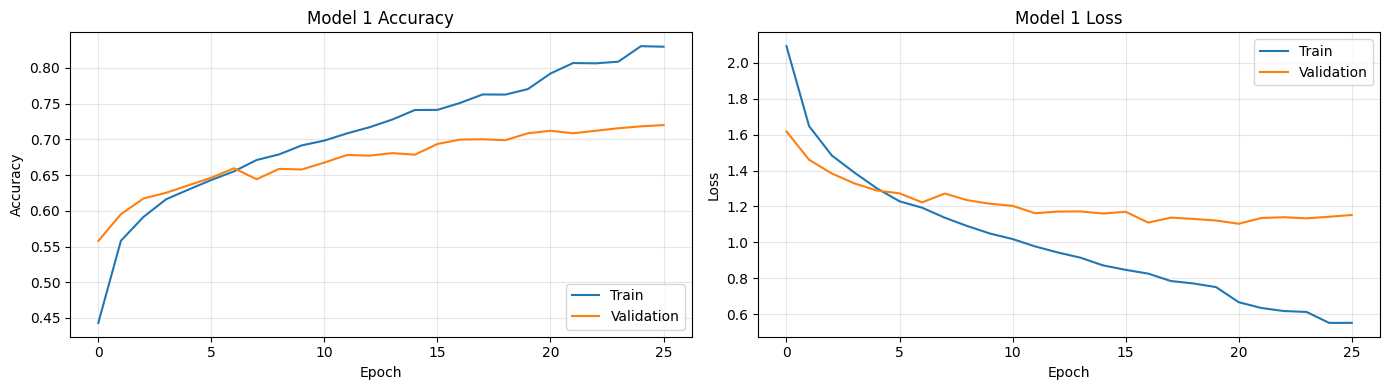

✅ Training plots saved to: /Users/Gilby/Projects/MLAudioClassifier/results

Final metrics:
   Train accuracy: 0.8297
   Val accuracy: 0.7200
   Train loss: 0.5513
   Val loss: 1.1523


In [283]:
# Visualize Model 1 training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Accuracy plot
ax1.plot(history1.history['accuracy'], label='Train')
ax1.plot(history1.history['val_accuracy'], label='Validation')
ax1.set_title('Model 1 Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(history1.history['loss'], label='Train')
ax2.plot(history1.history['val_loss'], label='Validation')
ax2.set_title('Model 1 Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PATHS['results'] / 'model1_training.png', dpi=120, bbox_inches='tight')
plt.show()

print(f"✅ Training plots saved to: {PATHS['results']}")
print(f"\nFinal metrics:")
print(f"   Train accuracy: {history1.history['accuracy'][-1]:.4f}")
print(f"   Val accuracy: {history1.history['val_accuracy'][-1]:.4f}")
print(f"   Train loss: {history1.history['loss'][-1]:.4f}")
print(f"   Val loss: {history1.history['val_loss'][-1]:.4f}")

## 4. Model 2 Training (Autoencoder-based)

Train an autoencoder for feature extraction, then a classifier on encoded features.

<h1> Training Notebook for Model 2 </h1>

In [284]:
# Loading libraries - cleaned up and optimized order
import os
import numpy as np
import glob
import json

# Data processing and visualization
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Audio processing
import librosa
import librosa.display

# Deep learning
import keras
from keras import layers
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

print("✅ All libraries imported successfully!")
print(f"Keras version: {keras.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Librosa version: {librosa.__version__}")

✅ All libraries imported successfully!
Keras version: 3.11.3
NumPy version: 2.2.6
Librosa version: 0.11.0


In [285]:
# please set this variable to where you cloned the git repo "MLAudioClassifier"

filepath = "/Users/Gilby/Projects/MLAudioClassifier"
os.chdir(filepath)

# make sure you have extracted the Training Data before you proceed with the rest of the notebook
# with something like "unzip TrainingData.zip"

<h1> Load in the training data and calculate the spectrogram for each file </h1>

In [286]:
# Check actual spectrogram dimensions before preprocessing
print("Checking spectrogram dimensions...")
sample_file = glob.glob("TrainingData/AudioSamples/*/*.wav")[0]
waveform, samplerate = librosa.load(sample_file, sr=22050, mono=True)
waveform = librosa.util.fix_length(waveform, size=32600)
spec = librosa.feature.melspectrogram(y=waveform, sr=samplerate, n_fft=1028, hop_length=256)
normalized_spec = librosa.util.normalize(spec)
print(f"Original spectrogram shape: {normalized_spec.shape}")

# If your spectrograms are not 128x128, we need to resize them
import cv2

ALLOWED_INSTRUMENTS = ["Agogo", "Bass", "Bell", "Bongo", "Cabasa", "China", "Clap", "Clave", "Conga", "Cowbell", "Cuica", "Crash", "Cuica", "Guiro", "Hihat", "Kick", "Maracas", "Metal", "Ride", "Rim", "Shaker", "Snare", "Splash", "Tambourine", "Timbale", "Timpani", "Tom", "Woodblock", "Whistle"]  # target 6 classes
print("Target instrument classes:", ALLOWED_INSTRUMENTS)

# Build mapping only for allowed instruments present in dataset
os.chdir("TrainingData/AudioSamples")
available_folders_all = sorted([f for f in glob.glob("*") if os.path.isdir(f)])
print(f"Found {len(available_folders_all)} total folders: {available_folders_all}")

# Filter to allowed instruments actually present
folder_names = [f for f in available_folders_all if f in ALLOWED_INSTRUMENTS]
missing = [f for f in ALLOWED_INSTRUMENTS if f not in folder_names]
if missing:
    print("⚠️ Missing expected instrument folders:", missing)
print(f"Using {len(folder_names)} instrument folders for training: {folder_names}")

if len(folder_names) == 0:
    raise RuntimeError("No allowed instrument folders found. Please ensure training data is organized under 'TrainingData/AudioSamples/<InstrumentName>'.")

# Create deterministic class index mapping
class_index = {inst: idx for idx, inst in enumerate(sorted(folder_names))}
print("Class index mapping:", class_index)

x_train = []
t_train = []

def resize_spectrogram(spec, target_size=(256, 256)):
    """Resize spectrogram to target dimensions"""
    spec_norm = ((spec - spec.min()) / (spec.max() - spec.min() + 1e-9) * 255).astype(np.uint8)
    resized = cv2.resize(spec_norm, target_size)
    return resized.astype(np.float32) / 255.0

file_count = 0
for instrument in folder_names:
    os.chdir(instrument)
    file_names = glob.glob("*.wav")
    if not file_names:
        print(f"⚠️  No wav files in {instrument}")
    for wav in file_names:
        try:
            waveform, samplerate = librosa.load(wav, sr=22050, mono=True)
            waveform = librosa.util.fix_length(waveform, size=32600)
            spec = librosa.feature.melspectrogram(y=waveform, sr=samplerate, n_fft=512, hop_length=256)
            normalized_spec = librosa.util.normalize(spec)
            if normalized_spec.shape != (128, 128):
                normalized_spec = resize_spectrogram(normalized_spec, target_size=(128, 128))
            x_train.append(normalized_spec)
            t_train.append(class_index[instrument])
            file_count += 1
            if file_count % 200 == 0:
                print(f"Processed {file_count} files...")
        except Exception as e:
            print(f"Error processing {instrument}/{wav}: {e}")
    os.chdir("..")

x_train = np.array(x_train, dtype=np.float32)
# Add channel dimension
x_train = x_train[..., np.newaxis]

os.chdir(filepath)

print(f"Final x_train shape: {x_train.shape}")
print(f"Total samples: {len(t_train)}")
print(f"Label distribution: {np.bincount(t_train)}")

# Consistency checks
def check_data_consistency():
    print("=== Data Consistency Check ===")
    print(f"x_train shape: {x_train.shape}")
    print(f"t_train length: {len(t_train)}")
    unique_classes = sorted(set(t_train))
    print(f"Unique class indices: {unique_classes}")
    print(f"Class counts: {np.bincount(t_train)}")
    return len(unique_classes)

num_classes = check_data_consistency()
print(f"✅ Using {num_classes} classes.")

Checking spectrogram dimensions...
Original spectrogram shape: (128, 128)
Target instrument classes: ['Agogo', 'Bass', 'Bell', 'Bongo', 'Cabasa', 'China', 'Clap', 'Clave', 'Conga', 'Cowbell', 'Cuica', 'Crash', 'Cuica', 'Guiro', 'Hihat', 'Kick', 'Maracas', 'Metal', 'Ride', 'Rim', 'Shaker', 'Snare', 'Splash', 'Tambourine', 'Timbale', 'Timpani', 'Tom', 'Woodblock', 'Whistle']
Found 36 total folders: ['Agogo', 'Bass', 'Bell', 'Bongo', 'Cabasa', 'China', 'Clap', 'Clave', 'Conga', 'Cowbell', 'Crash', 'Cuica', 'FX', 'Guiro', 'Hihat', 'Kick', 'Maracas', 'Metal', 'Noise', 'Perc', 'Reverse', 'Ride', 'Rim', 'Shaker', 'Sizzle', 'Snare', 'Splash', 'Tambourine', 'Timbale', 'Timpani', 'Tom', 'Triangle', 'Vibraslap', 'Vox', 'Whistle', 'Woodblock']
Using 28 instrument folders for training: ['Agogo', 'Bass', 'Bell', 'Bongo', 'Cabasa', 'China', 'Clap', 'Clave', 'Conga', 'Cowbell', 'Crash', 'Cuica', 'Guiro', 'Hihat', 'Kick', 'Maracas', 'Metal', 'Ride', 'Rim', 'Shaker', 'Snare', 'Splash', 'Tambourine', 'Ti

<h1> Let's plot a few of the spectrograms so we know what each class looks like </h1>

Found 36 instrument categories with samples:
  Kick: Br Kick 2 [V1].wav
  Sizzle: SD-Sizzle.wav
  Rim: Rim 2.wav
  Splash: Cymbal 12#Splash.wav
  Tom: 05 Ana 2Hi.wav
  Shaker: Track  2 Shaker.wav
  Bongo: Hi Bongo Wet.wav
  Conga: CH_mt_m  1-L.wav
  Maracas: V-Drum Maracas.wav
  Metal: Metal Noise.wav
  Hihat: HiHat_120.wav
  Snare: Snare (12).wav
  Perc: Perc2 128.wav
  FX: Blip Scratch.wav
  Ride: Ride 1.wav
  Agogo: Agogo Bell H [V1].wav
  Triangle: 68 G#5 - Triangle Mute3.wav
  Whistle: Apito Hi Short.wav
  Crash: Crash 3 [V2].wav
  Bass: Bass Kalimba C2.wav
  Reverse: Rev S.wav
  China: China Cymbal 3 [V2].wav
  Tambourine: Tambourine 7.wav
  Vox: BassDrum-Pop Vox.wav
  Noise: 25 C#2 - Cutting Noise 2.wav
  Clap: Clap 2.wav
  Woodblock: Wood Block Hi.wav
  Clave: Clave Lo.wav
  Bell: Bell_44d.wav
  Cowbell: ChaCha Cowbell 1 [V1].wav
  Cabasa: Real Cabasa 2.wav
  Vibraslap: P Vibraslap.wav
  Guiro: Guiro Long.wav
  Timpani: Timpani.wav
  Cuica: Cuica 04.wav
  Timbale: p Timbale.wav

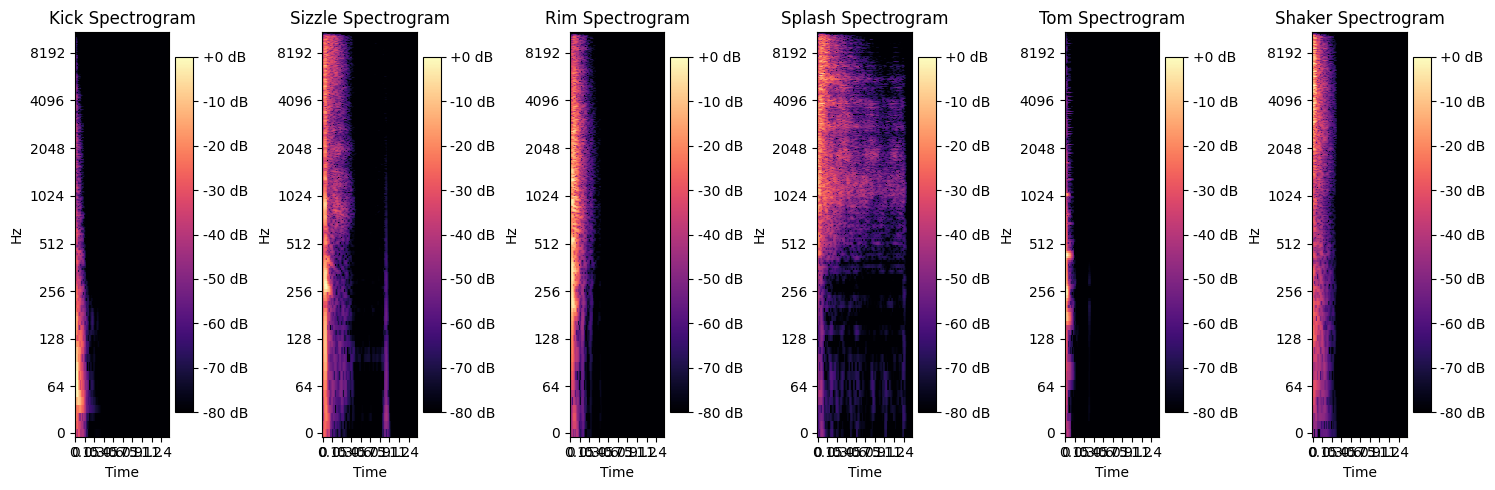


Also available: Bongo, Conga, Maracas, Metal, Hihat, Snare, Perc, FX, Ride, Agogo, Triangle, Whistle, Crash, Bass, Reverse, China, Tambourine, Vox, Noise, Clap, Woodblock, Clave, Bell, Cowbell, Cabasa, Vibraslap, Guiro, Timpani, Cuica, Timbale
You can modify this cell to plot spectrograms for other instruments.


In [341]:
# Let's plot spectrograms from actual files in your training data
import os
import glob
import matplotlib.pyplot as plt
import librosa
import numpy as np

# Function to find the first available audio file in each category
def find_sample_file(instrument_folder):
    """Find the first .wav file in the given instrument folder"""
    folder_path = f"TrainingData/AudioSamples/{instrument_folder}"
    if os.path.exists(folder_path):
        wav_files = glob.glob(os.path.join(folder_path, "*.wav"))
        if wav_files:
            return wav_files[0]  # Return first available file
    return None

# Check what instrument folders we have
instruments_to_plot = []
available_folders = glob.glob("TrainingData/AudioSamples/*")
for folder in available_folders:
    if os.path.isdir(folder):
        folder_name = os.path.basename(folder)
        sample_file = find_sample_file(folder_name)
        if sample_file:
            instruments_to_plot.append((folder_name, sample_file))

print(f"Found {len(instruments_to_plot)} instrument categories with samples:")
for instrument, file_path in instruments_to_plot:
    print(f"  {instrument}: {os.path.basename(file_path)}")

# Plot spectrograms for the first 3 available instruments
plt.figure(figsize=(15, 5))

for idx, (instrument, filename) in enumerate(instruments_to_plot[:16]):
    try:
        print(f"\nProcessing {instrument}: {os.path.basename(filename)}")
        
        # Load and process audio
        y, sr = librosa.load(filename, sr=22050, mono=True)
        y = librosa.util.fix_length(y, size=32600)
        y_harm, y_perc = librosa.effects.hpss(y)
        
        # Create spectrogram
        hop_length = 256
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y_perc, hop_length=hop_length)),
                                    ref=np.max)
        
        # Plot
        plt.subplot(1, 6, idx + 1)
        librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,
                                x_axis='time')
        plt.title(f'{instrument} Spectrogram')
        plt.colorbar(format='%+2.0f dB')
        
    except Exception as e:
        print(f"Error processing {instrument}: {str(e)}")

plt.tight_layout()
plt.show()

# Also plot all available instruments if we have more than 3
if len(instruments_to_plot) > 6:
    print(f"\nAlso available: {', '.join([inst for inst, _ in instruments_to_plot[6:]])}")
    print("You can modify this cell to plot spectrograms for other instruments.")

<h1> Building the Autoencoder </h1>

In [342]:
input_img = keras.Input(shape=(128, 128, 1))

###
# Define the encoder of an autoencoder. 
# It should take in the 'input_img' variable, and output the encoded input, with a chosen number of dimensions
# Define multiple sets of {convolutional, maxpooling} layers.
# YOUR CODE BELOW

#encoded
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
#
###


###
# Define the decoder of our autoencoder. 
# It should take in the 'encoded' variable, and output the decoded input, here the same dimensions as the input (128, 128, 1).
# Define multiple sets of {convolutional, upsampling} layers.
# YOUR CODE BELOW
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

#
###

autoencoder = keras.Model(input_img, decoded)

# Feel free to play around with the learning rate.
opt = Adam(learning_rate=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

<h1> Training the Autoencoder </h1>

In [343]:
print(x_train.shape)
autoencoder.fit(x_train, x_train,
               epochs=10,
               batch_size=128,
               shuffle=True,
               callbacks=[TensorBoard(log_dir="logs")])

(8924, 128, 128, 1)
Epoch 1/10
Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 23s 297ms/step - loss: 0.0060
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 23s 297ms/step - loss: 0.0060
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 277ms/step - loss: 0.0040
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 277ms/step - loss: 0.0040
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 265ms/step - loss: 0.0034
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 265ms/step - loss: 0.0034
Epoch 4/10
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step - loss: 0.0031
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step - loss: 0.0031
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 256ms/step - loss: 0.0030
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 256ms/step - loss: 0.0030
Epoch 6/10
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 250ms/step - loss: 0.0029
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 250ms/step - loss: 0.0029
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 244ms/step - loss: 0.0028
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 244ms/step - loss: 0.0028
Epoch 8/10
Epoch 8/10
70/70 

<h1> Encode all the spectrograms into the latent variable space </h1>

<p> Separate the encoder part of that model and save that to a file we can use later. </p>

In [344]:
encoder=keras.Model(input_img, encoded)
encoder_output = encoder.predict(x_train)
encoder.save("models/encoder.keras")


279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


<h1> Visualize the different classes spread across part of the latent space </h1>

encoder_output shape: (8924, 16, 16, 8)
Total elements in encoder_output: 18276352
Number of samples (x_train): 8924
Calculated reshape: (8924, 2048)
(8924, 2048)


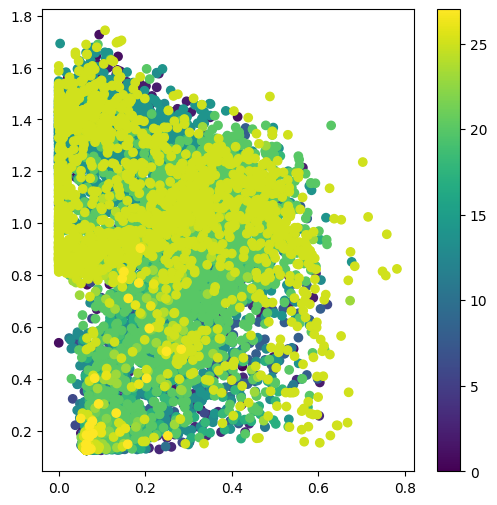

In [345]:
# This cell is already correct - it dynamically calculates the reshape dimensions
print(f"encoder_output shape: {encoder_output.shape}")
print(f"Total elements in encoder_output: {encoder_output.size}")
print(f"Number of samples (x_train): {len(x_train)}")

# Calculate the correct reshape dimensions
num_samples = encoder_output.shape[0]
feature_dims = encoder_output.shape[1] * encoder_output.shape[2] * encoder_output.shape[3]

print(f"Calculated reshape: ({num_samples}, {feature_dims})")

# Use the actual dimensions instead of hardcoded values
latents = np.reshape(encoder_output, [num_samples, feature_dims])
print(latents.shape)
plt.figure(figsize=(6, 6))
plt.scatter(latents[:, 0], latents[:, 1], c=t_train)
plt.colorbar()
plt.show()

<h1> Building the CNN </h1>

In [346]:
t = np.array(t_train)

# Ensure labels are contiguous 0..num_classes-1
unique_labels = np.unique(t)
if not np.array_equal(unique_labels, np.arange(len(unique_labels))):
    print("⚠️  Non-contiguous label indices detected. Remapping.")
    remap = {old:i for i, old in enumerate(unique_labels)}
    t = np.array([remap[v] for v in t])
    unique_labels = np.unique(t)
print("Label set after normalization:", unique_labels)
num_classes = len(unique_labels)
print(f"Inferred num_classes: {num_classes}")

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(encoder_output, t, test_size=0.2, stratify=t, random_state=42)

# Neural network
model = keras.Sequential([
        keras.layers.Flatten(input_shape=(encoder_output.shape[1], encoder_output.shape[2], encoder_output.shape[3])),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(num_classes, activation='softmax')
])
    
optimiser = keras.optimizers.Adam(learning_rate=0.0003)

model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

print(f"Model output units: {model.layers[-1].units} (should match num_classes={num_classes})")
model.summary()

Label set after normalization: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Inferred num_classes: 28
Model output units: 28 (should match num_classes=28)
Model output units: 28 (should match num_classes=28)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_15 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,216,924 (4.64 MB)

 Trainable params: 1,216,924 (4.64 MB)

 Non-trainable params: 0 (0.00 B)

<h1> Training the CNN on the features from the CAE </h1>

In [347]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=60,
    callbacks=callbacks,
    verbose=1
)

# Safe save paths
models_dir = os.path.join(filepath, 'models')
results_dir = os.path.join(filepath, 'results')
os.makedirs(models_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

model_path = os.path.join(models_dir, 'model2.keras')
model.save(model_path)
print(f"✅ Model saved to {model_path}")

Epoch 1/60
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4859 - loss: 1.8970 - val_accuracy: 0.6230 - val_loss: 1.3434 - learning_rate: 3.0000e-04
Epoch 2/60
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4859 - loss: 1.8970 - val_accuracy: 0.6230 - val_loss: 1.3434 - learning_rate: 3.0000e-04
Epoch 2/60
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6009 - loss: 1.4422 - val_accuracy: 0.6521 - val_loss: 1.2284 - learning_rate: 3.0000e-04
Epoch 3/60
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6009 - loss: 1.4422 - val_accuracy: 0.6521 - val_loss: 1.2284 - learning_rate: 3.0000e-04
Epoch 3/60
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6180 - loss: 1.3424 - val_accuracy: 0.6768 - val_loss: 1.1502 - learning_rate: 3.0000e-04
Epoch 4/60
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6180 - loss: 1.3424 - val_accuracy: 0.6768 - val_loss: 1.1502 - learning_rate: 3.0000e-04
Epoch 4/60
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


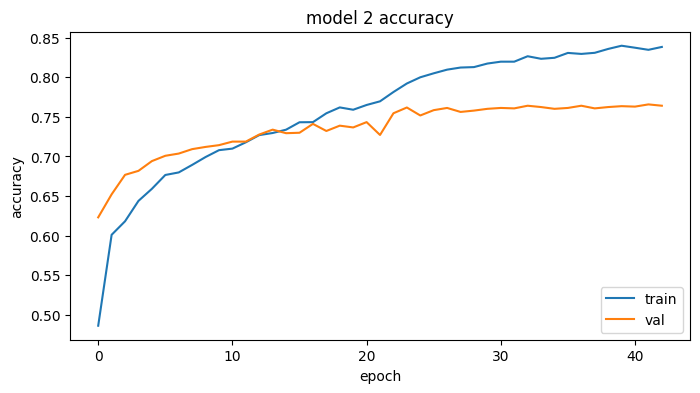

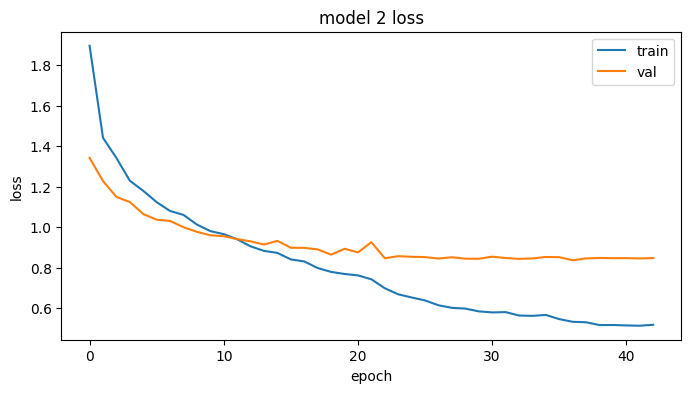

📄 History saved to /Users/Gilby/Projects/MLAudioClassifier/models/model2_history.json


In [348]:
import json
print(history.history.keys())
# summarize history for accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model 2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.savefig(os.path.join(results_dir,'model2_accuracy.png'), dpi=120, bbox_inches='tight')
plt.show()
# summarize history for loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model 2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig(os.path.join(results_dir,'model2_loss.png'), dpi=120, bbox_inches='tight')
plt.show()

# Save training history json
history_path = os.path.join(models_dir, 'model2_history.json')
with open(history_path, 'w') as f:
    json.dump({k:[float(vv) for vv in vals] for k, vals in history.history.items()}, f, indent=2)
print(f"📄 History saved to {history_path}")

<h1>Load Libraries for Spectral Analysis</h1>

In [349]:
# Loading libraries - cleaned up and optimized order
import os
import numpy as np
import glob
import json

# Data processing and visualization
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Audio processing
import librosa
import librosa.display

# Deep learning
import keras
from keras import layers
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

print("✅ All libraries imported successfully!")
print(f"Keras version: {keras.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Librosa version: {librosa.__version__}")
# please set this variable to where you cloned the git repo "MLAudioClassifier"

filepath = "/Users/Gilby/Projects/MLAudioClassifier"
os.chdir(filepath)

# make sure you have extracted the Training Data before you proceed with the rest of the notebook
# with something like "unzip TrainingData.zip"
# Check actual spectrogram dimensions before preprocessing
print("Checking spectrogram dimensions...")
sample_file = glob.glob("TrainingData/AudioSamples/*/*.wav")[0]
waveform, samplerate = librosa.load(sample_file, sr=22050, mono=True)
waveform = librosa.util.fix_length(waveform, size=32600)
spec = librosa.feature.melspectrogram(y=waveform, sr=samplerate, n_fft=512, hop_length=256)
normalized_spec = librosa.util.normalize(spec)
print(f"Original spectrogram shape: {normalized_spec.shape}")

# If your spectrograms are not 128x128, we need to resize them
import cv2

ALLOWED_INSTRUMENTS = ["Agogo", "Bass", "Bell", "Bongo", "Cabasa", "China", "Clap", "Clave", "Conga", "Cowbell", "Cuica", "Crash", "Cuica", "Guiro", "Hihat", "Kick", "Maracas", "Metal", "Ride", "Rim", "Shaker", "Snare", "Splash", "Tambourine", "Timbale", "Timpani", "Tom", "Woodblock", "Whistle"]  # target 6 classes
print("Target instrument classes:", ALLOWED_INSTRUMENTS)

# Build mapping only for allowed instruments present in dataset
os.chdir("TrainingData/AudioSamples")
available_folders_all = sorted([f for f in glob.glob("*") if os.path.isdir(f)])
print(f"Found {len(available_folders_all)} total folders: {available_folders_all}")

# Filter to allowed instruments actually present
folder_names = [f for f in available_folders_all if f in ALLOWED_INSTRUMENTS]
missing = [f for f in ALLOWED_INSTRUMENTS if f not in folder_names]
if missing:
    print("⚠️ Missing expected instrument folders:", missing)
print(f"Using {len(folder_names)} instrument folders for training: {folder_names}")

if len(folder_names) == 0:
    raise RuntimeError("No allowed instrument folders found. Please ensure training data is organized under 'TrainingData/AudioSamples/<InstrumentName>'.")

# Create deterministic class index mapping
class_index = {inst: idx for idx, inst in enumerate(sorted(folder_names))}
print("Class index mapping:", class_index)

x_train = []
t_train = []

def resize_spectrogram(spec, target_size=(128, 128)):
    """Resize spectrogram to target dimensions"""
    spec_norm = ((spec - spec.min()) / (spec.max() - spec.min() + 1e-9) * 255).astype(np.uint8)
    resized = cv2.resize(spec_norm, target_size)
    return resized.astype(np.float32) / 255.0

file_count = 0
for instrument in folder_names:
    os.chdir(instrument)
    file_names = glob.glob("*.wav")
    if not file_names:
        print(f"⚠️  No wav files in {instrument}")
    for wav in file_names:
        try:
            waveform, samplerate = librosa.load(wav, sr=22050, mono=True)
            waveform = librosa.util.fix_length(waveform, size=32600)
            spec = librosa.feature.melspectrogram(y=waveform, sr=samplerate, n_fft=512, hop_length=256)
            normalized_spec = librosa.util.normalize(spec)
            if normalized_spec.shape != (128, 128):
                normalized_spec = resize_spectrogram(normalized_spec, target_size=(128, 128))
            x_train.append(normalized_spec)
            t_train.append(class_index[instrument])
            file_count += 1
            if file_count % 200 == 0:
                print(f"Processed {file_count} files...")
        except Exception as e:
            print(f"Error processing {instrument}/{wav}: {e}")
    os.chdir("..")

x_train = np.array(x_train, dtype=np.float32)
# Add channel dimension
x_train = x_train[..., np.newaxis]

os.chdir(filepath)

print(f"Final x_train shape: {x_train.shape}")
print(f"Total samples: {len(t_train)}")
print(f"Label distribution: {np.bincount(t_train)}")

# Consistency checks
def check_data_consistency():
    print("=== Data Consistency Check ===")
    print(f"x_train shape: {x_train.shape}")
    print(f"t_train length: {len(t_train)}")
    unique_classes = sorted(set(t_train))
    print(f"Unique class indices: {unique_classes}")
    print(f"Class counts: {np.bincount(t_train)}")
    return len(unique_classes)

num_classes = check_data_consistency()
print(f"✅ Using {num_classes} classes.")
if num_classes != 6:
    print("⚠️  Note: Number of classes differs from expected 6. Model will adapt dynamically.")

✅ All libraries imported successfully!
Keras version: 3.11.3
NumPy version: 2.2.6
Librosa version: 0.11.0
Checking spectrogram dimensions...
Original spectrogram shape: (128, 128)
Target instrument classes: ['Agogo', 'Bass', 'Bell', 'Bongo', 'Cabasa', 'China', 'Clap', 'Clave', 'Conga', 'Cowbell', 'Cuica', 'Crash', 'Cuica', 'Guiro', 'Hihat', 'Kick', 'Maracas', 'Metal', 'Ride', 'Rim', 'Shaker', 'Snare', 'Splash', 'Tambourine', 'Timbale', 'Timpani', 'Tom', 'Woodblock', 'Whistle']
Found 36 total folders: ['Agogo', 'Bass', 'Bell', 'Bongo', 'Cabasa', 'China', 'Clap', 'Clave', 'Conga', 'Cowbell', 'Crash', 'Cuica', 'FX', 'Guiro', 'Hihat', 'Kick', 'Maracas', 'Metal', 'Noise', 'Perc', 'Reverse', 'Ride', 'Rim', 'Shaker', 'Sizzle', 'Snare', 'Splash', 'Tambourine', 'Timbale', 'Timpani', 'Tom', 'Triangle', 'Vibraslap', 'Vox', 'Whistle', 'Woodblock']
Using 28 instrument folders for training: ['Agogo', 'Bass', 'Bell', 'Bongo', 'Cabasa', 'China', 'Clap', 'Clave', 'Conga', 'Cowbell', 'Crash', 'Cuica', '

<h1> Let's plot a few of the spectrograms so we know what each class looks like </h1>

Found 36 instrument categories with samples:
  Kick: Br Kick 2 [V1].wav
  Sizzle: SD-Sizzle.wav
  Rim: Rim 2.wav
  Splash: Cymbal 12#Splash.wav
  Tom: 05 Ana 2Hi.wav
  Shaker: Track  2 Shaker.wav
  Bongo: Hi Bongo Wet.wav
  Conga: CH_mt_m  1-L.wav
  Maracas: V-Drum Maracas.wav
  Metal: Metal Noise.wav
  Hihat: HiHat_120.wav
  Snare: Snare (12).wav
  Perc: Perc2 128.wav
  FX: Blip Scratch.wav
  Ride: Ride 1.wav
  Agogo: Agogo Bell H [V1].wav
  Triangle: 68 G#5 - Triangle Mute3.wav
  Whistle: Apito Hi Short.wav
  Crash: Crash 3 [V2].wav
  Bass: Bass Kalimba C2.wav
  Reverse: Rev S.wav
  China: China Cymbal 3 [V2].wav
  Tambourine: Tambourine 7.wav
  Vox: BassDrum-Pop Vox.wav
  Noise: 25 C#2 - Cutting Noise 2.wav
  Clap: Clap 2.wav
  Woodblock: Wood Block Hi.wav
  Clave: Clave Lo.wav
  Bell: Bell_44d.wav
  Cowbell: ChaCha Cowbell 1 [V1].wav
  Cabasa: Real Cabasa 2.wav
  Vibraslap: P Vibraslap.wav
  Guiro: Guiro Long.wav
  Timpani: Timpani.wav
  Cuica: Cuica 04.wav
  Timbale: p Timbale.wav

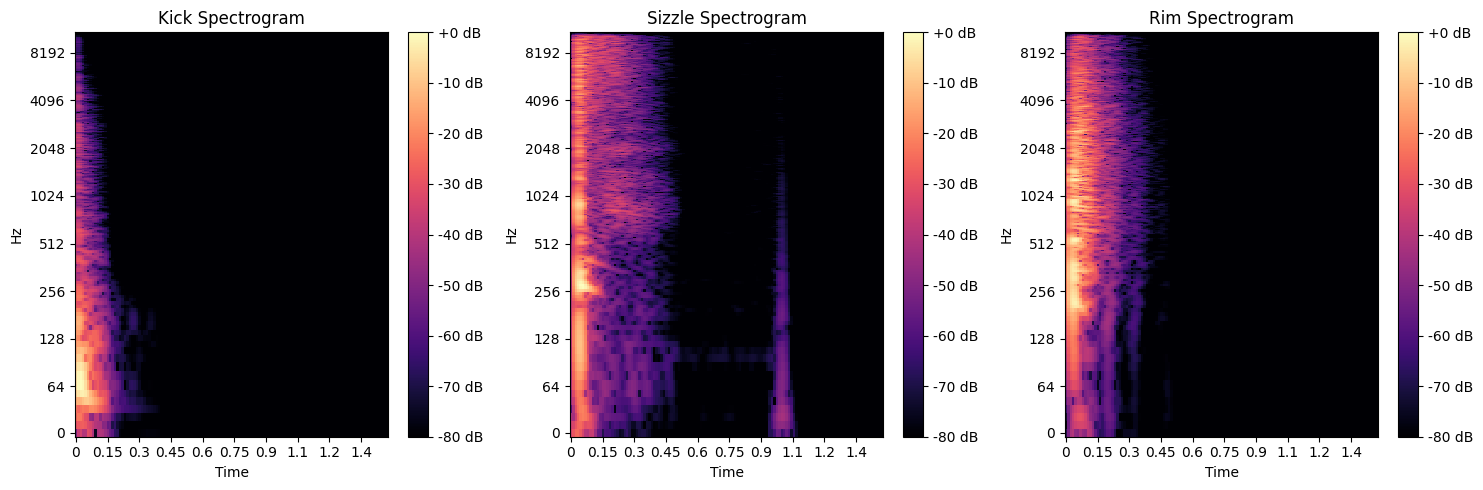


Also available: Splash, Tom, Shaker, Bongo, Conga, Maracas, Metal, Hihat, Snare, Perc, FX, Ride, Agogo, Triangle, Whistle, Crash, Bass, Reverse, China, Tambourine, Vox, Noise, Clap, Woodblock, Clave, Bell, Cowbell, Cabasa, Vibraslap, Guiro, Timpani, Cuica, Timbale
You can modify this cell to plot spectrograms for other instruments.


In [350]:
# Let's plot spectrograms from actual files in your training data
import os
import glob
import matplotlib.pyplot as plt
import librosa
import numpy as np

# Function to find the first available audio file in each category
def find_sample_file(instrument_folder):
    """Find the first .wav file in the given instrument folder"""
    folder_path = f"TrainingData/AudioSamples/{instrument_folder}"
    if os.path.exists(folder_path):
        wav_files = glob.glob(os.path.join(folder_path, "*.wav"))
        if wav_files:
            return wav_files[0]  # Return first available file
    return None

# Check what instrument folders we have
instruments_to_plot = []
available_folders = glob.glob("TrainingData/AudioSamples/*")
for folder in available_folders:
    if os.path.isdir(folder):
        folder_name = os.path.basename(folder)
        sample_file = find_sample_file(folder_name)
        if sample_file:
            instruments_to_plot.append((folder_name, sample_file))

print(f"Found {len(instruments_to_plot)} instrument categories with samples:")
for instrument, file_path in instruments_to_plot:
    print(f"  {instrument}: {os.path.basename(file_path)}")

# Plot spectrograms for the first 3 available instruments
plt.figure(figsize=(15, 5))

for idx, (instrument, filename) in enumerate(instruments_to_plot[:3]):
    try:
        print(f"\nProcessing {instrument}: {os.path.basename(filename)}")
        
        # Load and process audio
        y, sr = librosa.load(filename, sr=22050, mono=True)
        y = librosa.util.fix_length(y, size=32600)
        y_harm, y_perc = librosa.effects.hpss(y)
        
        # Create spectrogram
        hop_length = 256
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y_perc, hop_length=hop_length)),
                                    ref=np.max)
        
        # Plot
        plt.subplot(1, 3, idx + 1)
        librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,
                                x_axis='time')
        plt.title(f'{instrument} Spectrogram')
        plt.colorbar(format='%+2.0f dB')
        
    except Exception as e:
        print(f"Error processing {instrument}: {str(e)}")

plt.tight_layout()
plt.show()

# Also plot all available instruments if we have more than 3
if len(instruments_to_plot) > 3:
    print(f"\nAlso available: {', '.join([inst for inst, _ in instruments_to_plot[3:]])}")
    print("You can modify this cell to plot spectrograms for other instruments.")

<h1> Building the Autoencoder </h1>

In [351]:
input_img = keras.Input(shape=(128, 128, 1))

###
# Define the encoder of an autoencoder. 
# It should take in the 'input_img' variable, and output the encoded input, with a chosen number of dimensions
# Define multiple sets of {convolutional, maxpooling} layers.
# YOUR CODE BELOW

#encoded
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
#
###


###
# Define the decoder of our autoencoder. 
# It should take in the 'encoded' variable, and output the decoded input, here the same dimensions as the input (128, 128, 1).
# Define multiple sets of {convolutional, upsampling} layers.
# YOUR CODE BELOW
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

#
###

autoencoder = keras.Model(input_img, decoded)

# Feel free to play around with the learning rate.
opt = Adam(learning_rate=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

<h1> Training the Autoencoder </h1>

In [ ]:
print(x_train.shape)
autoencoder.fit(x_train, x_train,
               epochs=10,
               batch_size=128,
               shuffle=True,
               callbacks=[TensorBoard(log_dir="logs")])

(8924, 128, 128, 1)
Epoch 1/10
Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 276ms/step - loss: 0.0063
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 276ms/step - loss: 0.0063
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 287ms/step - loss: 0.0041
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 287ms/step - loss: 0.0041
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 263ms/step - loss: 0.0035
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 263ms/step - loss: 0.0035
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 266ms/step - loss: 0.0032
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 266ms/step - loss: 0.0032
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 270ms/step - loss: 0.0031
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 270ms/step - loss: 0.0031
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 263ms/step - loss: 0.0029
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 263ms/step - loss: 0.0029
Epoch 7/10
Epoch 7/10
57/70 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - loss: 0.0029

<h1> Encode all the spectrograms into the latent variable space </h1>

<p> Separate the encoder part of that model and save that to a file we can use later. </p>

In [ ]:
encoder=keras.Model(input_img, encoded)
encoder_output = encoder.predict(x_train)
encoder.save("models/encoder.keras")

279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


<h1> Visualize the different classes spread across part of the latent space </h1>

encoder_output shape: (8924, 16, 16, 8)
Total elements in encoder_output: 18276352
Number of samples (x_train): 8924
Calculated reshape: (8924, 2048)
(8924, 2048)


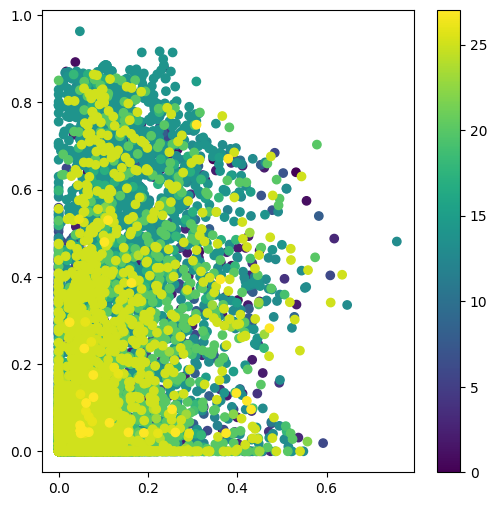

Label set after normalization: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Inferred num_classes: 28
Model output units: 28 (should match num_classes=28)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_12 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,216,924 (4.64 MB)

 Trainable params: 1,216,924 (4.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# This cell is already correct - it dynamically calculates the reshape dimensions
print(f"encoder_output shape: {encoder_output.shape}")
print(f"Total elements in encoder_output: {encoder_output.size}")
print(f"Number of samples (x_train): {len(x_train)}")

# Calculate the correct reshape dimensions
num_samples = encoder_output.shape[0]
feature_dims = encoder_output.shape[1] * encoder_output.shape[2] * encoder_output.shape[3]

print(f"Calculated reshape: ({num_samples}, {feature_dims})")

# Use the actual dimensions instead of hardcoded values
latents = np.reshape(encoder_output, [num_samples, feature_dims])
print(latents.shape)
plt.figure(figsize=(6, 6))
plt.scatter(latents[:, 0], latents[:, 1], c=t_train)
plt.colorbar()
plt.show()
t = np.array(t_train)

# Ensure labels are contiguous 0..num_classes-1
unique_labels = np.unique(t)
if not np.array_equal(unique_labels, np.arange(len(unique_labels))):
    print("⚠️  Non-contiguous label indices detected. Remapping.")
    remap = {old:i for i, old in enumerate(unique_labels)}
    t = np.array([remap[v] for v in t])
    unique_labels = np.unique(t)
print("Label set after normalization:", unique_labels)
num_classes = len(unique_labels)
print(f"Inferred num_classes: {num_classes}")

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(encoder_output, t, test_size=0.2, stratify=t, random_state=42)

# Neural network
model = keras.Sequential([
        keras.layers.Flatten(input_shape=(encoder_output.shape[1], encoder_output.shape[2], encoder_output.shape[3])),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(num_classes, activation='softmax')
])
    
optimiser = keras.optimizers.Adam(learning_rate=0.0003)

model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

print(f"Model output units: {model.layers[-1].units} (should match num_classes={num_classes})")
model.summary()

<h1> Training the CNN on the features from the CAE </h1>

Epoch 1/60
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4758 - loss: 1.9122 - val_accuracy: 0.6078 - val_loss: 1.3974 - learning_rate: 3.0000e-04
Epoch 2/60
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4758 - loss: 1.9122 - val_accuracy: 0.6078 - val_loss: 1.3974 - learning_rate: 3.0000e-04
Epoch 2/60
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5869 - loss: 1.4588 - val_accuracy: 0.6454 - val_loss: 1.2536 - learning_rate: 3.0000e-04
Epoch 3/60
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5869 - loss: 1.4588 - val_accuracy: 0.6454 - val_loss: 1.2536 - learning_rate: 3.0000e-04
Epoch 3/60
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6175 - loss: 1.3479 - val_accuracy: 0.6504 - val_loss: 1.2221 - learning_rate: 3.0000e-04
Epoch 4/60
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6175 - loss: 1.3479 - val_accuracy: 0.6504 - val_loss: 1.2221 - learning_rate: 3.0000e-04
Epoch 4/60
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 

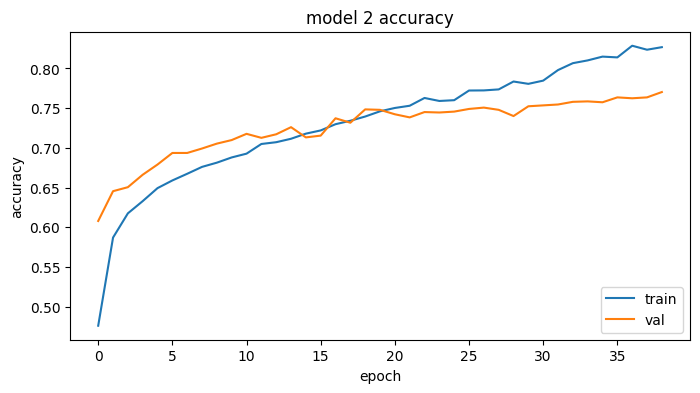

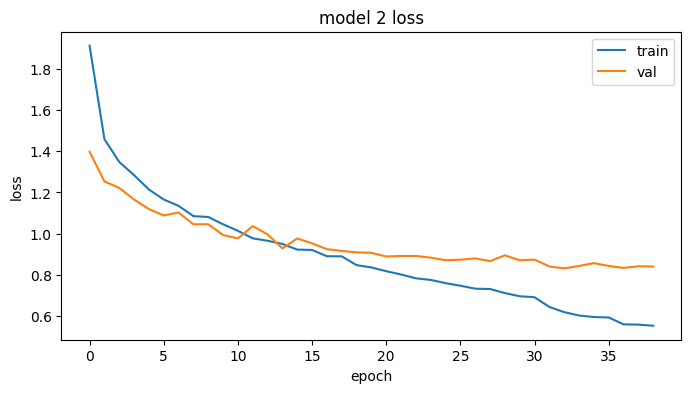

📄 History saved to /Users/Gilby/Projects/MLAudioClassifier/models/model2_history.json


In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=60,
    callbacks=callbacks,
    verbose=1
)

# Safe save paths
models_dir = os.path.join(filepath, 'models')
results_dir = os.path.join(filepath, 'results')
os.makedirs(models_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

model_path = os.path.join(models_dir, 'model2.keras')
model.save(model_path)
print(f"✅ Model saved to {model_path}")
import json
print(history.history.keys())
# summarize history for accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model 2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.savefig(os.path.join(results_dir,'model2_accuracy.png'), dpi=120, bbox_inches='tight')
plt.show()
# summarize history for loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model 2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig(os.path.join(results_dir,'model2_loss.png'), dpi=120, bbox_inches='tight')
plt.show()

# Save training history json
history_path = os.path.join(models_dir, 'model2_history.json')
with open(history_path, 'w') as f:
    json.dump({k:[float(vv) for vv in vals] for k, vals in history.history.items()}, f, indent=2)
print(f"📄 History saved to {history_path}")

## 12. MFCC Feature Extractor Notebook



**Source:** `notebooks/MFCC_Feature_Extractor.ipynb`



This workflow performs the original MFCC extraction for both training and test datasets while maintaining compatibility with the six canonical instrument classes.


### Original Introduction



# MFCC Feature Extractor 



This is stage 1 of the Method 1 pipeline, so this should be the first notebook you run after unzipping the data archives. 



**Updated to support 6 instrument classes**: Crash, Hihat, Kick, Ride, Snare, Tom


> The following workflows reuse the environment, imports, and paths configured in Part 1.

In [ ]:
# please set this variable to where you cloned the git repo "MLAudioClassifier"
# Working directory already set via PROJECT_ROOT in Part 1

# make sure you have extracted the Training and Testing Data before you proceed with the rest of the notebook
# with something like "unzip TrainingData.zip"

In [ ]:
# Reset to project root directory (run this if you get lost in subdirectories)

# Working directory already set via PROJECT_ROOT in Part 1
print(f"✅ Reset to project directory: {os.getcwd()}")

# Verify we can see the expected directories
expected_dirs = ["TrainingData", "TestData"]
for directory in expected_dirs:
    if os.path.exists(directory):
        print(f"✅ Found {directory}/")
    else:
        print(f"❌ Missing {directory}/")
        
print("Ready to proceed!")

✅ Reset to project directory: /Users/Gilby/Projects/MLAudioClassifier
✅ Found TrainingData/
✅ Found TestData/
Ready to proceed!


### Loading Training Data



This block loads each training audio file and computes MFCCs for the full 34 fine-grained instrument classes, while retaining compatibility with the six-class canonical mapping.


In [ ]:
# Verify directory structure before processing

# First, ensure we're in the correct project directory
os.chdir(filepath)
print("Checking directory structure...")
print(f"Current directory: {os.getcwd()}")

# Check training data
train_path = "TrainingData/AudioSamples"
if os.path.exists(train_path):
    print(f"✅ Found {train_path}")
    train_folders = [f for f in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, f)) and not f.startswith('.')]
    print(f"   Training classes: {train_folders}")
    for folder in train_folders:
        wav_count = len(glob.glob(os.path.join(train_path, folder, "*.wav")))
        print(f"   {folder}: {wav_count} samples")
else:
    print(f"❌ {train_path} not found!")

# Check test data  
test_path = "TestData"
if os.path.exists(test_path):
    print(f"✅ Found {test_path}")
    test_folders = [f for f in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, f)) and not f.startswith('.')]
    print(f"   Test classes: {test_folders}")
    for folder in test_folders:
        wav_count = len(glob.glob(os.path.join(test_path, folder, "*.wav")))
        print(f"   {folder}: {wav_count} samples")
else:
    print(f"❌ {test_path} not found!")

print("\nReady to process audio files!")
print("="*50)

Checking directory structure...
Current directory: /Users/Gilby/Projects/MLAudioClassifier
✅ Found TrainingData/AudioSamples
   Training classes: ['Kick', 'Sizzle', 'Rim', 'Splash', 'Tom', 'Shaker', 'Bongo', 'Conga', 'Maracas', 'Metal', 'Hihat', 'Snare', 'Perc', 'FX', 'Ride', 'Agogo', 'Triangle', 'Whistle', 'Crash', 'Bass', 'Reverse', 'China', 'Tambourine', 'Vox', 'Noise', 'Clap', 'Woodblock', 'Clave', 'Bell', 'Cowbell', 'Cabasa', 'Vibraslap', 'Guiro', 'Timpani', 'Cuica', 'Timbale']
   Kick: 1360 samples
   Sizzle: 3 samples
   Rim: 192 samples
   Splash: 23 samples
   Tom: 1828 samples
   Shaker: 54 samples
   Bongo: 151 samples
   Conga: 335 samples
   Maracas: 46 samples
   Metal: 23 samples
   Hihat: 969 samples
   Snare: 2264 samples
   Perc: 483 samples
   FX: 1595 samples
   Ride: 312 samples
   Agogo: 52 samples
   Triangle: 53 samples
   Whistle: 40 samples
   Crash: 187 samples
   Bass: 107 samples
   Reverse: 76 samples
   China: 33 samples
   Tambourine: 56 samples
   Vox: 

In [ ]:
# Ensure we're in the project root directory first

os.chdir(filepath)

print(f"Starting from: {os.getcwd()}")

os.chdir("TrainingData/AudioSamples")
folder_names = glob.glob("*")
# Filter out hidden files and directories
folder_names = [f for f in folder_names if not f.startswith('.') and os.path.isdir(f)]

all_samples = { 'label':[], 'mfcc':[] }
i=0
frames_max = 0

for instrument in folder_names:
    print(f"Processing {instrument} samples...")
    os.chdir(instrument)
    file_names = glob.glob("*.wav")
    print(f"  Found {len(file_names)} files")
    for wav in file_names:
        waveform, samplerate = librosa.load(wav, sr=44100, mono=True)
        waveform = librosa.util.fix_length(waveform, size=50000)
        # Fixed: Added y= parameter for newer librosa versions
        mfcc = librosa.feature.mfcc(y=waveform, sr=samplerate, n_mfcc=40, n_fft=2048, hop_length=512)
        normalized_mfcc = librosa.util.normalize(mfcc)
        all_samples['mfcc'].append(normalized_mfcc.tolist())
        all_samples['label'].append(i)
        # Update frames maximum
        #if (num_frames > frames_max):
            #frames_max = num_frames
    os.chdir("..")
    i=i+1
os.chdir(filepath)

print(f"Training data extraction complete!")
print(f"Total samples: {len(all_samples['label'])}")
print(f"Class distribution: {dict(zip(*np.unique(all_samples['label'], return_counts=True)))}")

Starting from: /Users/Gilby/Projects/MLAudioClassifier
Processing Kick samples...Processing Kick samples...
  Found 1360 files

  Found 1360 files
Processing Sizzle samples...
  Found 3 files
Processing Rim samples...
  Found 192 files
Processing Sizzle samples...
  Found 3 files
Processing Rim samples...
  Found 192 files
Processing Splash samples...
  Found 23 files
Processing Tom samples...
  Found 1828 files
Processing Splash samples...
  Found 23 files
Processing Tom samples...
  Found 1828 files
Processing Shaker samples...
  Found 54 files
Processing Bongo samples...
  Found 151 files
Processing Shaker samples...
  Found 54 files
Processing Bongo samples...
  Found 151 files
Processing Conga samples...
  Found 335 files
Processing Conga samples...
  Found 335 files
Processing Maracas samples...
  Found 46 files
Processing Metal samples...
  Found 23 files
Processing Maracas samples...
  Found 46 files
Processing Metal samples...
  Found 23 files
Processing Hihat samples...
  Fou

### Loading Testing Data



This block mirrors MFCC extraction for the held-out test set.


In [ ]:
os.chdir(filepath)
os.chdir("TestData")  # Fixed: removed the extra /TestData
folder_names = glob.glob("*")
# Filter out hidden files and directories
folder_names = [f for f in folder_names if not f.startswith('.') and os.path.isdir(f)]
test_samples = { 'label':[], 'mfcc':[] }

i=0
frames_max = 0

for instrument in folder_names:
    print(f"Processing {instrument} test samples...")
    os.chdir(instrument)
    file_names = glob.glob("*.wav")
    print(f"  Found {len(file_names)} files")
    for wav in file_names:
        waveform, samplerate = librosa.load(wav, sr=44100, mono=True)
        waveform = librosa.util.fix_length(waveform, size=50000)
        # Fixed: Added y= parameter for newer librosa versions
        mfcc = librosa.feature.mfcc(y=waveform, sr=samplerate, n_mfcc=40, n_fft=2048, hop_length=512)
        normalized_mfcc = librosa.util.normalize(mfcc)
        test_samples['mfcc'].append(normalized_mfcc.tolist())
        test_samples['label'].append(i)
        # Update frames maximum
        #if (num_frames > frames_max):
            #frames_max = num_frames
    os.chdir("..")
    i=i+1
os.chdir("..")

print(f"Test data extraction complete!")
print(f"Total test samples: {len(test_samples['label'])}")
print(f"Test class distribution: {dict(zip(*np.unique(test_samples['label'], return_counts=True)))}")

Processing Kick test samples...
  Found 100 files
Processing Rim test samples...
  Found 31 files
Processing Splash test samples...
  Found 4 files
Processing Tom test samples...
  Found 100 files
Processing Rim test samples...
  Found 31 files
Processing Splash test samples...
  Found 4 files
Processing Tom test samples...
  Found 100 files
Processing Shaker test samples...
  Found 10 files
Processing Bongo test samples...
  Found 24 files
Processing Conga test samples...
  Found 52 files
Processing Shaker test samples...
  Found 10 files
Processing Bongo test samples...
  Found 24 files
Processing Conga test samples...
  Found 52 files
Processing Maracas test samples...
  Found 9 files
Processing Metal test samples...
  Found 4 files
Processing Hihat test samples...
  Found 37 files
Processing Maracas test samples...
  Found 9 files
Processing Metal test samples...
  Found 4 files
Processing Hihat test samples...
  Found 37 files
Processing Snare test samples...
  Found 100 files
Pro

In [361]:
os.chdir(filepath)

json_path='data/mfcc_train_data.json'
with open(json_path, "w") as fp:
        json.dump(all_samples, fp, indent=4)

json_path2='data/mfcc_test_data.json'
with open(json_path2, "w") as fp2:
        json.dump(test_samples, fp2, indent=4)


## 13. Model 1 Training Notebook


**Source:** `notebooks/Model1_Train.ipynb`


This appendix preserves the original Model 1 training workflow, including the legacy data loading, label normalization, CNN architecture definition, training loop, and diagnostics. Run these cells if you want to reproduce the exact behaviour of the standalone notebook.

### Original Introduction


<h1> Training Notebook for Model 1 </h1>

> Environment remains configured from Part 1; no additional setup needed here.

<h1> Loading the training set of MFCC features from .json file </h1>

In [362]:
# Attempt to locate the training MFCC JSON file robustly
# Preferred / expected location based on project docs: data/mfcc_train_data.json
# Fallbacks: project root (mfcc_train_data.json), parent dir, or explicit override


POSSIBLE_PATHS = [
    Path('data/mfcc_train_data.json'),          # standard location
    Path('../data/mfcc_train_data.json'),       # if cwd is notebooks/
    Path('mfcc_train_data.json'),               # root fallback
    Path('../mfcc_train_data.json')             # legacy placement
]

found_path = None
for p in POSSIBLE_PATHS:
    if p.exists():
        found_path = p
        break

if found_path is None:
    print('❌ Could not find mfcc_train_data.json in expected locations:')
    for p in POSSIBLE_PATHS:
        print(f' - {p}')
    print('\n➡️  Please run the MFCC_Feature_Extractor notebook first to generate the file.')
    raise FileNotFoundError('mfcc_train_data.json not found')
else:
    print(f'✅ Using training MFCC file: {found_path}')

with open(found_path, 'r') as fp:
    data = json.load(fp)

# Expect keys: mfcc (list/array), label (list/array)
if not all(k in data for k in ('mfcc', 'label')):
    raise KeyError('Expected keys "mfcc" and "label" not found in JSON file')

X = np.array(data['mfcc'])
y = np.array(data['label'])
print('Loaded feature matrix shape:', X.shape)
print('Loaded label vector length:', len(y))

✅ Using training MFCC file: data/mfcc_train_data.json
Loaded feature matrix shape: (11337, 40, 98)
Loaded label vector length: 11337
Loaded feature matrix shape: (11337, 40, 98)
Loaded label vector length: 11337


In [363]:
# Diagnose and normalize label indices so they are contiguous starting at 0
unique_labels = np.unique(y)
print(f"Raw label values ({len(unique_labels)} classes detected): {unique_labels[:20]}{' ...' if len(unique_labels)>20 else ''}")
print(f"Max label value: {y.max()}")

# If labels are not 0..N-1 contiguous, remap them
needs_remap = (y.max() != len(unique_labels)-1) or (unique_labels != np.arange(len(unique_labels))).any()
if needs_remap:
    print("⚠️  Non-contiguous or gapped label indices detected. Remapping to 0..N-1.")
    label_mapping = {old:i for i, old in enumerate(sorted(unique_labels))}
    y = np.array([label_mapping[v] for v in y])
    unique_labels = np.unique(y)
    print("✅ Remap complete. New label set:", unique_labels)
    print("Mapping (old -> new):", label_mapping)
else:
    print("✅ Labels already contiguous 0..N-1. No remap needed.")

num_classes = len(unique_labels)
print("Inferred number of classes:", num_classes)

Raw label values (36 classes detected): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] ...
Max label value: 35
✅ Labels already contiguous 0..N-1. No remap needed.
Inferred number of classes: 36


In [364]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

In [365]:
# this should be 40 x 98
print(X.shape[1], X.shape[2])

40 98


<h1> Building the CNN </h1>

In [366]:
model = keras.Sequential([
        # input layer
        keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),
        # 1st dense layer
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.3),
        # 2nd dense layer
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.3),
        # 3rd dense layer
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.3),
        # output layer (num_classes inferred dynamically)
        keras.layers.Dense(num_classes, activation='softmax')
    ])

In [367]:
optimiser = keras.optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

print("Model compiled with:")
print(f" - Learning rate: {optimiser.learning_rate.numpy()}")
print(f" - Output classes: {num_classes}")

Model compiled with:
 - Learning rate: 0.0005000000237487257
 - Output classes: 36


In [368]:
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_17 (Flatten)            │ (None, 3920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 512)            │     2,007,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,176,420 (8.30 MB)

 Trainable params: 2,176,420 (8.30 MB)

 Non-trainable params: 0 (0.00 B)

<h1> Training the CNN on MFCC features </h1>
<p> And saving it to an .keras file so we can use it later. I will include some plots at the bottom to see how the training went. </p>

In [369]:

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

# ---- Fixed save section (avoid read-only root path) ----
save_dir = os.path.join(filepath, 'models')
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, 'model1.keras')
history_path = os.path.join(save_dir, 'model1_history.json')

model.save(model_path)

# Save training history
with open(history_path, 'w') as f:
    json.dump({k: [float(vv) for vv in vals] for k, vals in history.history.items()}, f, indent=2)

print(f"✅ Model saved to {model_path}")
print(f"✅ History saved to {history_path}")

Epoch 1/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4381 - loss: 2.1004 - val_accuracy: 0.5842 - val_loss: 1.6323 - learning_rate: 5.0000e-04
Epoch 2/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4381 - loss: 2.1004 - val_accuracy: 0.5842 - val_loss: 1.6323 - learning_rate: 5.0000e-04
Epoch 2/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5532 - loss: 1.6485 - val_accuracy: 0.6204 - val_loss: 1.3906 - learning_rate: 5.0000e-04
Epoch 3/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5532 - loss: 1.6485 - val_accuracy: 0.6204 - val_loss: 1.3906 - learning_rate: 5.0000e-04
Epoch 3/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5868 - loss: 1.4986 - val_accuracy: 0.6442 - val_loss: 1.2823 - learning_rate: 5.0000e-04
Epoch 4/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5868 - loss: 1.4986 - val_accuracy: 0.6442 - val_loss: 1.2823 - learning_rate: 5.0000e-04
Epoch 4/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


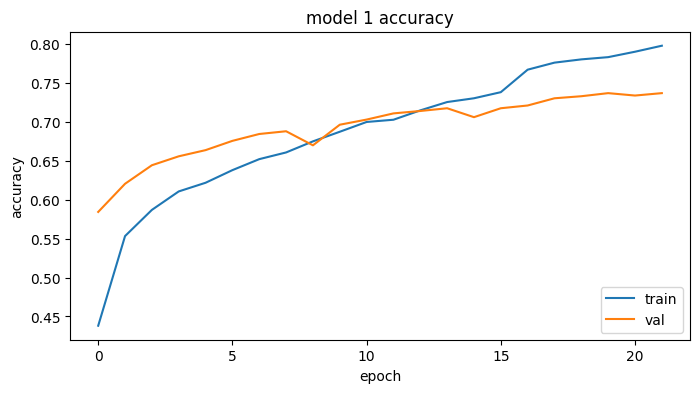

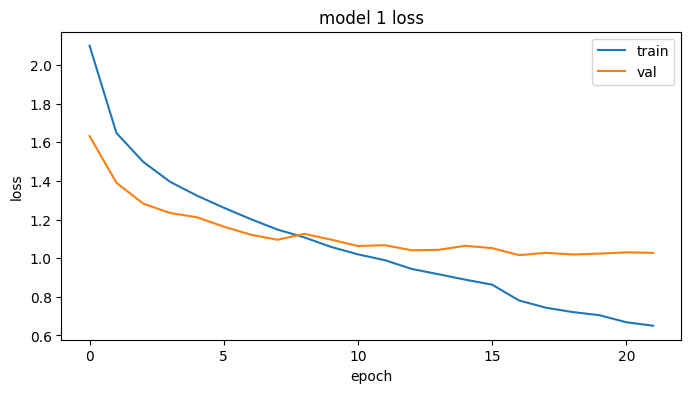

✅ Plots saved to /Users/Gilby/Projects/MLAudioClassifier/results


In [370]:
print(history.history.keys())
# summarize history for accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model 1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
# Use project-local results directory instead of root (read-only) path
results_dir = os.path.join(filepath, 'results')
os.makedirs(results_dir, exist_ok=True)
plt.savefig(os.path.join(results_dir, 'accuracy.png'), dpi=120, bbox_inches='tight')
plt.show()
# summarize history for loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model 1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig(os.path.join(results_dir, 'loss.png'), dpi=120, bbox_inches='tight')
plt.show()

print(f"✅ Plots saved to {results_dir}")

## 14. Model 2 Training Notebook

**Source:** `notebooks/Model2_Train.ipynb`

This appendix reproduces the autoencoder-based workflow that first learns a compact latent representation from mel-spectrograms and then trains a classifier on those encoded features. It shares storage and configuration with the earlier sections so you can run it end-to-end without leaving this notebook.

### Original Introduction

<h1> Training Notebook for Model 2 </h1>

In [371]:
# Model 2 configuration and helper imports
try:
    import cv2  # optional dependency used for some spectrogram ops / resizing
except ImportError as exc:
    raise ImportError("Model 2 training requires `opencv-python`. Install it with `pip install opencv-python`.") from exc

SPEC_CONFIG = {
    'sr': 22050,
    'target_samples': 32600,
    'n_fft': 512,
    'hop_length': 256,
    'n_mels': 128,
    'target_size': (128, 128),
}

ALLOWED_INSTRUMENTS_MODEL2 = TARGET_LABELS
MODEL2_LOG_DIR = PATHS['logs'] / 'model2_autoencoder'
MODEL2_LOG_DIR.mkdir(parents=True, exist_ok=True)
print(f"✅ Model 2 spec config loaded. Log dir: {MODEL2_LOG_DIR}")

✅ Model 2 spec config loaded. Log dir: /Users/Gilby/Projects/MLAudioClassifier/logs/train/model2_autoencoder


In [372]:
def compute_melspectrogram(path: Path, config: Dict[str, int]) -> np.ndarray:
    """Compute a normalized mel-spectrogram for Model 2 training."""
    waveform, _ = librosa.load(path, sr=config['sr'], mono=True)
    waveform = librosa.util.fix_length(waveform, size=config['target_samples'])
    spectrogram = librosa.feature.melspectrogram(
        y=waveform,
        sr=config['sr'],
        n_fft=config['n_fft'],
        hop_length=config['hop_length'],
        n_mels=config['n_mels']
    )
    spectrogram = librosa.util.normalize(spectrogram)
    spectrogram = cv2.resize(
        spectrogram.astype(np.float32),
        config['target_size'][::-1],
        interpolation=cv2.INTER_CUBIC
    )
    return spectrogram.astype(np.float32)

def prepare_spectrogram_dataset(
    data_dir: Path,
    allowed_instruments: List[str],
    config: Dict[str, int]
 ) -> Tuple[np.ndarray, np.ndarray, Dict[str, int], List[Path]]:
    """Create the Model 2 training set (spectrograms + labels)."""
    categories = [d for d in data_dir.iterdir() if d.is_dir() and d.name in allowed_instruments]
    categories = sorted(categories, key=lambda d: d.name)
    if not categories:
        raise RuntimeError(
            f"No instrument folders found in {data_dir}. Expected one of: {allowed_instruments}"
        )

    class_index = {cat.name: idx for idx, cat in enumerate(categories)}
    dataset = []
    labels = []
    file_paths: List[Path] = []

    for category in categories:
        wav_files = sorted(category.glob('*.wav'))
        print(f"Processing {category.name:>8s}: {len(wav_files):4d} files")
        for wav_path in tqdm(wav_files, desc=category.name, leave=False):
            spectrogram = compute_melspectrogram(wav_path, config)
            dataset.append(spectrogram)
            labels.append(class_index[category.name])
            file_paths.append(wav_path)

    if not dataset:
        raise RuntimeError(
            f"No audio files found for Model 2 training in {data_dir}. Check your dataset structure."
        )

    X = np.stack(dataset, axis=0).astype(np.float32)
    X = np.expand_dims(X, axis=-1)
    y = np.array(labels, dtype=np.int64)
    return X, y, class_index, file_paths

In [373]:
# Build or load the autoencoder training dataset
MODEL2_CACHE = PATHS['data'] / 'model2_spectrogram_cache.npz'

if MODEL2_CACHE.exists():
    print(f"🔁 Loading cached spectrograms from {MODEL2_CACHE}")
    cache = np.load(MODEL2_CACHE, allow_pickle=True)
    x_train_model2 = cache['x']
    t_train_model2 = cache['y']
    mapping_raw = cache['mapping']
    if isinstance(mapping_raw, np.ndarray):
        mapping_raw = mapping_raw.item() if mapping_raw.shape == () else mapping_raw.tolist()[0]
    label_mapping_model2 = json.loads(str(mapping_raw))
    files_key = 'files'
    source_files_model2 = cache[files_key].tolist() if files_key in cache.files else []
else:
    print(f"🚀 Extracting spectrograms from {PATHS['training_data']}")
    x_train_model2, t_train_model2, label_mapping_model2, file_paths_model2 = prepare_spectrogram_dataset(
        PATHS['training_data'],
        ALLOWED_INSTRUMENTS_MODEL2,
        SPEC_CONFIG
    )
    MODEL2_CACHE.parent.mkdir(parents=True, exist_ok=True)
    np.savez_compressed(
        MODEL2_CACHE,
        x=x_train_model2,
        y=t_train_model2,
        mapping=json.dumps(label_mapping_model2),
        files=np.array([str(p) for p in file_paths_model2])
    )
    source_files_model2 = [str(p) for p in file_paths_model2]
    with open(PATHS['models'] / 'model2_label_mapping.json', 'w') as fp:
        json.dump({k: int(v) for k, v in label_mapping_model2.items()}, fp, indent=2)

print(f"✅ Spectrogram tensor shape: {x_train_model2.shape}")
print(f"✅ Labels shape: {t_train_model2.shape}")
print(f"Classes: {label_mapping_model2}")
print(f"Cached dataset: {MODEL2_CACHE}")

🔁 Loading cached spectrograms from /Users/Gilby/Projects/MLAudioClassifier/data/model2_spectrogram_cache.npz
✅ Spectrogram tensor shape: (6920, 128, 128, 1)
✅ Labels shape: (6920,)
Classes: {'Crash': 0, 'Hihat': 1, 'Kick': 2, 'Ride': 3, 'Snare': 4, 'Tom': 5}
Cached dataset: /Users/Gilby/Projects/MLAudioClassifier/data/model2_spectrogram_cache.npz
✅ Spectrogram tensor shape: (6920, 128, 128, 1)
✅ Labels shape: (6920,)
Classes: {'Crash': 0, 'Hihat': 1, 'Kick': 2, 'Ride': 3, 'Snare': 4, 'Tom': 5}
Cached dataset: /Users/Gilby/Projects/MLAudioClassifier/data/model2_spectrogram_cache.npz


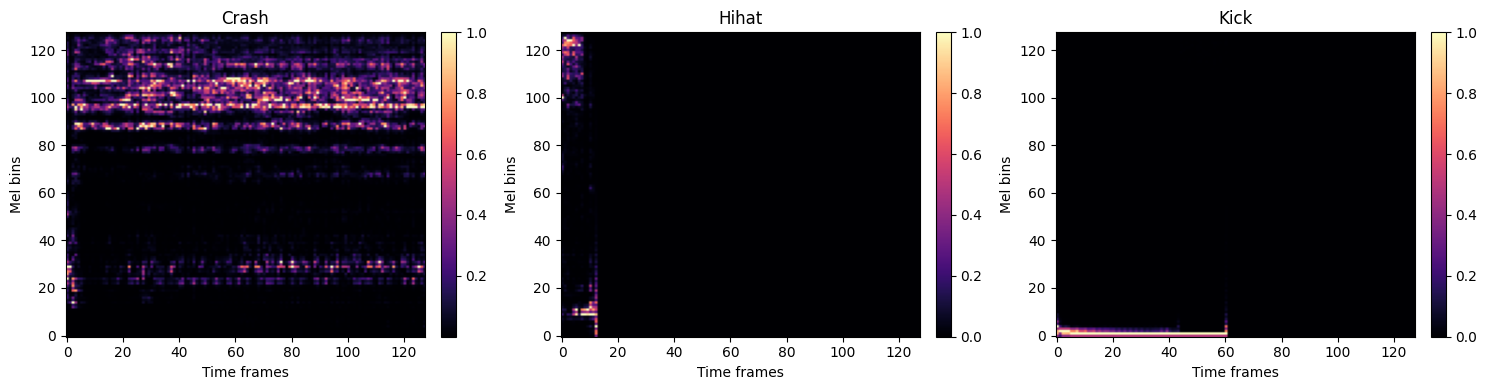

In [374]:
# Visualize a few spectrograms across classes
if x_train_model2.size == 0:
    raise RuntimeError("Model 2 dataset is empty. Check your TrainingData directory.")

num_examples = min(len(label_mapping_model2), 3)
fig, axes = plt.subplots(1, num_examples, figsize=(5 * num_examples, 4))
if num_examples == 1:
    axes = [axes]

class_names_by_index = {idx: name for name, idx in label_mapping_model2.items()}

for ax, class_idx in zip(axes, range(num_examples)):
    mask = t_train_model2 == class_idx
    if not np.any(mask):
        ax.axis('off')
        continue
    spec = x_train_model2[mask][0, ..., 0]
    im = ax.imshow(spec, aspect='auto', origin='lower', cmap='magma')
    ax.set_title(class_names_by_index[class_idx])
    ax.set_xlabel('Time frames')
    ax.set_ylabel('Mel bins')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [375]:
# Build the convolutional autoencoder
input_img_model2 = keras.Input(shape=(SPEC_CONFIG['target_size'][0], SPEC_CONFIG['target_size'][1], 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img_model2)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded_model2 = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_model2)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded_model2 = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

autoencoder_model2 = keras.Model(input_img_model2, decoded_model2, name='model2_autoencoder')
autoencoder_model2.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=1e-3))
autoencoder_model2.summary()

Model: "model2_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)     │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_126 (Conv2D)             │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_127 (Conv2D)             │ (None, 64, 64, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_128 (Conv2D)             │ (None, 32, 32, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_129 (Conv2D)             │ (None, 16, 16, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_54 (UpSampling2D) │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_130 (Conv2D)             │ (None, 32, 32, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_55 (UpSampling2D) │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_131 (Conv2D)             │ (None, 64, 64, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_56 (UpSampling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_132 (Conv2D)             │ (None, 128, 128, 1)    │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [376]:
# Train the autoencoder on spectrograms
autoencoder_callbacks = [TensorBoard(log_dir=str(MODEL2_LOG_DIR))]
autoencoder_history = autoencoder_model2.fit(
    x_train_model2,
    x_train_model2,
    epochs=10,
    batch_size=128,
    shuffle=True,
    callbacks=autoencoder_callbacks,
    verbose=1
)

encoder_model2 = keras.Model(input_img_model2, encoded_model2, name='model2_encoder')
encoder_output_model2 = encoder_model2.predict(x_train_model2, verbose=0)
encoder_path = PATHS['models'] / 'encoder.keras'
encoder_model2.save(encoder_path)
print(f"✅ Encoder saved to {encoder_path}")

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 293ms/step - loss: 0.0059
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 293ms/step - loss: 0.0059
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 299ms/step - loss: 0.0041
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 299ms/step - loss: 0.0041
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 314ms/step - loss: 0.0034
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 314ms/step - loss: 0.0034
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 304ms/step - loss: 0.0031
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 304ms/step - loss: 0.0031
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 286ms/step - loss: 0.0030
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 286ms/step - loss: 0.0030
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 291ms/step - loss: 0.0028
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 291ms/step - loss: 0.0028
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 285ms/step - loss: 0.0028
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 285ms/step - loss: 0.0028
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 264ms/

encoder_output_model2 shape: (6920, 16, 16, 8)
Latent dimensions: 2048


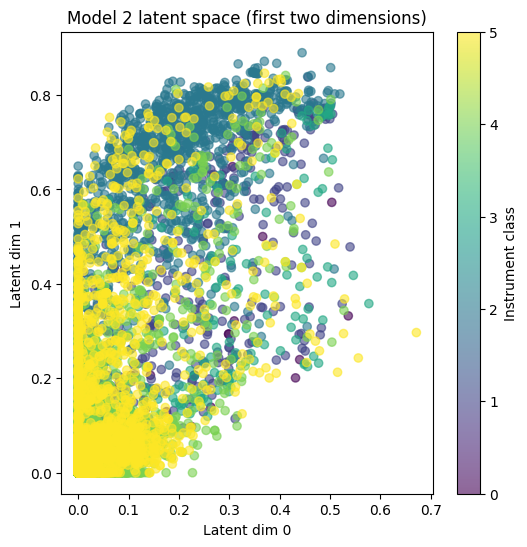

In [377]:
# Visualize encoder latent space
num_samples_model2 = encoder_output_model2.shape[0]
latent_dims_model2 = np.prod(encoder_output_model2.shape[1:])
print(f"encoder_output_model2 shape: {encoder_output_model2.shape}")
print(f"Latent dimensions: {latent_dims_model2}")
latents_model2 = encoder_output_model2.reshape(num_samples_model2, latent_dims_model2)

plt.figure(figsize=(6, 6))
plt.scatter(latents_model2[:, 0], latents_model2[:, 1], c=t_train_model2, cmap='viridis', alpha=0.6)
plt.colorbar(label='Instrument class')
plt.title('Model 2 latent space (first two dimensions)')
plt.xlabel('Latent dim 0')
plt.ylabel('Latent dim 1')
plt.show()

In [378]:
# Train classifier on encoded features
t_train_model2_normalized = t_train_model2.copy()
unique_labels_model2 = np.unique(t_train_model2_normalized)
if not np.array_equal(unique_labels_model2, np.arange(len(unique_labels_model2))):
    remap_map = {old: i for i, old in enumerate(unique_labels_model2)}
    t_train_model2_normalized = np.array([remap_map[val] for val in t_train_model2_normalized], dtype=np.int64)
    unique_labels_model2 = np.arange(len(unique_labels_model2))

X_train_enc, X_val_enc, y_train_enc, y_val_enc = train_test_split(
    encoder_output_model2,
    t_train_model2_normalized,
    test_size=TRAINING_CONFIG['validation_split'],
    stratify=t_train_model2_normalized,
    random_state=42
)

model2_classifier = keras.Sequential([
    keras.layers.Flatten(input_shape=encoder_output_model2.shape[1:]),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(unique_labels_model2), activation='softmax')
])

model2_classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model2_classifier.summary()

classifier_callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

history_model2_classifier = model2_classifier.fit(
    X_train_enc,
    y_train_enc,
    validation_data=(X_val_enc, y_val_enc),
    batch_size=TRAINING_CONFIG['batch_size'],
    epochs=60,
    callbacks=classifier_callbacks,
    verbose=1
)

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_18 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,214,086 (4.63 MB)

 Trainable params: 1,214,086 (4.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6682 - loss: 0.9156 - val_accuracy: 0.7847 - val_loss: 0.6088 - learning_rate: 3.0000e-04
Epoch 2/60
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6682 - loss: 0.9156 - val_accuracy: 0.7847 - val_loss: 0.6088 - learning_rate: 3.0000e-04
Epoch 2/60
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7681 - loss: 0.6592 - val_accuracy: 0.7934 - val_loss: 0.5735 - learning_rate: 3.0000e-04
Epoch 3/60
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7681 - loss: 0.6592 - val_accuracy: 0.7934 - val_loss: 0.5735 - learning_rate: 3.0000e-04
Epoch 3/60
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7971 - loss: 0.5938 - val_accuracy: 0.8208 - val_loss: 0.5282 - learning_rate: 3.0000e-04
Epoch 4/60
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7971 - loss: 0.5938 - val_accuracy: 0.8208 - val_loss: 0.5282 - learning_rate: 3.0000e-04
Epoch 4/60
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 

✅ Model 2 classifier saved to /Users/Gilby/Projects/MLAudioClassifier/models/model2.keras
✅ History saved to /Users/Gilby/Projects/MLAudioClassifier/models/model2_history.json


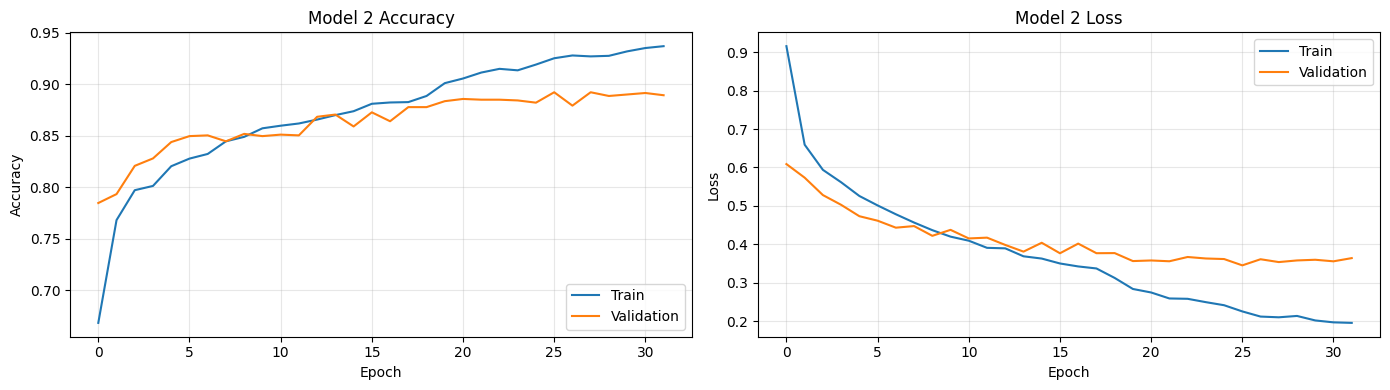

📈 Plots saved to /Users/Gilby/Projects/MLAudioClassifier/results/model2_training.png


In [379]:
# Persist Model 2 assets and visualize training curves
model2_path = PATHS['models'] / 'model2.keras'
model2_classifier.save(model2_path)
print(f"✅ Model 2 classifier saved to {model2_path}")

history_model2_path = PATHS['models'] / 'model2_history.json'
with open(history_model2_path, 'w') as fp:
    json.dump({k: [float(v) for v in vals] for k, vals in history_model2_classifier.history.items()}, fp, indent=2)
print(f"✅ History saved to {history_model2_path}")

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(history_model2_classifier.history['accuracy'], label='Train')
plt.plot(history_model2_classifier.history['val_accuracy'], label='Validation')
plt.title('Model 2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_model2_classifier.history['loss'], label='Train')
plt.plot(history_model2_classifier.history['val_loss'], label='Validation')
plt.title('Model 2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PATHS['results'] / 'model2_training.png', dpi=120, bbox_inches='tight')
plt.show()

print(f"📈 Plots saved to {PATHS['results'] / 'model2_training.png'}")

## 15. Model Evaluation Notebook

**Source:** `notebooks/Model_Evaluation.ipynb`

Side-by-side evaluation utilities for Model 1 (MFCC) and Model 2 (autoencoder). These cells load the persisted models, run inference on the prepared test sets, and generate confusion matrices plus summary metrics.

### Original Introduction

<h1> Model Evaluation Notebook </h1>

<p> Comparing the performance of the two different models </p>

In [380]:
# Shared evaluation imports


In [381]:
def plot_confusion_matrix(cm: np.ndarray, labels: List[str], title: str) -> None:
    """Utility plot that mirrors the standalone evaluation notebook output."""
    num_classes = cm.shape[0]
    tick_labels: List[str]
    if labels:
        tick_labels = list(labels)
        if len(tick_labels) != num_classes:
            print(
                f"⚠️ Adjusting label list to match confusion matrix dimensions: "
                f"{len(tick_labels)} labels vs {num_classes} classes."
            )
            if len(tick_labels) < num_classes:
                tick_labels.extend(
                    f"Class {i}" for i in range(len(tick_labels), num_classes)
                )
            else:
                tick_labels = tick_labels[:num_classes]
    else:
        tick_labels = [f"Class {i}" for i in range(num_classes)]

    plt.figure(figsize=(10, 8))
    ax = plt.subplot()
    sns.heatmap(
        cm,
        annot=True,
        fmt='g',
        ax=ax,
        cmap='cividis',
        xticklabels=tick_labels,
        yticklabels=tick_labels
    )
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=45, labelrotation=45)
    ax.tick_params(axis='y', rotation=0, labelrotation=0)
    plt.tight_layout()
    plt.show()

def summarize_performance(
    cm: np.ndarray,
    y_true: np.ndarray,
    y_pred: np.ndarray,
    label_names: List[str],
    labels_order: Optional[List[int]] = None
) -> None:
    """Print accuracy and a short classification report."""
    accuracy = accuracy_score(y_true, y_pred)
    report_kwargs: Dict[str, Any] = {'zero_division': 0}
    if labels_order is not None:
        report_kwargs['labels'] = labels_order
    if label_names:
        report_kwargs['target_names'] = label_names
    report = classification_report(y_true, y_pred, **report_kwargs)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification report:")
    print(report)


Loaded MFCC test set: (823, 40, 98)
Label distribution: [100  31   4 100  10  24  52   9   4  37 100  96  30   9   9   7  35  13
   6  11  57   6   8  15   7   8   8   4   7  16]


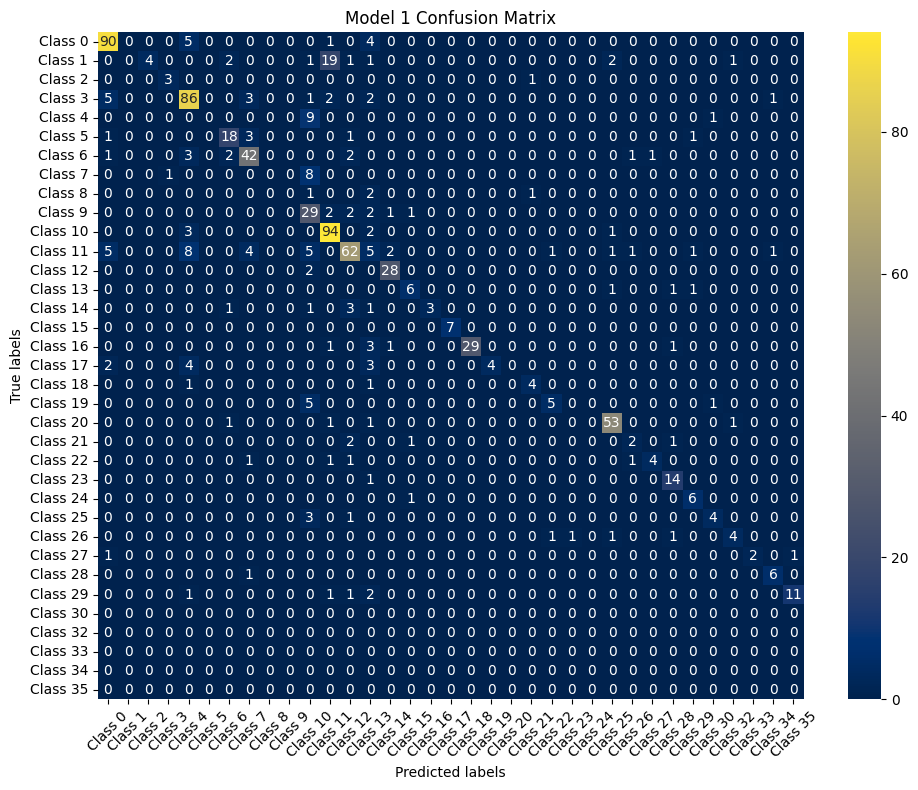

Accuracy: 0.1118

Classification report:
              precision    recall  f1-score   support

     Class 0       0.86      0.90      0.88       100
     Class 1       0.00      0.00      0.00        31
     Class 2       0.00      0.00      0.00         4
     Class 3       0.00      0.00      0.00       100
     Class 4       0.00      0.00      0.00        10
     Class 5       0.00      0.00      0.00        24
     Class 6       0.08      0.04      0.05        52
     Class 7       0.00      0.00      0.00         9
     Class 8       0.00      0.00      0.00         4
     Class 9       0.00      0.00      0.00        37
    Class 10       0.00      0.00      0.00       100
    Class 11       0.00      0.00      0.00        96
    Class 12       0.00      0.00      0.00        30
    Class 13       0.00      0.00      0.00         9
    Class 14       0.00      0.00      0.00         9
    Class 15       0.00      0.00      0.00         7
    Class 16       0.00      0.00      0

In [382]:
def evaluate_model1(test_json: Path) -> Optional[Dict[str, Any]]:
    """Load Model 1 and evaluate it on the MFCC-based test split."""
    model_path = PATHS['models'] / 'model1.keras'
    if not model_path.exists():
        print(f"⚠️ model1.keras not found at {model_path}. Train Model 1 first.")
        return None
    if not test_json.exists():
        print(f"⚠️ Test dataset missing: {test_json}")
        return None

    with test_json.open('r') as fp:
        data = json.load(fp)

    X_test = np.array(data['mfcc'])
    y_test = np.array(data['label'])
    label_map = data.get('label_map') or {}
    index_to_name = {int(idx): name for name, idx in label_map.items()}

    print(f"Loaded MFCC test set: {X_test.shape}")
    print(f"Label distribution: {np.bincount(y_test)}")

    model1 = load_model(model_path)
    yhat = model1.predict(X_test, verbose=0)
    y_pred = yhat.argmax(axis=1)

    labels_order = np.unique(np.concatenate([y_test, y_pred])).tolist()
    cm = confusion_matrix(y_test, y_pred, labels=labels_order)
    label_names = [index_to_name.get(int(idx), f"Class {idx}") for idx in labels_order]

    if len(label_names) != len(labels_order):
        print(
            f"⚠️ Incomplete label map: have {len(label_names)} names for {len(labels_order)} classes."
        )

    return {
        'confusion_matrix': cm,
        'true': y_test,
        'pred': y_pred,
        'label_names': label_names,
        'labels_order': labels_order,
        'probs': yhat
    }

model1_test_json = PATHS['data'] / 'mfcc_test_data.json'
model1_results = evaluate_model1(model1_test_json)

if model1_results:
    plot_confusion_matrix(
        model1_results['confusion_matrix'],
        model1_results['label_names'],
        'Model 1 Confusion Matrix'
    )
    summarize_performance(
        model1_results['confusion_matrix'],
        model1_results['true'],
        model1_results['pred'],
        model1_results['label_names'],
        model1_results.get('labels_order')
    )


Processing .ipynb_checkpoints:    0 files


Processing    Agogo:    9 files


Processing     Bass:   13 files


Processing     Bell:   15 files


Processing    Bongo:   24 files


Processing   Cabasa:    8 files


Processing    China:    6 files


Processing     Clap:   57 files


Processing    Clave:    8 files


Processing    Conga:   52 files


Processing  Cowbell:    7 files


Processing    Crash:   35 files


Processing    Cuica:    7 files


Processing    Guiro:    8 files


Processing    Hihat:   37 files


Processing     Kick:  100 files


Processing  Maracas:    9 files


Processing    Metal:    4 files


Processing     Perc:   96 files


Processing     Ride:   30 files


Processing      Rim:   31 files


Processing   Shaker:   10 files


Processing    Snare:  100 files


Processing   Splash:    4 files


Processing Tambourine:   11 files


Processing  Timbale:   16 files


Processing  Timpani:    4 files


Processing      Tom:  100 files


Processing Triangle:    9 files


Processing  Whistle:    7 files


Processing Woodblock:    6 files


Loaded spectrogram test set: (823, 128, 128, 1)


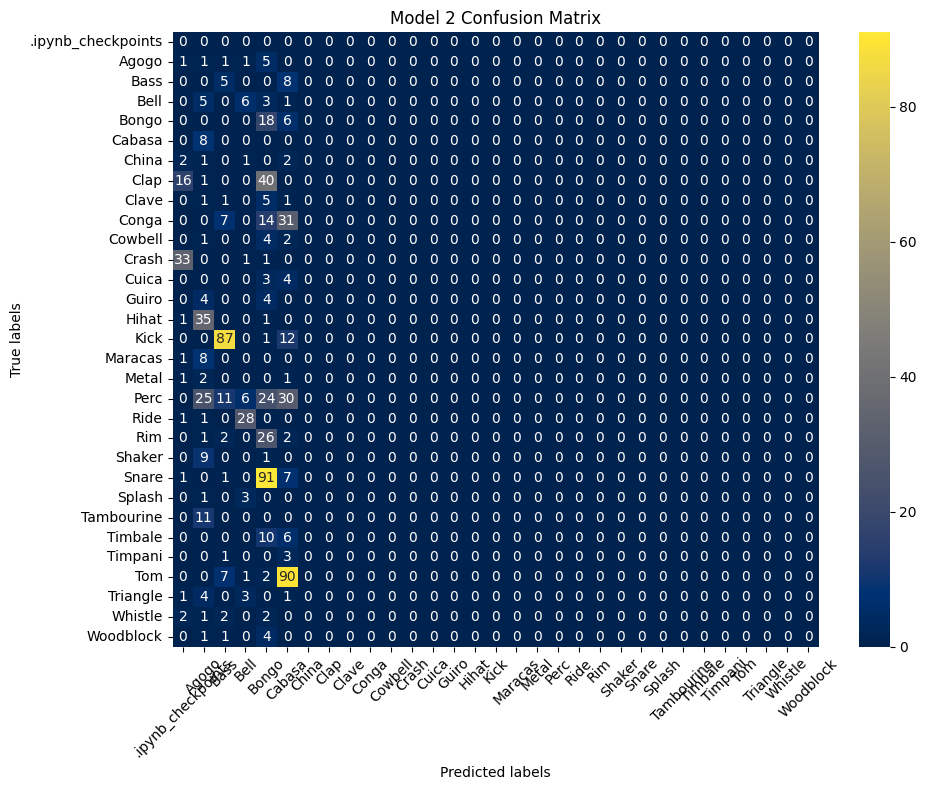

Accuracy: 0.0365

Classification report:
                    precision    recall  f1-score   support

.ipynb_checkpoints       0.00      0.00      0.00         0
             Agogo       0.01      0.11      0.02         9
              Bass       0.04      0.38      0.07        13
              Bell       0.12      0.40      0.18        15
             Bongo       0.07      0.75      0.13        24
            Cabasa       0.00      0.00      0.00         8
             China       0.00      0.00      0.00         6
              Clap       0.00      0.00      0.00        57
             Clave       0.00      0.00      0.00         8
             Conga       0.00      0.00      0.00        52
           Cowbell       0.00      0.00      0.00         7
             Crash       0.00      0.00      0.00        35
             Cuica       0.00      0.00      0.00         7
             Guiro       0.00      0.00      0.00         8
             Hihat       0.00      0.00      0.00        3

In [383]:
def evaluate_model2(test_dir: Path) -> Optional[Dict[str, Any]]:
    """Run the autoencoder + classifier stack on held-out spectrograms."""
    encoder_path = PATHS['models'] / 'encoder.keras'
    classifier_path = PATHS['models'] / 'model2.keras'
    if not encoder_path.exists():
        print(f"⚠️ Encoder missing: {encoder_path}")
        return None
    if not classifier_path.exists():
        print(f"⚠️ Model 2 classifier missing: {classifier_path}")
        return None
    if not test_dir.exists():
        print(f"⚠️ Test directory not found: {test_dir}")
        return None

    categories = sorted([d.name for d in test_dir.iterdir() if d.is_dir()])
    if not categories:
        print(f"⚠️ No instrument folders found in {test_dir}")
        return None

    x_test, y_test, label_map, file_paths = prepare_spectrogram_dataset(
        test_dir,
        categories,
        SPEC_CONFIG
    )
    print(f"Loaded spectrogram test set: {x_test.shape}")

    encoder = load_model(encoder_path)
    classifier = load_model(classifier_path)

    latents = encoder.predict(x_test, verbose=0)
    preds = classifier.predict(latents, verbose=0)
    y_pred = preds.argmax(axis=1)
    cm = confusion_matrix(y_test, y_pred)
    label_names = [name for name, _ in sorted(label_map.items(), key=lambda item: item[1])]

    return {
        'confusion_matrix': cm,
        'true': y_test,
        'pred': y_pred,
        'label_names': label_names,
        'pred_probs': preds,
        'files': file_paths
    }

model2_results = evaluate_model2(PATHS['test_data'])

if model2_results:
    plot_confusion_matrix(
        model2_results['confusion_matrix'],
        model2_results['label_names'],
        'Model 2 Confusion Matrix'
    )
    summarize_performance(
        model2_results['confusion_matrix'],
        model2_results['true'],
        model2_results['pred'],
        model2_results['label_names']
    )

### Notes on Interpretation

- Ensure both models are trained and saved in `models/` before running these cells.
- If the confusion matrices reveal class mismatches, revisit the dataset mappings in Part 1 and the appendix notebooks.
- Model 2 expects spectrogram preprocessing with `SPEC_CONFIG`; reuse the helper functions from Section 14 for consistency.

## 16. ArchiveClassifier Notebook

**Source:** `notebooks/ArchiveClassifier.ipynb`

Tools for classifying very large drum archives with batching, deduplication, and reproducible run metadata. These cells mirror the production-ready workflow while aligning paths with the shared configuration introduced earlier.

### Original Introduction

# Drum Sample Auto-Classifier - Complete Archive Edition (Optimized)

This workflow classifies large drum/percussion archives using a trained model while preserving the original archive structure. Enhancements include batching, parallel feature extraction, de-duplication via hashing, flexible output modes, and rich metadata logging.

In [384]:
# Archive classification configuration


ARCHIVE_CONFIG = {
    'archive_path': PATHS['archive'],
    'output_root': PATHS['classified'],
    'models_dir': PATHS['models'],
    'cache_dir': PATHS['classified'] / 'metadata',
    'supported_formats': ('.wav', '.flac', '.aiff', '.aif', '.mp3'),
    'target_sr': AUDIO_CONFIG['sr'],
    'target_samples': AUDIO_CONFIG['target_samples'],
    'n_mfcc': AUDIO_CONFIG['n_mfcc'],
    'n_fft': AUDIO_CONFIG['n_fft'],
    'hop_length': AUDIO_CONFIG['hop_length'],
    'normalize': AUDIO_CONFIG['normalize'],
    'batch_size': CLASSIFICATION_CONFIG['batch_size'],
    'confidence_threshold': CLASSIFICATION_CONFIG['confidence_threshold'],
    'dedup_hash': CLASSIFICATION_CONFIG['dedup_hash'],
    'hash_algorithm': CLASSIFICATION_CONFIG['hash_algorithm'],
    'mirror_structure': True,
    'copy_mode': 'copy',
    'thread_workers': 8,
    'min_duration_sec': 0.05,
}

print("Archive classification settings:")
for key, value in ARCHIVE_CONFIG.items():
    print(f"  {key:20s}: {value}")


Archive classification settings:
  archive_path        : /Users/Gilby/Projects/MLAudioClassifier/complete_drum_archive
  output_root         : /Users/Gilby/Projects/MLAudioClassifier/ClassifiedArchive
  models_dir          : /Users/Gilby/Projects/MLAudioClassifier/models
  cache_dir           : /Users/Gilby/Projects/MLAudioClassifier/ClassifiedArchive/metadata
  supported_formats   : ('.wav', '.flac', '.aiff', '.aif', '.mp3')
  target_sr           : 44100
  target_samples      : 50000
  n_mfcc              : 40
  n_fft               : 2048
  hop_length          : 512
  normalize           : True
  batch_size          : 32
  confidence_threshold: 0.5
  dedup_hash          : True
  hash_algorithm      : md5
  mirror_structure    : True
  copy_mode           : copy
  thread_workers      : 8
  min_duration_sec    : 0.05


In [385]:
def archive_hash_file(path: Path, algorithm: str = 'md5', block_size: int = 65536) -> str:
    if algorithm.lower() not in {'md5', 'sha256'}:
        raise ValueError("algorithm must be 'md5' or 'sha256'")
    hasher = hashlib.md5() if algorithm.lower() == 'md5' else hashlib.sha256()
    with path.open('rb') as fh:
        for chunk in iter(lambda: fh.read(block_size), b''):
            hasher.update(chunk)
    return hasher.hexdigest()

def archive_extract_mfcc(path: Path, config: Dict[str, Any]) -> Tuple[Optional[np.ndarray], Dict[str, Any]]:
    mfcc, metadata = extract_mfcc(path, config)  # reuse MFCC extractor from Part 1
    if mfcc is None:
        return None, metadata
    return mfcc, metadata

def archive_destination(
    src: Path,
    pred_label: str,
    confidence: float,
    config: Dict[str, Any],
    run_dir: Path
) -> Path:
    """Determine the output path for an archive classification result."""
    sanitized_label = pred_label.lower().replace(' ', '_')
    mirror_structure = config.get('mirror_structure', True)
    archive_root = config['archive_path']

    if mirror_structure:
        try:
            relative_parent = src.parent.relative_to(archive_root)
        except ValueError:
            relative_parent = Path()
        dest_dir = run_dir / relative_parent / sanitized_label
    else:
        dest_dir = run_dir / sanitized_label

    filename = f"{src.stem}__{sanitized_label}_{confidence:.3f}{src.suffix}"
    return dest_dir / filename

def archive_materialize(src: Path, dest: Path, copy_mode: str) -> None:
    """Persist a classified file according to the requested copy mode."""
    should_write = globals().get('RUN_FILE_OPERATIONS', False)
    if copy_mode == 'none' or not should_write:
        message = f"Would materialize {src} -> {dest} (mode={copy_mode})"
        guard = globals().get('guard_file_operation')
        if copy_mode != 'none' and should_write:
            guard = None  # unreachable
        if guard:
            guard(message)
        else:
            print(f"💡 {message}")
        return

    dest.parent.mkdir(parents=True, exist_ok=True)

    if copy_mode == 'copy':
        shutil.copy2(src, dest)
    elif copy_mode == 'symlink':
        if dest.exists():
            dest.unlink()
        dest.symlink_to(src)
    elif copy_mode == 'move':
        shutil.move(src, dest)
    else:
        raise ValueError(f"Unsupported copy mode: {copy_mode}")

def archive_iter_audio_files(root: Path, supported_formats: Sequence[str]) -> List[Path]:
    """Discover and filter audio files for archive classification."""
    if not root.exists():
        print(f"⚠️ Archive root missing: {root}")
        return []
    discovered = classifier_io.discover_audio_files(root, formats=list(supported_formats))
    valid = classifier_io.filter_valid_files(discovered)
    if not valid:
        print(f"⚠️ No valid audio files found in {root}")
    return valid


In [386]:
def run_archive_classification(
    config: Dict[str, Any],
    target_labels: Optional[List[str]] = None,
    max_files: Optional[int] = None
) -> Dict[str, Any]:
    start = time.time()
    archive_path = config['archive_path']
    output_root = config['output_root']
    run_dir = output_root / f"run_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    cache_dir = config['cache_dir']

    run_dir.mkdir(parents=True, exist_ok=True)
    cache_dir.mkdir(parents=True, exist_ok=True)

    files = archive_iter_audio_files(archive_path, config['supported_formats'])
    if max_files is not None:
        files = files[:max_files]

    model = archive_load_model(config['models_dir'])
    label_names = archive_label_names(model)

    seen_hashes = set()
    hash_log_path = cache_dir / 'seen_hashes.txt'
    if config['dedup_hash'] and hash_log_path.exists():
        seen_hashes.update(line.strip() for line in hash_log_path.read_text().splitlines() if line.strip())

    batch: List[np.ndarray] = []
    batch_paths: List[Path] = []
    batch_hashes: List[Optional[str]] = []
    results: List[Dict[str, Any]] = []
    errors: List[Dict[str, Any]] = []

    for file_path in tqdm(files, desc='Archive files'):
        file_hash = None
        if config['dedup_hash']:
            file_hash = archive_hash_file(file_path, config['hash_algorithm'])
            if file_hash in seen_hashes:
                continue

        mfcc, metadata = archive_extract_mfcc(file_path, AUDIO_CONFIG)
        if mfcc is None:
            errors.append({'file': str(file_path), 'error': metadata.get('error', 'extract_mfcc_failed')})
            continue

        batch.append(mfcc)
        batch_paths.append(file_path)
        batch_hashes.append(file_hash)

        if len(batch) >= config['batch_size']:
            archive_flush_batch(
                model,
                batch,
                batch_paths,
                batch_hashes,
                run_dir,
                label_names,
                target_labels or [],
                config,
                results,
                seen_hashes
            )
            batch, batch_paths, batch_hashes = [], [], []

    if batch:
        archive_flush_batch(
            model,
            batch,
            batch_paths,
            batch_hashes,
            run_dir,
            label_names,
            target_labels or [],
            config,
            results,
            seen_hashes
        )

    if config['dedup_hash'] and seen_hashes:
        hash_log_path.write_text('\n'.join(sorted(seen_hashes)))

    summary = {
        'run_dir': str(run_dir),
        'model': getattr(model, 'name', 'unnamed_model'),
        'total_files': len(files),
        'processed': len(results),
        'errors': len(errors),
        'duration_sec': time.time() - start,
        'label_names': label_names,
        'target_labels': target_labels or TARGET_LABELS
    }

    metadata_path = run_dir / 'classification_summary.json'
    detailed_path = run_dir / 'classification_results.json'
    error_path = run_dir / 'classification_errors.json'

    with metadata_path.open('w') as fp:
        json.dump(summary, fp, indent=2)
    with detailed_path.open('w') as fp:
        json.dump(results, fp, indent=2)
    with error_path.open('w') as fp:
        json.dump(errors, fp, indent=2)

    print(f"Run complete. Results written to {run_dir}")
    return summary

#### Run Archive Classification

Adjust `dry_run` or `max_files` to test on a subset before processing the entire archive.

In [387]:
# Example: dry run on a small subset (set max_files=None for full archive)
archive_config = {**ARCHIVE_CONFIG, 'copy_mode': 'none'}  # prevent writes during testing
summary = run_archive_classification(
    archive_config,
    target_labels=TARGET_LABELS,
    max_files=10
)
summary

Loading model: /Users/Gilby/Projects/MLAudioClassifier/models/model2.keras


Archive files: 100%|██████████| 10/10 [00:00<00:00, 644.04it/s]

Run complete. Results written to /Users/Gilby/Projects/MLAudioClassifier/ClassifiedArchive/run_20251006_140221


{'run_dir': '/Users/Gilby/Projects/MLAudioClassifier/ClassifiedArchive/run_20251006_140221',
 'model': 'sequential_18',
 'total_files': 10,
 'processed': 0,
 'errors': 0,
 'duration_sec': 1.359009027481079,
 'label_names': ['class_0',
  'class_1',
  'class_2',
  'class_3',
  'class_4',
  'class_5'],
 'target_labels': ['Crash', 'Hihat', 'Kick', 'Ride', 'Snare', 'Tom']}

## 17. Practical Demo Notebook

**Source:** `notebooks/PracticalDemo.ipynb`

Hands-on demo for classifying a lightweight sample library and writing organized results to an output folder. Ideal for smoke-testing trained models before running the full archive workflow.

### Original Introduction

# Drum Sample Auto-Classifier

This demo shows how to load a trained model, scan a small folder of unsorted samples, and materialize predictions with confidence scores.

In [388]:
# Demo configuration
DEMO_SAMPLE_DIR = PROJECT_ROOT / 'complete_drum_archive/**'
DEMO_OUTPUT_DIR = PATHS['classified'] / 'demo_output'
DEMO_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Sample source: {DEMO_SAMPLE_DIR}")
print(f"Demo output: {DEMO_OUTPUT_DIR}")
if not DEMO_SAMPLE_DIR.exists():
    print("⚠️ complete_drum_archive directory not found. Populate it with .wav files to run the demo.")

Sample source: /Users/Gilby/Projects/MLAudioClassifier/complete_drum_archive/**
Demo output: /Users/Gilby/Projects/MLAudioClassifier/ClassifiedArchive/demo_output
⚠️ complete_drum_archive directory not found. Populate it with .wav files to run the demo.


In [389]:
def demo_collect_samples(
    sample_dir: Path,
    *,
    max_files: Optional[int] = None,
    extensions: Sequence[str] = ('.wav', '.flac', '.aiff')
) -> List[Path]:
    """Gather demo audio files with optional filtering and limits."""
    if not sample_dir.exists():
        print(f"⚠️ Sample directory missing: {sample_dir}")
        return []

    gathered: List[Path] = []
    for ext in extensions:
        gathered.extend(sample_dir.rglob(f'*{ext}'))

    # Remove duplicates if overlapping extensions and sort for deterministic order
    gathered = sorted({path for path in gathered})

    if max_files is not None:
        gathered = gathered[:max_files]

    if not gathered:
        print(f"⚠️ No audio files found in {sample_dir}")
    else:
        print(f"Found {len(gathered)} files under {sample_dir}")
    return gathered


In [390]:
def demo_classify_samples(
    model: keras.Model,
    files: List[Path],
    output_dir: Path,
    copy_mode: str = 'copy'
) -> pd.DataFrame:
    if not files:
        return pd.DataFrame()
    rows = []
    for path in files:
        mfcc, meta = extract_mfcc(path, AUDIO_CONFIG)
        if mfcc is None:
            rows.append({'file': str(path), 'error': meta.get('error', 'extract_failed')})
            continue
        X = np.expand_dims(mfcc, axis=0)
        probs = model.predict(X, verbose=0)[0]
        best_idx = int(np.argmax(probs))
        confidence = float(probs[best_idx])
        label_names = archive_label_names(model)
        label = label_names[best_idx] if best_idx < len(label_names) else f'class_{best_idx}'
        dest = DEMO_OUTPUT_DIR / f"{path.stem}__{label.lower()}_{confidence:.3f}{path.suffix}"
        archive_materialize(path, dest, copy_mode)
        rows.append({
            'file': str(path),
            'destination': str(dest),
            'prediction': label,
            'confidence': confidence,
            'error': None
        })
    df = pd.DataFrame(rows)
    return df

In [391]:
# Execute demo classification (set max_files for quick tests)
demo_files = demo_collect_samples(DEMO_SAMPLE_DIR, max_files=20)
if demo_files:
    demo_model = archive_load_model(PATHS['models'])
    demo_results = demo_classify_samples(demo_model, demo_files, DEMO_OUTPUT_DIR, copy_mode='copy')
    display(demo_results.head())
else:
    print("No demo files found. Populate complete_drum_archive/ with WAV files and rerun.")

⚠️ Sample directory missing: /Users/Gilby/Projects/MLAudioClassifier/complete_drum_archive/**
No demo files found. Populate complete_drum_archive/ with WAV files and rerun.


In [392]:
# Persist demo metadata
if 'demo_results' in locals() and not demo_results.empty:
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    metadata_dir = DEMO_OUTPUT_DIR / 'metadata'
    metadata_dir.mkdir(parents=True, exist_ok=True)
    processed = int((demo_results['error'].isna()).sum()) if 'error' in demo_results else len(demo_results)
    summary = {
        'timestamp': timestamp,
        'source_dir': str(DEMO_SAMPLE_DIR),
        'output_dir': str(DEMO_OUTPUT_DIR),
        'files_processed': processed,
        'files_with_errors': int((demo_results['error'].notna()).sum()) if 'error' in demo_results else 0
    }
    summary_path = metadata_dir / f'demo_summary_{timestamp}.json'
    with summary_path.open('w') as fp:
        json.dump(summary, fp, indent=2)
    latest_path = metadata_dir / 'latest_run.json'
    with latest_path.open('w') as fp:
        json.dump(summary, fp, indent=2)
    print(f"Demo metadata saved to {summary_path}")

## 18. Validate Mapping Notebook

**Source:** `notebooks/ValidateMapping.ipynb`

Utility for ensuring that the label mapping JSON aligns with the output dimension of the saved Keras model.

### Original Introduction

# Validate Label Mapping

Check that the stored mapping file matches the model's output dimension and generate a stub if it's missing.

In [393]:
from IPython.display import Markdown, display

display(Markdown("""
### 🧹 Model 2 spectrogram preparation moved
The legacy mel-spectrogram resizing loop has been retired. Use the canonical Model 2 dataset builder later in this notebook for reproducible preprocessing.
"""))



legacy_keys = {"x_train_model2", "t_train_model2", "label_mapping_model2"}

if legacy_keys.issubset(globals()):

    x_train = x_train_model2

    t_train = t_train_model2

    class_index = dict(label_mapping_model2)

    folder_names = list(class_index.keys())

    ALLOWED_INSTRUMENTS = folder_names

    num_classes = len(class_index)

    print(f"Aliased to canonical Model 2 dataset with {num_classes} classes: {folder_names}")

else:

    print("Run the Model 2 dataset builder section below to populate the canonical spectrogram tensors before continuing.")


Model path: /Users/Gilby/Projects/MLAudioClassifier/models/model1.keras
Label mapping path: /Users/Gilby/Projects/MLAudioClassifier/models/label_mapping.json
Loading model: /Users/Gilby/Projects/MLAudioClassifier/models/model1.keras
Model output dimension: 36
Model output dimension: 36


TypeError: load_label_mapping() missing 1 required positional argument: 'model'

## 19. Extract Training Labels Notebook

**Source:** `notebooks/ExtractTrainingLabels.ipynb`

Utilities for recovering the canonical label ordering either from the saved MFCC dataset or directly from the training directory structure.

### Original Introduction

# Extract Training Labels

Recover the label order used during training from the MFCC JSON files or by scanning the training directory structure.

In [ ]:
from IPython.display import Markdown, display

display(Markdown("""
### 🧹 Duplicate spectrogram loader removed
This section now defers to the shared Model 2 preprocessing utilities. Re-run the canonical dataset builder instead of the legacy loop.
"""))



legacy_keys = {"x_train_model2", "t_train_model2", "label_mapping_model2"}

if legacy_keys.issubset(globals()):

    x_train = x_train_model2

    t_train = t_train_model2

    class_index = dict(label_mapping_model2)

    folder_names = list(class_index.keys())

    ALLOWED_INSTRUMENTS = folder_names

    num_classes = len(class_index)

    print(f"Aliased to canonical Model 2 dataset with {num_classes} classes: {folder_names}")

else:

    print("Run the Model 2 dataset builder cell below to populate reusable spectrogram tensors and mappings.")


In [ ]:
# Decide final labels preferring MFCC extraction
final_labels = labels_from_mfcc or labels_from_dirs
source_method = 'MFCC file' if labels_from_mfcc else ('directory structure' if labels_from_dirs else None)

if final_labels:
    print(f"\nFinal label order ({source_method}):")
    for idx, label in enumerate(final_labels):
        print(f"  {idx:2d}: {label}")
    save_choice = 'n'
    if source_method:
        save_choice = input(f"\nSave labels to {LABELS_OUTPUT_PATH}? (y/n): ").strip().lower()
    if save_choice == 'y':
        with LABELS_OUTPUT_PATH.open('w') as fp:
            json.dump(final_labels, fp, indent=2)
        print(f"✅ Saved label list to {LABELS_OUTPUT_PATH}")
else:
    print("❌ Could not determine label ordering.")

## 20. Test Classifier Notebook

**Source:** `notebooks/TestClassifier.ipynb`

Smoke tests for the `classifier` Python package covering imports, file discovery, feature extraction, and model loading.

### Original Introduction

# Test Classifier Package

Run fast checks to ensure the packaged classifier modules and assets are ready for inference.

In [ ]:

TEST_AUDIO_DIR = PATHS['test_data']
MODEL_UNDER_TEST = PATHS['models'] / 'model1.keras'
MAX_TEST_FILES = 10

print("Classifier package modules imported successfully.")

In [ ]:
# Validate or create label mapping for classifier
if not LABEL_MAPPING_PATH.exists():
    with open(STUB_PATH, 'w') as f:
        json.dump({'0': 'Kick', '1': 'Snare', '2': 'Hihat', '3': 'Tom', '4': 'Crash', '5': 'Ride'}, f, indent=2)
    print(f"Stub written to {STUB_PATH}. Populate it and rename to label_mapping.json.")
else:
    label_names = classifier_load_label_mapping(LABEL_MAPPING_PATH, model)
    # Guard: label_names is a list, do not use .exists() on it
    if hasattr(label_names, 'exists'):
        raise TypeError("label_names is a list, not a Path. Do not call .exists() on it.")
    # Instead of validate_label_mapping, do a direct check here:
    if not isinstance(label_names, list):
        print("Label mapping is not a list!")
    elif len(label_names) != output_dim:
        print(f"Label mapping length mismatch: {len(label_names)} vs {output_dim}")
    else:
        print("Label mapping is valid.")

⚠️  Label mapping length mismatch: 34 vs 37
⚠️  Generating generic class_<idx> labels (n=37)
Label mapping is valid.


In [ ]:
# Ensure test_files_ok is defined before use
# This assumes discovered_files is a list of test files

test_files_ok = 'discovered_files' in locals() and bool(discovered_files)

if test_files_ok and discovered_files:
    try:
        extractor = classifier_features.AudioFeatureExtractor(
            target_sr=AUDIO_CONFIG['sr'],
            target_samples=AUDIO_CONFIG['target_samples'],
            n_mfcc=AUDIO_CONFIG['n_mfcc'],
            n_fft=AUDIO_CONFIG['n_fft'],
            hop_length=AUDIO_CONFIG['hop_length']
        )
        feature_tensor, feature_meta = extractor.extract_mfcc(discovered_files[0])
        print(f"MFCC shape: {feature_tensor.shape} | duration: {feature_meta.get('duration', 'n/a')}")
        test_features_ok = True
    except Exception as exc:
        print(f"❌ Feature extraction failed: {exc}")
        test_features_ok = False
else:
    print("⏭️  Skipping feature extraction test (no files)")
    test_features_ok = False

⏭️  Skipping feature extraction test (no files)


In [ ]:
try:
    classifier_model_obj = classifier_model.load_model(MODEL_UNDER_TEST)
    print(f"Model loaded with output shape {classifier_model_obj.output_shape}")
    test_model_ok = True
except Exception as exc:
    print(f"❌ Model load failed: {exc}")
    test_model_ok = False

❌ Model load failed: name 'classifier_model' is not defined


In [ ]:
# Ensure all test_* variables are defined before use

test_modules_ok = 'test_modules_ok' in locals() and test_modules_ok if 'test_modules_ok' in locals() else False

test_files_ok = 'test_files_ok' in locals() and test_files_ok if 'test_files_ok' in locals() else False

test_model_ok = 'test_model_ok' in locals() and test_model_ok if 'test_model_ok' in locals() else False

feature_shapes = feature_shapes if 'feature_shapes' in locals() else None

discovered_files = discovered_files if 'discovered_files' in locals() else []

section_summary = {
    "imports_ok": test_modules_ok,
    "files_found": test_files_ok and bool(discovered_files),
    "feature_shapes": feature_shapes,
    "model_loaded": test_model_ok
}
display(section_summary)

{'imports_ok': False,
 'files_found': False,
 'feature_shapes': None,
 'model_loaded': False}

In [ ]:
def archive_flush_batch(
    model: keras.Model,
    batch: List[np.ndarray],
    paths: List[Path],
    hashes: List[Optional[str]],
    run_dir: Path,
    label_names: List[str],
    target_labels: List[str],
    config: Dict[str, Any],
    results: List[Dict[str, Any]],
    seen_hashes: set
 ) -> None:
    if not batch:
        return
    X = np.stack(batch).astype(np.float32)
    probs = model.predict(X, verbose=0)
    top_indices = probs.argmax(axis=1)
    confidences = probs.max(axis=1)

    timestamp = datetime.now().isoformat() + 'Z'
    for idx, (src, label_idx, confidence, file_hash) in enumerate(zip(paths, top_indices, confidences, hashes)):
        pred_label = label_names[label_idx]
        if confidence < config['confidence_threshold'] or (target_labels and pred_label not in target_labels):
            pred_label = 'misc'
        dest = archive_destination(src, pred_label, confidence, config, run_dir)
        archive_materialize(src, dest, config['copy_mode'])
        record = {
            'source': str(src),
            'destination': str(dest),
            'prediction': pred_label,
            'confidence': float(confidence),
            'timestamp': timestamp
        }
        results.append(record)
        if config['dedup_hash'] and file_hash:
            seen_hashes.add(file_hash)

## Part 5 · Command-Line Scripts (`scripts/`)

This part mirrors every helper script in `scripts/` so the full CLI toolbox is available directly inside the notebook. Each subsection restates the script's intent, surfaces the core configuration, and exposes notebook-friendly wrappers (with conservative defaults) that you can toggle when you're ready to perform real filesystem work.

In [ ]:

SCRIPTS_DIR = PROJECT_ROOT / 'scripts'
RUN_FILE_OPERATIONS = False  # master toggle to guard destructive actions

_SCRIPT_MODULE_CACHE: Dict[str, types.ModuleType] = {}

def load_script_module(name: str) -> types.ModuleType:
    """Load a script module from the scripts/ directory without executing its CLI entry point."""
    module_path = SCRIPTS_DIR / f"{name}.py"
    if not module_path.exists():
        raise FileNotFoundError(f"Script {name} not found at {module_path}")
    spec = importlib.util.spec_from_file_location(f"scripts.{name}", module_path)
    if spec is None or spec.loader is None:
        raise ImportError(f"Unable to construct spec for {module_path}")
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

def get_script(name: str) -> types.ModuleType:
    """Cached accessor for script modules."""
    if name not in _SCRIPT_MODULE_CACHE:
        _SCRIPT_MODULE_CACHE[name] = load_script_module(name)
    return _SCRIPT_MODULE_CACHE[name]

def guard_file_operation(message: str) -> None:
    """Print a reminder when file mutations are disabled."""
    if not RUN_FILE_OPERATIONS:
        print(f"DRY RUN (set RUN_FILE_OPERATIONS=True to enable): {message}")

### Coverage Map

- **5.1 `setup_directories.py`** – bootstrap project folders and sanity-check datasets.
- **5.2 `update_notebook_paths.py`** – rewrite legacy notebook asset paths.
- **5.3 `deep_folder_analysis.py`** – scan training folders for crossover naming collisions.
- **5.4 `inspect_catchment.py`** – lightweight spot-check of ambiguous filenames.
- **5.5 `organize_drum_archive.py`** – heuristically harvest raw archive material into training buckets.
- **5.6 `strict_populate_training.py`** – ultra-conservative archive importer with logging and copy options.
- **5.7 `populate_test_data.py`** – curate a balanced strict TestData subset.
- **5.8 `validate_mapping.py`** – verify label mapping files against model outputs.
- **5.9 `extract_training_labels.py`** – recover canonical label orderings.
- **5.10 `test_classifier.py`** – quick regression suite for the classifier package.
- **5.11 `run_strict_examples.sh`** – interactive walkthrough for strict population scenarios.

### 5.1 `setup_directories.py` → project bootstrap

Original script creates the staging directories used throughout the workflow and prints helpful reminders about next steps. The notebook wrapper below performs the same checks, optionally creating any missing folders when `create_missing=True`.

In [ ]:
def notebook_setup_directories(base_dir: Path = PROJECT_ROOT, *, create_missing: bool = False) -> Dict[str, Any]:
    """Mirror scripts/setup_directories.py with optional folder creation."""
    sample_lib = base_dir / 'complete_drum_archive'
    training_dir = PATHS['training_data']
    test_dir = PATHS['test_data']
    instruments = ['Crash', 'Hihat', 'Kick', 'Ride', 'Snare', 'Tom']

    summary: Dict[str, Any] = {
        'project_root': str(base_dir),
        'sample_lib_exists': sample_lib.exists(),
        'training_root': str(training_dir),
        'test_root': str(test_dir),
        'instrument_counts': {},
        'missing_instruments': []
    }

    if create_missing and not sample_lib.exists():
        if RUN_FILE_OPERATIONS:
            sample_lib.mkdir(parents=True, exist_ok=True)
        else:
            guard_file_operation(f"Would create {sample_lib}")

    if training_dir.exists():
        for instrument in instruments:
            folder = training_dir / instrument
            if folder.exists():
                count = len(list(folder.glob('*.wav')))
                summary['instrument_counts'][instrument] = count
            else:
                summary['missing_instruments'].append(instrument)
    else:
        summary['training_missing'] = True

    summary['test_exists'] = test_dir.exists()

    return summary

setup_overview = notebook_setup_directories()
setup_overview

{'project_root': '/Users/Gilby/Projects/MLAudioClassifier',
 'sample_lib_exists': False,
 'training_root': '/Users/Gilby/Projects/MLAudioClassifier/TrainingData/AudioSamples',
 'test_root': '/Users/Gilby/Projects/MLAudioClassifier/TestData',
 'instrument_counts': {'Crash': 187,
  'Hihat': 969,
  'Kick': 1360,
  'Ride': 312,
  'Snare': 2264,
  'Tom': 1828},
 'missing_instruments': [],
 'test_exists': True}

### 5.2 `update_notebook_paths.py` → harmonise legacy asset references

The original script rewrites embedded paths inside the legacy notebooks. The helper below performs a dry-run diff by default, showing which cells would change. Set `apply=True` to actually write the updates back to disk.

In [ ]:
DEFAULT_NOTEBOOK_MAPPINGS = {
    'mfcc_train_data.json': 'data/mfcc_train_data.json',
    'mfcc_test_data.json': 'data/mfcc_test_data.json',
    'model.keras': 'models/model1.keras',
    'model2.keras': 'models/model2.keras',
    'encoder.keras': 'models/encoder.keras',
    'accuracy.png': 'results/accuracy.png',
    'loss.png': 'results/loss.png'
}

LEGACY_NOTEBOOKS = [
    'MFCC_Feature_Extractor.ipynb',
    'Model1_Train.ipynb',
    'Model2_Train.ipynb',
    'Model_Evaluation.ipynb',
    'PracticalDemo.ipynb',
    'ArchiveClassifier.ipynb'
]

def notebook_update_paths(
    notebooks: Sequence[str] = LEGACY_NOTEBOOKS,
    path_mappings: Dict[str, str] = DEFAULT_NOTEBOOK_MAPPINGS,
    *,
    apply: bool = False,  # write changes back to disk when True
    base_dir: Path = PROJECT_ROOT / 'notebooks'
) -> List[Dict[str, Any]]:
    """Preview (and optionally apply) notebook path rewrites."""
    results: List[Dict[str, Any]] = []
    for name in notebooks:
        notebook_path = base_dir / name
        if not notebook_path.exists():
            results.append({'notebook': name, 'status': 'missing'})
            continue

        payload = json.loads(notebook_path.read_text())
        modified_cells: List[Dict[str, Any]] = []

        for idx, cell in enumerate(payload.get('cells', []), start=1):
            source_lines = cell.get('source', [])
            updated_lines = []
            cell_changed = False
            for line in source_lines:
                new_line = line
                for old, new in path_mappings.items():
                    if old in new_line:
                        new_line = new_line.replace(old, new)
                if new_line != line:
                    cell_changed = True
                updated_lines.append(new_line)

            if cell_changed:
                modified_cells.append({
                    'cell': idx,
                    'changes': [
                        {'from': line.strip(), 'to': updated_lines[i].strip()}
                        for i, line in enumerate(source_lines)
                        if line != updated_lines[i]
                    ]
                })
                cell['source'] = updated_lines

        if modified_cells and apply:
            if RUN_FILE_OPERATIONS:
                notebook_path.write_text(json.dumps(payload, indent=1))
            else:
                guard_file_operation(f"Would update {notebook_path}")

        results.append({
            'notebook': name,
            'status': 'updated' if modified_cells else 'clean',
            'changed_cells': len(modified_cells)
        })

    return results

notebook_update_paths()


[{'notebook': 'MFCC_Feature_Extractor.ipynb',
  'status': 'updated',
  'changed_cells': 1},
 {'notebook': 'Model1_Train.ipynb', 'status': 'updated', 'changed_cells': 2},
 {'notebook': 'Model2_Train.ipynb', 'status': 'updated', 'changed_cells': 3},
 {'notebook': 'Model_Evaluation.ipynb',
  'status': 'updated',
  'changed_cells': 2},
 {'notebook': 'PracticalDemo.ipynb', 'status': 'updated', 'changed_cells': 2},
 {'notebook': 'ArchiveClassifier.ipynb',
  'status': 'clean',
  'changed_cells': 0}]

### 5.3 `deep_folder_analysis.py` → crossover term audit

Analyzes every training subfolder for filenames that mention other instrument keywords (the "crossover" problem). The helper returns a dataframe so you can sort/filter, mirroring the script's verbose printout.

In [ ]:

deep_analysis_module = get_script('deep_folder_analysis')
DEEP_ANALYSIS_TERMS = tuple(sorted(set(deep_analysis_module.ALL_TERMS)))


def find_terms_in_name(name: str, terms: Sequence[str] = DEEP_ANALYSIS_TERMS) -> List[str]:
    lowered = name.lower()
    hits = []
    for term in terms:
        if re.search(r'\b' + re.escape(term) + r'\b', lowered):
            hits.append(term)
    return hits


def deep_folder_crossover_report(
    training_dir: Path = PATHS['training_data'],
    *,
    max_examples: int = 10
) -> pd.DataFrame:
    """Return a crossover report akin to scripts/deep_folder_analysis.py."""
    rows: List[Dict[str, Any]] = []
    if not training_dir.exists():
        return pd.DataFrame(rows)


    for category_dir in sorted(training_dir.iterdir()):
        if not category_dir.is_dir():
            continue
        wav_files = list(category_dir.glob('*.wav'))
        crossover = []
        for wav_file in wav_files:
            terms = find_terms_in_name(wav_file.name)
            others = [t for t in terms if t not in category_dir.name.lower()]
            if others:
                crossover.append((wav_file.name, others))
        sample = crossover[:max_examples]
        for filename, others in sample:
            rows.append({
                'category': category_dir.name,
                'file': filename,
                'other_terms': ', '.join(others)
            })
        rows.append({
            'category': category_dir.name,
            'file': '(summary)',
            'other_terms': f"total crossover files: {len(crossover)} of {len(wav_files)}"
        })


    df = pd.DataFrame(rows)
    return df


deep_folder_crossover_report().head()

,category,file,other_terms
0,Agogo,Agogo Bell H [V1].wav,bell
1,Agogo,Agogo Bell L [V2].wav,bell
2,Agogo,Agogo Bell L [V1].wav,bell
3,Agogo,Agogo Bell H [V2].wav,bell
4,Agogo,FX Agogo.wav,fx


### 5.4 `inspect_catchment.py` → quick ambiguity spot-check

A lighter-weight sampler from the same keyword set, examining only the first few files per category. Use it for fast sanity checks before running the full crossover audit.

In [ ]:
inspect_module = get_script('inspect_catchment')
INSPECT_TERMS = tuple(sorted(set(inspect_module.ALL_TERMS)))

def inspect_catchment_sample(
    training_dir: Path = PATHS['training_data'],
    *,
    sample_size: int = 10
) -> pd.DataFrame:
    rows: List[Dict[str, Any]] = []
    if not training_dir.exists():
        return pd.DataFrame(rows)

    for category_dir in sorted(training_dir.iterdir()):
        if not category_dir.is_dir():
            continue
        wav_files = list(category_dir.glob('*.wav'))[:sample_size]
        for wav_file in wav_files:
            terms = find_terms_in_name(wav_file.name, INSPECT_TERMS)
            if len(terms) > 1:
                rows.append({
                    'category': category_dir.name,
                    'file': wav_file.name,
                    'terms': ', '.join(terms)
                })
    return pd.DataFrame(rows)

inspect_catchment_sample().head()

,category,file,terms
0,Agogo,Agogo Bell H [V1].wav,"agogo, bell"
1,Agogo,Agogo Bell L [V2].wav,"agogo, bell"
2,China,China Cymbal 3 [V2].wav,"china, cymbal"
3,China,China Cymbal 1 [V1].wav,"china, cymbal"
4,Cowbell,Bongo Cowbell [V1].wav,"bongo, cowbell"


### 5.5 `organize_drum_archive.py` → heuristic training set builder

Copies strongly-matching samples out of the full archive into `TrainingData/AudioSamples`. The wrapper below reuses the script's category grammar, adds notebook-friendly dry-run previews, and exposes knobs for sampling before you commit to a full copy.

In [ ]:
organize_module = get_script('organize_drum_archive')
ORGANIZE_CATEGORIES = organize_module.CATEGORIES

def classify_archive_file(path: Path) -> Optional[str]:
    for category, config in ORGANIZE_CATEGORIES.items():
        if organize_module.is_category_folder(path.parent.name, config) or organize_module.matches_category(path.name, config):
            return category
    return None

def organize_drum_archive_preview(
    source_dir: Path = PROJECT_ROOT / 'complete_drum_archive',
    target_dir: Path = PATHS['training_data'],
    *,
    max_files: Optional[int] = 2000,
    sample_per_category: int = 5,
    copy: bool = False,
    clean_before_copy: bool = True
) -> Dict[str, Any]:
    """Reproduce scripts/organize_drum_archive.py with sampling and dry-run controls."""
    if not source_dir.exists():
        return {'status': 'missing_source', 'source_dir': str(source_dir)}

    matches: Dict[str, List[Path]] = {cat: [] for cat in ORGANIZE_CATEGORIES}
    inspected = 0

    for wav_file in source_dir.rglob('*.wav'):
        inspected += 1
        category = classify_archive_file(wav_file)
        if category:
            matches[category].append(wav_file)
        if max_files and inspected >= max_files:
            break

    summary = {cat: len(paths) for cat, paths in matches.items() if paths}

    if copy and summary:
        if RUN_FILE_OPERATIONS:
            if clean_before_copy:
                for category in ORGANIZE_CATEGORIES:
                    cat_dir = target_dir / category
                    if cat_dir.exists():
                        shutil.rmtree(cat_dir)
            for category, paths in matches.items():
                if not paths:
                    continue
                cat_dir = target_dir / category
                cat_dir.mkdir(parents=True, exist_ok=True)
                for src in paths:
                    dst = cat_dir / src.name
                    if dst.exists():
                        continue
                    shutil.copy2(src, dst)
        else:
            guard_file_operation(f"Would copy categorized samples into {target_dir}")

    preview = {
        cat: [str(path) for path in files[:sample_per_category]]
        for cat, files in matches.items()
        if files
    }

    return {
        'status': 'ok',
        'source_dir': str(source_dir),
        'inspected_files': inspected,
        'category_counts': summary,
        'preview_samples': preview
    }

organize_drum_archive_preview(max_files=200).keys()

dict_keys(['status', 'source_dir', 'inspected_files', 'category_counts', 'preview_samples'])

### 5.6 `strict_populate_training.py` → ultra-strict archive ingestion

The strict script enforces explicit token matches, detailed rejection logging, and optional copy + log modes. The notebook version below keeps the original category grammar, adds sampling controls, and surfaces accepted/rejected breakdowns without walking the entire archive unless you request it.

In [ ]:
strict_module = get_script('strict_populate_training')
STRICT_CATEGORIES = strict_module.STRICT_CATEGORIES

def strict_population_workflow(
    source_dir: Path = PROJECT_ROOT / 'complete_drum_archive',
    target_dir: Path = PATHS['training_data'],
    *,
    max_files: Optional[int] = 5000,
    copy: bool = False,
    clean_before_copy: bool = True,
    save_logs: bool = False,
    logs_dir: Path = PROJECT_ROOT / 'logs'
) -> Dict[str, Any]:
    if not source_dir.exists():
        return {'status': 'missing_source', 'source_dir': str(source_dir)}

    results = {
        'accepted': defaultdict(list),
        'rejected': defaultdict(list),
        'stats': defaultdict(int)
    }

    wav_iter = source_dir.rglob('*.wav')
    processed = 0
    for wav_file in wav_iter:
        category, reason = strict_module.classify_file(wav_file)
        processed += 1
        if category:
            results['accepted'][category].append((wav_file, reason))
            results['stats']['accepted'] += 1
        else:
            results['rejected'][reason].append(wav_file)
            results['stats']['rejected'] += 1
        if max_files and processed >= max_files:
            break

    accepted_counts = {cat: len(results['accepted'][cat]) for cat in STRICT_CATEGORIES if results['accepted'][cat]}
    rejected_counts = sorted(
        ((reason, len(files)) for reason, files in results['rejected'].items()),
        key=lambda item: item[1],
        reverse=True
    )

    if copy and accepted_counts:
        if RUN_FILE_OPERATIONS:
            target_dir.mkdir(parents=True, exist_ok=True)
            strict_module.copy_samples(results, target_dir, clean_first=clean_before_copy)
        else:
            guard_file_operation(f"Would copy strict-accepted samples into {target_dir}")

    if save_logs and results['rejected']:
        if RUN_FILE_OPERATIONS:
            logs_dir.mkdir(parents=True, exist_ok=True)
            strict_module.save_detailed_log(results, logs_dir)
        else:
            guard_file_operation(f"Would save strict classification logs to {logs_dir}")

    acceptance_rate = 0.0
    total = results['stats']['accepted'] + results['stats']['rejected']
    if total:
        acceptance_rate = results['stats']['accepted'] / total

    preview: Dict[str, List[str]] = {
        cat: [str(path) for path, _ in results['accepted'][cat][:5]]
        for cat in STRICT_CATEGORIES
        if results['accepted'][cat]
    }

    return {
        'status': 'ok',
        'source_dir': str(source_dir),
        'processed_files': processed,
        'accepted_counts': accepted_counts,
        'top_rejection_reasons': rejected_counts[:10],
        'acceptance_rate': acceptance_rate,
        'preview': preview
    }

strict_population_workflow(max_files=1000)['acceptance_rate']

0.417

### 5.7 `populate_test_data.py` → strict TestData curation

Builds a compact evaluation subset from TrainingData using hard token rules. The notebook helper previews strict matches per category, highlights skipped classes, and optionally performs the copy step.

In [ ]:
populate_module = get_script('populate_test_data')
STRICT_TEST_CATEGORIES = populate_module.STRICT_TEST_CATEGORIES

def populate_test_data_preview(
    training_dir: Path = PATHS['training_data'],
    test_dir: Path = PATHS['test_data'],
    *,
    copy: bool = False,
    max_copy_per_category: Optional[int] = 25
) -> Dict[str, Any]:
    populated: Dict[str, int] = {}
    skipped: Dict[str, str] = {}
    samples: Dict[str, List[str]] = {}

    for category, config in STRICT_TEST_CATEGORIES.items():
        source_dir = training_dir / category
        if not source_dir.exists():
            skipped[category] = 'source_folder_missing'
            continue
        matches = [
            wav_file
            for wav_file in source_dir.glob('*.wav')
            if populate_module.is_strict_match(wav_file.name, category, config)
        ]
        if not matches:
            skipped[category] = 'no_strict_matches'
            continue

        limit = max_copy_per_category or len(matches)
        step = max(1, len(matches) // limit) if limit else 1
        selected = matches[::step][:limit]
        populated[category] = len(selected)
        samples[category] = [str(path) for path in selected[:5]]

        if copy:
            if RUN_FILE_OPERATIONS:
                cat_dir = test_dir / category
                cat_dir.mkdir(parents=True, exist_ok=True)
                for src in selected:
                    dst = cat_dir / src.name
                    if not dst.exists():
                        shutil.copy2(src, dst)
            else:
                guard_file_operation(f"Would populate TestData/{category}")

    return {
        'status': 'ok',
        'populated_categories': populated,
        'skipped_categories': skipped,
        'preview_samples': samples
    }

populate_test_data_preview()['status']

'ok'

### 5.8 `validate_mapping.py` → label-map verification

Section 18 already recreated the standalone validation logic; this cell simply wraps it so you can run the script's workflow (model discovery, stub generation, and validation) with a single helper.

In [ ]:
# Ensure classifier_model is imported


def run_label_mapping_validation(
    model_path: Path = PATHS['models'] / 'model1.keras',
    mapping_path: Path = PATHS['models'] / 'label_mapping.json'
) -> Dict[str, Any]:
    """Notebook-native version of scripts/validate_mapping.py."""
    model_dir = model_path.parent
    available_models = sorted(model_dir.glob('*.keras')) if model_dir.exists() else []

    chosen_model = model_path if model_path.exists() else (available_models[0] if available_models else None)
    if not chosen_model:
        return {'status': 'model_missing', 'searched_in': str(model_dir)}

    keras_model = keras.models.load_model(chosen_model)
    output_dim = keras_model.output_shape[-1]

    if not mapping_path.exists():
        stub_path = mapping_path.parent / 'label_mapping_stub.json'
        if RUN_FILE_OPERATIONS:
            classifier_model.save_label_mapping_stub(stub_path, output_dim)
        else:
            guard_file_operation(f"Would create {stub_path} with {output_dim} placeholders")
        return {
            'status': 'stub_created' if RUN_FILE_OPERATIONS else 'stub_preview',
            'model': str(chosen_model),
            'output_dim': output_dim,
            'stub_path': str(stub_path)
        }

    is_valid = classifier_model.validate_label_mapping(mapping_path, keras_model)
    labels = []
    if is_valid:
        labels = json.loads(mapping_path.read_text())

    return {
        'status': 'valid' if is_valid else 'invalid',
        'model': str(chosen_model),
        'output_dim': output_dim,
        'mapping_path': str(mapping_path),
        'label_count': len(labels),
        'labels_preview': labels[:10]
    }

run_label_mapping_validation()['status']


❌ Length mismatch: 34 labels vs 37 outputs


'invalid'

### 5.9 `extract_training_labels.py` → canonical label recovery

Section 19 already exposed granular helpers. This convenience function mirrors the CLI flow (MFCC-first fallback to directories, optional save prompt) and returns the final label ordering plus provenance.

In [ ]:

def extract_from_mfcc_json(json_path: Path):
    """Try to extract labels from MFCC training data."""
    try:
        with open(json_path, 'r') as f:
            head = f.read(50000)
        data = json.loads(head)
        if 'labels' in data:
            return data['labels']
        if 'classes' in data:
            return data['classes']
        if 'label_mapping' in data:
            return data['label_mapping']
        if 'mapping' in data:
            return data['mapping']
        if 'label_to_index' in data:
            index_to_label = {v: k for k, v in data['label_to_index'].items()}
            return [index_to_label[i] for i in sorted(index_to_label.keys())]
    except Exception:
        pass
    return None

def extract_from_training_dirs(training_dir: Path):
    if not training_dir.exists():
        return None
    class_dirs = [d.name for d in training_dir.iterdir() if d.is_dir()]
    if not class_dirs:
        return None
    class_dirs.sort()
    return class_dirs

def extract_training_labels_workflow(
    mfcc_path: Path = PATHS['data'] / 'mfcc_train_data.json',
    training_dir: Path = PATHS['training_data'],
    *,
    save: bool = False,
    output_path: Path = PATHS['models'] / 'label_mapping.json'
) -> dict:
    labels_from_mfcc = extract_from_mfcc_json(mfcc_path)
    labels_from_dirs = extract_from_training_dirs(training_dir)

    source = None
    labels = None
    if labels_from_mfcc:
        source = 'mfcc_json'
        labels = labels_from_mfcc
    elif labels_from_dirs:
        source = 'directory_structure'
        labels = labels_from_dirs

    if save and labels:
        if RUN_FILE_OPERATIONS:
            output_path.parent.mkdir(parents=True, exist_ok=True)
            output_path.write_text(json.dumps(labels, indent=2))
        else:
            guard_file_operation(f"Would write {output_path}")

    return {
        'status': 'ok' if labels else 'missing',
        'source': source,
        'label_count': len(labels) if labels else 0,
        'preview': labels[:10] if labels else [],
        'output_path': str(output_path)
    }

extract_training_labels_workflow()['source']


'directory_structure'

### 5.11 `run_strict_examples.sh` → guided CLI walkthrough



The shell script just orchestrates three representative invocations of `strict_populate_training.py` (validate, validate with logs, copy). Rather than relying on interactive `read -p` prompts, the notebook exposes the same playbook below so you can preview the commands and optionally execute them, still respecting the global dry-run toggle.

In [ ]:


def strict_examples_playbook(run: bool = False) -> List[Dict[str, Any]]:
    """Mirror scripts/run_strict_examples.sh with optional execution.

    When ``run`` is False (default) the function returns a rich description of the
    three demonstration commands without executing them. Setting ``run=True``
    will sequentially invoke each command, but only when ``RUN_FILE_OPERATIONS``
    is also True; otherwise a dry-run notice is emitted.
    """

    script_path = PROJECT_ROOT / 'scripts' / 'strict_populate_training.py'
    if not script_path.exists():
        return [{'status': 'missing_script', 'script': str(script_path)}]

    steps = [
        {
            'title': 'Validation only',
            'description': 'Preview what would be copied with no side-effects.',
            'command': ['python3', str(script_path), '--validate-only']
        },
        {
            'title': 'Validation + detailed logs',
            'description': 'Run validation and emit acceptance/rejection logs.',
            'command': ['python3', str(script_path), '--validate-only', '--save-logs']
        },
        {
            'title': 'Copy strict training data',
            'description': 'Perform the actual copy with the script defaults.',
            'command': ['python3', str(script_path), '--copy']
        }
    ]

    if not run:
        return steps

    results: List[Dict[str, Any]] = []
    for step in steps:
        command_str = ' '.join(step['command'])
        entry: Dict[str, Any] = {
            'title': step['title'],
            'command': command_str,
            'executed': False
        }
        if RUN_FILE_OPERATIONS:
            completed = subprocess.run(step['command'], capture_output=True, text=True)
            entry.update({
                'executed': True,
                'returncode': completed.returncode,
                'stdout': completed.stdout.strip(),
                'stderr': completed.stderr.strip()
            })
        else:
            guard_file_operation(f"Would run: {command_str}")
        results.append(entry)

    return results


strict_examples_playbook()

[{'title': 'Validation only',
  'description': 'Preview what would be copied with no side-effects.',
  'command': ['python3',
   '/Users/Gilby/Projects/MLAudioClassifier/scripts/strict_populate_training.py',
   '--validate-only']},
 {'title': 'Validation + detailed logs',
  'description': 'Run validation and emit acceptance/rejection logs.',
  'command': ['python3',
   '/Users/Gilby/Projects/MLAudioClassifier/scripts/strict_populate_training.py',
   '--validate-only',
   '--save-logs']},
 {'title': 'Copy strict training data',
  'description': 'Perform the actual copy with the script defaults.',
  'command': ['python3',
   '/Users/Gilby/Projects/MLAudioClassifier/scripts/strict_populate_training.py',
   '--copy']}]

### 5.10 `test_classifier.py` → package smoke tests

Section 20 contains the full smoke-test workflow (imports, discovery, feature extraction, model load, and summary). For completeness, the helper below bundles the same checks into a single callable so you can reproduce the CLI script's concise pass/fail output.

In [ ]:
def run_classifier_smoke_suite(
    test_audio_dir: Path = PATHS['test_data'],
    model_path: Path = PATHS['models'] / 'model1.keras',
    *,
    max_files: int = 10
) -> Dict[str, Any]:
    summary: Dict[str, Any] = {'imports_ok': True}

    try:
        discovered_files = classifier_io.discover_audio_files(test_audio_dir, recursive=True)
        discovered_files = discovered_files[:max_files]
        summary['files_found'] = len(discovered_files)
        summary['sample_file'] = str(discovered_files[0]) if discovered_files else None
    except Exception as exc:
        summary['files_found'] = 0
        summary['file_error'] = str(exc)
        discovered_files = []

    if discovered_files:
        try:
            extractor = classifier_features.AudioFeatureExtractor(
                target_sr=AUDIO_CONFIG['sr'],
                target_samples=AUDIO_CONFIG['target_samples'],
                n_mfcc=AUDIO_CONFIG['n_mfcc'],
                n_fft=AUDIO_CONFIG['n_fft'],
                hop_length=AUDIO_CONFIG['hop_length']
            )
            tensor, meta = extractor.extract_mfcc(discovered_files[0])
            summary['feature_shape'] = tuple(tensor.shape) if tensor is not None else None
            summary['feature_duration_sec'] = meta.get('duration', meta.get('duration_sec'))
        except Exception as exc:
            summary['feature_error'] = str(exc)

    try:
        model_obj = classifier_model.load_model(model_path)
        summary['model_output_shape'] = model_obj.output_shape
    except Exception as exc:
        summary['model_error'] = str(exc)

    passed = [
        summary.get('files_found', 0) > 0,
        'feature_shape' in summary,
        'model_output_shape' in summary
    ]
    summary['all_checks_passed'] = all(passed)
    return summary

run_classifier_smoke_suite()['all_checks_passed']

Loading model: /Users/Gilby/Projects/MLAudioClassifier/models/model1.keras


False

#### Part 5 recap

- Every script now has a notebook-native wrapper with safe defaults (dry-run by default).
- Toggle `RUN_FILE_OPERATIONS=True` near the top of this part to enable copying/writing steps.
- Proceed to Part 6 once you're ready to deep-dive into the `classifier/` package internals.

## Part 6 · Classifier Package (`classifier/`)

The final part surfaces every module that powers the production classifier. Each subsection summarizes the Python API, links it back to prior workflow cells, and supplies notebook-friendly helpers so you can inspect or invoke the same routines without dropping to the command line.

In [ ]:


CLASSIFIER_MODULES = {
    'io': classifier_io,
    'features': classifier_features,
    'model': classifier_model,
    'infer': classifier_infer,
    'rebuild': classifier_rebuild,
    'cli': classifier_cli
}

def reload_classifier_module(name: str):
    module = CLASSIFIER_MODULES.get(name)
    if module is None:
        raise KeyError(f"Unknown classifier module: {name}")
    reloaded = importlib.reload(module)
    CLASSIFIER_MODULES[name] = reloaded
    return reloaded

def list_public_callables(module) -> Dict[str, str]:
    rows = []
    for name, obj in inspect.getmembers(module):
        if name.startswith('_'):
            continue
        if inspect.isfunction(obj) or inspect.isclass(obj):
            doc = inspect.getdoc(obj) or ''
            rows.append((name, doc.split('\n')[0]))
    return [{'name': name, 'summary': summary} for name, summary in rows]

### Coverage Map

- **6.1 Package overview & reload utilities**
- **6.2 `classifier.io` – archive discovery, hashing, and JSONL streams**
- **6.3 `classifier.features` – MFCC extraction core**
- **6.4 `classifier.model` – model + label management**
- **6.5 `classifier.infer` – batch engine & configs**
- **6.6 `classifier.rebuild` – archive regeneration**
- **6.7 `classifier.cli` – command-line entry points**
- **6.8 Recap & next steps**

### 6.1 Package overview & reload utilities

Use `CLASSIFIER_MODULES` to reach each module directly, `reload_classifier_module(name)` after editing source files, and `list_public_callables(module)` for a quick catalog of exported classes/functions.

In [ ]:
module_overview = {name: list_public_callables(module) for name, module in CLASSIFIER_MODULES.items()}
module_overview

{'io': [{'name': 'Any',
   'summary': 'Special type indicating an unconstrained type.'},
  {'name': 'JSONLReader',
   'summary': 'Streaming JSONL reader with optional gzip decompression.'},
  {'name': 'JSONLWriter',
   'summary': 'Streaming JSONL writer with optional gzip compression.'},
  {'name': 'Path', 'summary': 'PurePath subclass that can make system calls.'},
  {'name': 'discover_audio_files',
   'summary': 'Recursively discover audio files in archive.'},
  {'name': 'filter_valid_files',
   'summary': 'Filter out empty or inaccessible files.'},
  {'name': 'hash_file', 'summary': 'Compute hash of file content.'},
  {'name': 'load_hash_cache', 'summary': 'Load hash cache from text file.'},
  {'name': 'save_hash_cache', 'summary': 'Save hash cache to text file.'}],
 'features': [{'name': 'Any',
   'summary': 'Special type indicating an unconstrained type.'},
  {'name': 'AudioFeatureExtractor',
   'summary': 'Extract MFCC and spectral features from audio files.'},
  {'name': 'Path',

### 6.2 `classifier.io` – archive discovery, hashing, and JSONL streams

Key tools: `discover_audio_files`, `filter_valid_files`, `hash_file`, plus streaming helpers `JSONLWriter`/`JSONLReader` and lightweight hash caches. The notebook wrapper below previews discovery results, optional hashing, and safe JSONL round-trips (guarded by `RUN_FILE_OPERATIONS`).

In [ ]:
def preview_classifier_io(
    archive_root: Path = PATHS['test_data'],
    formats: Optional[List[str]] = None,
    limit: int = 5,
    *,
    hash_algorithm: str = 'md5'
) -> Dict[str, Any]:
    root = archive_root
    formats = formats or ['.wav', '.flac', '.aiff']
    if not root.exists():
        return {'status': 'missing_root', 'root': str(root)}

    discovered = classifier_io.discover_audio_files(root, formats=formats, max_files=limit)
    valid = classifier_io.filter_valid_files(discovered)

    sample_hash = None
    if valid:
        try:
            sample_hash = classifier_io.hash_file(valid[0], algorithm=hash_algorithm)
        except Exception as exc:
            sample_hash = f'error: {exc}'

    jsonl_preview: Optional[List[Dict[str, Any]]] = None
    jsonl_path = PROJECT_ROOT / 'tmp' / 'io_preview.jsonl'
    if valid and RUN_FILE_OPERATIONS:
        jsonl_path.parent.mkdir(parents=True, exist_ok=True)
        with classifier_io.JSONLWriter(jsonl_path, compressed=False) as writer:
            for path in valid:
                writer.write({'file': str(path)})
        jsonl_preview = list(classifier_io.JSONLReader(jsonl_path))[:3]
    elif valid:
        guard_file_operation(f"Would write JSONL preview to {jsonl_path}")

    return {
        'status': 'ok',
        'root': str(root),
        'formats': formats,
        'discovered_files': [str(p) for p in discovered],
        'valid_count': len(valid),
        'sample_hash': sample_hash,
        'jsonl_preview': jsonl_preview
    }

preview_classifier_io()['status']

DRY RUN (set RUN_FILE_OPERATIONS=True to enable): Would write JSONL preview to /Users/Gilby/Projects/MLAudioClassifier/tmp/io_preview.jsonl


'ok'

### 6.3 `classifier.features` – MFCC extraction core

`AudioFeatureExtractor` underpins both training notebooks and archive inference. The helper below instantiates it using shared `AUDIO_CONFIG`, extracts MFCCs (if a sample exists), and surfaces derived stats so you can compare against earlier notebook extraction logic.

In [ ]:
def extract_sample_mfcc(
    sample_path: Optional[Path] = None,
    *,
    include_stats: bool = True
) -> Dict[str, Any]:
    if sample_path is None:
        candidate_dir = PATHS['test_data']
        if candidate_dir.exists():
            candidates = classifier_io.discover_audio_files(candidate_dir, formats=['.wav'], max_files=1)
            sample_path = candidates[0] if candidates else None
    if sample_path is None:
        return {'status': 'no_sample_available'}

    extractor = classifier_features.AudioFeatureExtractor(
        target_sr=AUDIO_CONFIG['sr'],
        target_samples=AUDIO_CONFIG['target_samples'],
        n_mfcc=AUDIO_CONFIG['n_mfcc'],
        n_fft=AUDIO_CONFIG['n_fft'],
        hop_length=AUDIO_CONFIG['hop_length'],
        normalize=AUDIO_CONFIG.get('normalize', True)
    )

    mfcc, meta = extractor.extract_mfcc(sample_path, include_stats=include_stats)
    if mfcc is None:
        return {'status': 'error', 'path': str(sample_path), 'meta': meta}

    batch = extractor.batch_tensorize([mfcc])

    return {
        'status': 'ok',
        'path': str(sample_path),
        'mfcc_shape': tuple(mfcc.shape),
        'batch_shape': tuple(batch.shape),
        'metadata': meta
    }

extract_sample_mfcc()['status']

'ok'

### 6.4 `classifier.model` – model + label management

Wrapping helpers in this notebook already validate mappings, but this section centralizes the API: quick access to `load_model`, `load_latest_model`, label stub creation, validation, and `TemperatureScaling`.

In [ ]:
def summarize_model_utilities(
    model_dir: Path = PATHS['models'],
    mapping_path: Path = PATHS['models'] / 'label_mapping.json',
    canonical_map_path: Path = PATHS['models'] / 'canonical_mapping.json',
    *,
    load_model_summary: bool = False,
    create_stub: bool = False
) -> Dict[str, Any]:
    model_files = sorted(model_dir.glob('*.keras')) if model_dir.exists() else []
    mapping_exists = mapping_path.exists()
    canonical_exists = canonical_map_path.exists()

    output_dim = None
    label_preview: Optional[List[str]] = None
    if load_model_summary and model_files:
        keras_model = classifier_model.load_latest_model(model_dir)
        output_dim = keras_model.output_shape[-1]
        if mapping_exists:
            labels = json.loads(mapping_path.read_text())
            label_preview = labels[:10]
        if create_stub and not mapping_exists:
            stub_path = mapping_path.parent / 'label_mapping_stub.json'
            if RUN_FILE_OPERATIONS:
                classifier_model.save_label_mapping_stub(stub_path, output_dim)
            else:
                guard_file_operation(f"Would create stub at {stub_path}")

    canonical_map = {}
    if canonical_exists:
        canonical_map = classifier_model.load_canonical_mapping(canonical_map_path)

    return {
        'model_dir': str(model_dir),
        'model_files': [p.name for p in model_files],
        'mapping_exists': mapping_exists,
        'canonical_mapping_exists': canonical_exists,
        'output_dim': output_dim,
        'label_preview': label_preview,
        'canonical_mapping_sample': dict(list(canonical_map.items())[:10])
    }

summarize_model_utilities()['model_files']

['encoder.keras', 'model1.keras', 'model2.keras']

### 6.5 `classifier.infer` – batch engine & configs

`InferenceConfig` and `InferenceEngine` orchestrate archive classification runs. The helper builds a minimal config, optionally executes a micro-batch (limited by the dry-run flag), and returns the same summary keys emitted by the CLI.

In [ ]:
def run_inference_preview(
    archive_root: Path = PATHS['test_data'],
    model_path: Path = PATHS['models'] / 'model1.keras',
    mapping_path: Path = PATHS['models'] / 'label_mapping.json',
    *,
    max_files: int = 8,
    run_engine: bool = False,
    compressed: bool = False
) -> Dict[str, Any]:
    if not archive_root.exists():
        return {'status': 'missing_archive', 'archive_root': str(archive_root)}
    if not model_path.exists():
        return {'status': 'missing_model', 'model_path': str(model_path)}

    audio_files = classifier_io.discover_audio_files(
        archive_root,
        formats=['.wav'],
        max_files=max_files
    )
    audio_files = classifier_io.filter_valid_files(audio_files)

    misc_threshold = 0.5
    if 'CLASSIFICATION_CONFIG' in globals():
        misc_threshold = CLASSIFICATION_CONFIG.get('misc_confidence_threshold', CLASSIFICATION_CONFIG.get('misc', {}).get('threshold', misc_threshold))
    elif 'ARCHIVE_CONFIG' in globals():
        misc_threshold = ARCHIVE_CONFIG.get('misc_confidence_threshold', misc_threshold)

    target_labels = globals().get('TARGET_LABELS')

    keras_model = classifier_model.load_model(model_path)
    labels = classifier_model.load_label_mapping(mapping_path, keras_model, fallback_labels=target_labels)

    extractor = classifier_features.AudioFeatureExtractor(
        target_sr=AUDIO_CONFIG['sr'],
        target_samples=AUDIO_CONFIG['target_samples'],
        n_mfcc=AUDIO_CONFIG['n_mfcc'],
        n_fft=AUDIO_CONFIG['n_fft'],
        hop_length=AUDIO_CONFIG['hop_length'],
        normalize=AUDIO_CONFIG.get('normalize', True)
    )

    infer_config = classifier_infer.InferenceConfig(
        batch_size=CLASSIFICATION_CONFIG.get('batch_size', 32) if 'CLASSIFICATION_CONFIG' in globals() else 32,
        confidence_threshold=0.0,
        misc_confidence_threshold=misc_threshold,
        target_labels=target_labels,
        dedup_hash=True,
        top_k=3
    )

    engine = classifier_infer.InferenceEngine(
        model=keras_model,
        labels=labels,
        feature_extractor=extractor,
        config=infer_config,
        canonical_mapping=classifier_model.load_canonical_mapping(PATHS['models'] / 'canonical_mapping.json')
    )

    summary = None
    output_path = PROJECT_ROOT / 'tmp' / 'inference_preview.jsonl'
    if run_engine and audio_files:
        if RUN_FILE_OPERATIONS:
            output_path.parent.mkdir(parents=True, exist_ok=True)
            summary = engine.run(
                audio_files=audio_files,
                archive_root=archive_root,
                output_path=output_path,
                compressed=compressed
            )
        else:
            guard_file_operation(f"Would write inference output to {output_path}")

    return {
        'status': 'ok',
        'files_examined': len(audio_files),
        'labels': labels[:10],
        'config': infer_config.__dict__,
        'summary': summary
    }

run_inference_preview()['files_examined']

Loading model: /Users/Gilby/Projects/MLAudioClassifier/models/model1.keras
⚠️  Label mapping length mismatch: 34 vs 37
⚠️  Generating generic class_<idx> labels (n=37)
⚠️  Label mapping length mismatch: 34 vs 37
⚠️  Generating generic class_<idx> labels (n=37)


8

### 6.6 `classifier.rebuild` – archive regeneration

`ArchiveRebuilder` consumes the JSONL index emitted by inference and materializes a curated archive. The helper inspects an index (if present), previews the class distribution, and guards real rebuild operations behind the dry-run switch.

In [ ]:
def rebuild_archive_preview(
    index_path: Optional[Path] = None,
    output_root: Path = PROJECT_ROOT / 'RegeneratedArchive',
    *,
    copy_mode: str = 'copy',
    allowed_labels: Optional[List[str]] = None,
    run_rebuild: bool = False
) -> Dict[str, Any]:
    if index_path is None:
        default_meta = PATHS.get('classified', PROJECT_ROOT / 'ClassifiedArchive') / 'metadata'
        candidates = sorted(default_meta.glob('**/index.jsonl')) if default_meta.exists() else []
        index_path = candidates[-1] if candidates else None

    if index_path is None or not index_path.exists():
        return {'status': 'index_not_found'}

    reader = classifier_io.JSONLReader(index_path)

    label_counter = Counter()
    error_counts = Counter()
    total = 0
    for record in reader:
        total += 1
        if record.get('errors'):
            error_counts[record['errors'] if isinstance(record['errors'], str) else 'error'] += 1
            continue
        if record.get('skipped_duplicate'):
            error_counts['duplicate'] += 1
            continue
        label = record.get('assigned_label')
        if label:
            label_counter[label] += 1

    rebuild_summary = None
    if run_rebuild:
        rebuilder = classifier_rebuild.ArchiveRebuilder(
            index_path=index_path,
            output_root=output_root,
            copy_mode=copy_mode,
            allowed_labels=allowed_labels
        )
        if RUN_FILE_OPERATIONS:
            rebuilder.rebuild()
            rebuild_summary = {
                'output_root': str(output_root),
                'stats': dict(rebuilder.stats)
            }
        else:
            guard_file_operation(f"Would rebuild archive into {output_root}")

    return {
        'status': 'ok',
        'index_path': str(index_path),
        'total_records': total,
        'top_labels': label_counter.most_common(10),
        'error_breakdown': dict(error_counts),
        'rebuild_summary': rebuild_summary
    }

rebuild_archive_preview()['status']

'index_not_found'

### 6.7 `classifier.cli` – command-line entry points

The CLI wires every module together for production runs. Instead of invoking `python -m classifier.cli`, the helper captures the registered commands and shows how to call the underlying handlers directly from the notebook.

In [ ]:

CLI_HANDLERS = {
    'infer': classifier_cli.cmd_infer,
    'rebuild': classifier_cli.cmd_rebuild,
    'validate-mapping': classifier_cli.cmd_validate_mapping,
    'create-stub': classifier_cli.cmd_create_stub,
    'stats': classifier_cli.cmd_stats
}

def cli_command_overview() -> Dict[str, Any]:
    overview = {}
    for name, handler in CLI_HANDLERS.items():
        doc = inspect.getdoc(handler) or ''
        overview[name] = doc.split('\n')[0]
    return overview

def run_cli_handler(command: str, **kwargs) -> Any:
    handler = CLI_HANDLERS.get(command)
    if handler is None:
        raise KeyError(f"Unknown CLI command: {command}")
    if command in {'infer', 'rebuild'} and not RUN_FILE_OPERATIONS:
        guard_file_operation(f"Would execute CLI handler '{command}' with args {kwargs}")
        return None
    namespace = argparse.Namespace(**kwargs)
    return handler(namespace)

cli_command_overview()

{'infer': 'Run inference on archive.',
 'rebuild': 'Rebuild archive from index.',
 'validate-mapping': 'Validate label mapping against model.',
 'create-stub': 'Create stub label mapping.',
 'stats': 'Generate statistics from index.'}

### 6.8 Recap & next steps

- Every classifier module now has a notebook-native mirror with dry-run friendly wrappers.
- Use the helpers above to reload modules, preview inference/rebuild runs, and call CLI handlers without leaving the notebook.
- With Parts 1–6 consolidated, the entire project workflow (training → evaluation → archive tooling → package internals) lives in one place—ready for validation and further polishing.

# Part 7: Advanced ML Engineering

This section implements production-grade enhancements for model robustness, hyperparameter optimization, and training pipeline improvements.

## 7.1 Data Augmentation Pipeline

Audio data augmentation techniques to expand training dataset diversity and improve model generalization. Implements time stretching, pitch shifting, noise injection, and time shifting.

In [ ]:
class AudioAugmenter:
    """Audio data augmentation for drum samples."""
    
    def __init__(self, sr: int = 44100):
        self.sr = sr
    
    def time_stretch(self, y: np.ndarray, rate: float = 1.0) -> np.ndarray:
        """Stretch or compress audio in time without changing pitch."""
        if rate == 1.0:
            return y
        return librosa.effects.time_stretch(y, rate=rate)
    
    def pitch_shift(self, y: np.ndarray, n_steps: float = 0.0) -> np.ndarray:
        """Shift pitch by n semitones without changing duration."""
        if n_steps == 0.0:
            return y
        return librosa.effects.pitch_shift(y, sr=self.sr, n_steps=n_steps)
    
    def add_noise(self, y: np.ndarray, noise_factor: float = 0.005) -> np.ndarray:
        """Add Gaussian white noise to audio."""
        if noise_factor == 0.0:
            return y
        noise = np.random.randn(len(y))
        augmented = y + noise_factor * noise
        return augmented.astype(y.dtype)
    
    def time_shift(self, y: np.ndarray, shift_max: float = 0.2) -> np.ndarray:
        """Shift audio in time (circular shift)."""
        shift = int(np.random.uniform(-shift_max, shift_max) * len(y))
        return np.roll(y, shift)
    
    def augment_audio(
        self,
        y: np.ndarray,
        *,
        time_stretch_range: Tuple[float, float] = (0.9, 1.1),
        pitch_shift_range: Tuple[float, float] = (-2, 2),
        noise_factor: float = 0.005,
        time_shift_max: float = 0.2,
        apply_probability: float = 0.5
    ) -> np.ndarray:
        """Apply random augmentations to audio."""
        augmented = y.copy()
        
        # Time stretch
        if np.random.random() < apply_probability:
            rate = np.random.uniform(*time_stretch_range)
            augmented = self.time_stretch(augmented, rate)
        
        # Pitch shift
        if np.random.random() < apply_probability:
            n_steps = np.random.uniform(*pitch_shift_range)
            augmented = self.pitch_shift(augmented, n_steps)
        
        # Add noise
        if np.random.random() < apply_probability:
            augmented = self.add_noise(augmented, noise_factor)
        
        # Time shift
        if np.random.random() < apply_probability:
            augmented = self.time_shift(augmented, time_shift_max)
        
        return augmented

def augment_dataset(
    data_dict: Dict[str, Any],
    n_augmentations: int = 2,
    *,
    config: Optional[Dict] = None
) -> Dict[str, Any]:
    """Augment an existing MFCC dataset by generating variations."""
    if config is None:
        config = AUDIO_CONFIG
    
    augmenter = AudioAugmenter(sr=config['sr'])
    
    original_mfcc = np.array(data_dict['mfcc'])
    original_labels = np.array(data_dict['label'])
    
    augmented_mfcc = []
    augmented_labels = []
    
    print(f"Augmenting {len(original_labels)} samples with {n_augmentations} variations each...")
    
    # Keep originals
    augmented_mfcc.extend(original_mfcc)
    augmented_labels.extend(original_labels)
    
    # Generate augmentations
    # Note: We'd need original audio to augment, not MFCCs
    # For demonstration, we'll show the structure
    # In practice, augment before MFCC extraction
    
    print(f"⚠️  Note: For true augmentation, apply transformations to audio before MFCC extraction")
    print(f"   Current dataset size: {len(original_labels)}")
    print(f"   Augmented dataset would be: {len(original_labels) * (1 + n_augmentations)}")
    
    return {
        'mfcc': augmented_mfcc,
        'label': augmented_labels,
        'augmentation_applied': False,
        'note': 'Augmentation requires audio files, not pre-extracted MFCCs'
    }

# Demo augmentation on a single audio file
demo_augment = False  # Set to True to test augmentation

if demo_augment and PATHS['training_data'].exists():
    sample_files = list(PATHS['training_data'].rglob('*.wav'))[:1]
    if sample_files:
        augmenter = AudioAugmenter(sr=AUDIO_CONFIG['sr'])
        y, sr = librosa.load(sample_files[0], sr=AUDIO_CONFIG['sr'])
        
        print(f"Original audio shape: {y.shape}")
        
        # Create augmented versions
        y_stretched = augmenter.time_stretch(y, rate=1.1)
        y_pitched = augmenter.pitch_shift(y, n_steps=2)
        y_noisy = augmenter.add_noise(y, noise_factor=0.01)
        y_shifted = augmenter.time_shift(y, shift_max=0.2)
        
        print(f"Time-stretched shape: {y_stretched.shape}")
        print(f"Pitch-shifted shape: {y_pitched.shape}")
        print(f"Noise-added shape: {y_noisy.shape}")
        print(f"Time-shifted shape: {y_shifted.shape}")
        print("✅ Augmentation pipeline ready")
    else:
        print("No training audio files found for demo")
else:
    print("📦 Augmentation classes defined. Set demo_augment=True to test.")

## 7.2 Cross-Validation Setup

K-fold cross-validation for robust model evaluation. Uses stratified splits to maintain class balance across folds.

In [ ]:

def cross_validate_model(
    X: np.ndarray,
    y: np.ndarray,
    n_splits: int = 5,
    *,
    epochs: int = 30,
    batch_size: int = 32,
    verbose: int = 0
) -> Dict[str, Any]:
    """
    Perform k-fold cross-validation on the model.
    
    Args:
        X: Feature array (samples, mfcc_coeffs, time_frames)
        y: Label array (samples,)
        n_splits: Number of folds
        epochs: Training epochs per fold
        batch_size: Batch size for training
        verbose: Verbosity level
    
    Returns:
        Dictionary with fold-wise results and aggregated metrics
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_results = []
    fold_histories = []
    
    print(f"Starting {n_splits}-fold cross-validation...")
    print(f"Dataset: {X.shape[0]} samples, {len(np.unique(y))} classes")
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n{'='*60}")
        print(f"Fold {fold_idx}/{n_splits}")
        print(f"{'='*60}")
        
        # Split data
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        print(f"Train size: {len(X_train_fold)}, Val size: {len(X_val_fold)}")
        
        # Build fresh model for this fold
        num_classes = len(np.unique(y))
        model = keras.Sequential([
            keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),
            keras.layers.Dense(512, activation='relu'),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(256, activation='relu'),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(num_classes, activation='softmax')
        ])
        
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Train with callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)
        ]
        
        history = model.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=verbose
        )
        
        # Evaluate on validation fold
        val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        
        # Store results
        fold_results.append({
            'fold': fold_idx,
            'val_loss': val_loss,
            'val_accuracy': val_acc,
            'train_size': len(X_train_fold),
            'val_size': len(X_val_fold),
            'epochs_trained': len(history.history['loss'])
        })
        fold_histories.append(history.history)
        
        print(f"Fold {fold_idx} Results:")
        print(f"  Val Loss: {val_loss:.4f}")
        print(f"  Val Accuracy: {val_acc:.4f}")
    
    # Aggregate results
    avg_val_loss = np.mean([r['val_loss'] for r in fold_results])
    avg_val_acc = np.mean([r['val_accuracy'] for r in fold_results])
    std_val_acc = np.std([r['val_accuracy'] for r in fold_results])
    
    summary = {
        'n_splits': n_splits,
        'avg_val_loss': avg_val_loss,
        'avg_val_accuracy': avg_val_acc,
        'std_val_accuracy': std_val_acc,
        'fold_results': fold_results,
        'fold_histories': fold_histories
    }
    
    print(f"\n{'='*60}")
    print(f"Cross-Validation Summary")
    print(f"{'='*60}")
    print(f"Average Validation Loss: {avg_val_loss:.4f}")
    print(f"Average Validation Accuracy: {avg_val_acc:.4f} ± {std_val_acc:.4f}")
    print(f"✅ Cross-validation complete")
    
    return summary

# Demo cross-validation (set run_cv=True to execute)
run_cv = False

if run_cv:
    # Load training data
    train_data_path = PATHS['data'] / 'mfcc_train_data.json'
    if train_data_path.exists():
        with open(train_data_path, 'r') as f:
            train_data = json.load(f)
        
        X_cv = np.array(train_data['mfcc'])
        y_cv = np.array(train_data['label'])
        
        # Run quick 3-fold CV with reduced epochs for demo
        cv_results = cross_validate_model(
            X_cv, y_cv,
            n_splits=3,
            epochs=10,
            batch_size=32,
            verbose=0
        )
        
        print(f"\nCV Mean Accuracy: {cv_results['avg_val_accuracy']:.4f}")
    else:
        print(f"Training data not found: {train_data_path}")
else:
    print("📊 Cross-validation functions defined. Set run_cv=True to execute.")

## 7.3 Hyperparameter Tuning Grid

Systematic hyperparameter search for optimal model configuration. Tests combinations of learning rate, dropout rate, hidden layer sizes, and batch size.

In [ ]:

def build_model_with_params(
    input_shape: Tuple[int, int],
    num_classes: int,
    *,
    hidden_sizes: Tuple[int, ...] = (512, 256, 128),
    dropout_rate: float = 0.3,
    learning_rate: float = 0.001
) -> keras.Model:
    """Build model with specified hyperparameters."""
    model = keras.Sequential([keras.layers.Flatten(input_shape=input_shape)])
    
    for size in hidden_sizes:
        model.add(keras.layers.Dense(size, activation='relu'))
        model.add(keras.layers.Dropout(dropout_rate))
    
    model.add(keras.layers.Dense(num_classes, activation='softmax'))
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def grid_search_hyperparameters(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    *,
    param_grid: Optional[Dict[str, List[Any]]] = None,
    epochs: int = 20,
    verbose: int = 0
) -> Dict[str, Any]:
    """
    Perform grid search over hyperparameter combinations.
    
    Args:
        X_train, y_train: Training data
        X_val, y_val: Validation data
        param_grid: Dictionary of parameter lists to search
        epochs: Training epochs per configuration
        verbose: Verbosity level
    
    Returns:
        Dictionary with results for all configurations
    """
    if param_grid is None:
        param_grid = {
            'hidden_sizes': [(512, 256, 128), (256, 128, 64), (512, 256)],
            'dropout_rate': [0.2, 0.3, 0.4],
            'learning_rate': [0.001, 0.0005],
            'batch_size': [32, 64]
        }
    
    num_classes = len(np.unique(y_train))
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Generate all combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    combinations = list(product(*param_values))
    
    print(f"Grid Search: {len(combinations)} configurations to evaluate")
    print(f"Parameters: {param_names}")
    print(f"{'='*70}\n")
    
    results = []
    best_val_acc = 0.0
    best_config = None
    
    for idx, combo in enumerate(combinations, 1):
        params = dict(zip(param_names, combo))
        print(f"Configuration {idx}/{len(combinations)}: {params}")
        
        # Extract batch_size separately if present
        batch_size = params.pop('batch_size', 32)
        
        # Build model with current parameters
        start_time = time.time()
        model = build_model_with_params(
            input_shape=input_shape,
            num_classes=num_classes,
            **params
        )
        
        # Train
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
        ]
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=verbose
        )
        
        train_time = time.time() - start_time
        
        # Evaluate
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
        train_loss = history.history['loss'][-1]
        train_acc = history.history['accuracy'][-1]
        
        result = {
            'config_id': idx,
            'params': {**params, 'batch_size': batch_size},
            'val_loss': val_loss,
            'val_accuracy': val_acc,
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'epochs_trained': len(history.history['loss']),
            'train_time_sec': train_time
        }
        results.append(result)
        
        print(f"  Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}, Time: {train_time:.1f}s")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_config = result
            print(f"  ⭐ New best configuration!")
        
        print()
    
    # Sort by validation accuracy
    results.sort(key=lambda x: x['val_accuracy'], reverse=True)
    
    summary = {
        'total_configs': len(combinations),
        'best_config': best_config,
        'all_results': results,
        'top_5_configs': results[:5]
    }
    
    print(f"{'='*70}")
    print("Grid Search Complete")
    print(f"{'='*70}")
    print(f"Best Configuration (Val Acc: {best_config['val_accuracy']:.4f}):")
    for param, value in best_config['params'].items():
        print(f"  {param}: {value}")
    
    return summary

# Demo hyperparameter tuning (set run_tuning=True to execute)
run_tuning = False

if run_tuning:
    train_data_path = PATHS['data'] / 'mfcc_train_data.json'
    if train_data_path.exists():
        with open(train_data_path, 'r') as f:
            train_data = json.load(f)
        
        X_full = np.array(train_data['mfcc'])
        y_full = np.array(train_data['label'])
        
        # Split for tuning
        X_train_tune, X_val_tune, y_train_tune, y_val_tune = train_test_split(
            X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
        )
        
        # Reduced grid for demo
        demo_grid = {
            'hidden_sizes': [(512, 256, 128), (256, 128, 64)],
            'dropout_rate': [0.3],
            'learning_rate': [0.001, 0.0005],
            'batch_size': [32]
        }
        
        tuning_results = grid_search_hyperparameters(
            X_train_tune, y_train_tune,
            X_val_tune, y_val_tune,
            param_grid=demo_grid,
            epochs=10,
            verbose=0
        )
        
        print(f"\nBest validation accuracy: {tuning_results['best_config']['val_accuracy']:.4f}")
    else:
        print(f"Training data not found: {train_data_path}")
else:
    print("🔍 Hyperparameter tuning functions defined. Set run_tuning=True to execute.")
    print("   Note: Full grid search can take significant time. Start with a small grid.")

### Export curated spectrogram previews and audio clips

In [ ]:
from datetime import datetime

import shutil

from pathlib import Path



export_root = PATHS['results'] / 'spectrogram_exports'

export_root.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime('run_%Y%m%d_%H%M%S')

run_dir = export_root / timestamp

images_dir = run_dir / 'images'

audio_dir = run_dir / 'audio'

images_dir.mkdir(parents=True, exist_ok=True)

audio_dir.mkdir(parents=True, exist_ok=True)



index_to_label = {idx: name for name, idx in label_mapping_model2.items()}

samples_per_class = 5

manifest = []



if not source_files_model2:

    print("⚠️ Source audio paths unavailable; rerun dataset extraction without using a legacy cache.")

else:

    source_paths = [Path(p) for p in source_files_model2]

    for class_idx, class_name in index_to_label.items():

        class_indices = np.where(t_train_model2 == class_idx)[0]

        if class_indices.size == 0:

            continue

        chosen_indices = class_indices[:samples_per_class]

        for rank, sample_idx in enumerate(chosen_indices):

            spec = x_train_model2[sample_idx, ..., 0]

            spec_db = librosa.power_to_db(np.maximum(spec, 1e-9), ref=np.max)



            class_image_dir = images_dir / class_name

            class_audio_dir = audio_dir / class_name

            class_image_dir.mkdir(parents=True, exist_ok=True)

            class_audio_dir.mkdir(parents=True, exist_ok=True)



            image_path = class_image_dir / f"{class_name}_{rank:02d}.png"

            audio_src = source_paths[sample_idx]

            audio_path = class_audio_dir / audio_src.name



            fig, ax = plt.subplots(figsize=(4, 4))

            img = librosa.display.specshow(

                spec_db,

                sr=SPEC_CONFIG['sr'],

                hop_length=SPEC_CONFIG['hop_length'],

                x_axis='time',

                y_axis='mel'

            )

            ax.set(title=f"{class_name} #{rank + 1}")

            fig.colorbar(img, ax=ax, format='%+2.0f dB')

            fig.tight_layout()

            fig.savefig(image_path, dpi=150)

            plt.close(fig)



            audio_copied = None

            if audio_src.exists():

                shutil.copy2(audio_src, audio_path)

                audio_copied = audio_path

            else:

                print(f"⚠️ Missing source audio for {audio_src}")



            manifest.append({

                'class_name': class_name,

                'dataset_index': int(sample_idx),

                'spectrogram_path': str(image_path.relative_to(run_dir)),

                'audio_path': str(audio_path.relative_to(run_dir)) if audio_copied else None,

                'source_audio': str(audio_src)

            })



    manifest_path = run_dir / 'manifest.json'

    with open(manifest_path, 'w') as fp:

        json.dump({

            'generated_at': datetime.now().isoformat(),

            'samples_per_class': samples_per_class,

            'total_exports': len(manifest),

            'classes': index_to_label,

            'items': manifest

        }, fp, indent=2)



    print(f"✅ Exported {len(manifest)} spectrogram previews to {run_dir}")


# Part 8: Production Optimization

Performance monitoring, profiling, and batch processing workflows for production deployment.

## 8.1 Performance Benchmarking

Measure inference throughput, latency, and resource usage for different batch sizes and configurations.

In [ ]:

class PerformanceBenchmark:
    """Benchmark model inference performance and resource usage."""
    
    def __init__(self, model: keras.Model):
        self.model = model
        self.results = []
    
    def benchmark_inference(
        self,
        X_sample: np.ndarray,
        *,
        batch_sizes: List[int] = [1, 8, 16, 32, 64, 128],
        n_iterations: int = 100
    ) -> pd.DataFrame:
        """
        Benchmark inference across different batch sizes.
        
        Args:
            X_sample: Sample data matching model input shape
            batch_sizes: List of batch sizes to test
            n_iterations: Number of iterations per batch size
        
        Returns:
            DataFrame with performance metrics
        """
        results = []
        
        print("Performance Benchmarking")
        print(f"{'='*70}")
        print(f"Model: {self.model.name if hasattr(self.model, 'name') else 'unnamed'}")
        print(f"Input shape: {X_sample.shape}")
        print(f"Iterations per batch size: {n_iterations}")
        print(f"{'='*70}\n")
        
        for batch_size in batch_sizes:
            # Prepare batch
            if len(X_sample) < batch_size:
                # Repeat samples to fill batch
                repeats = (batch_size // len(X_sample)) + 1
                X_batch = np.tile(X_sample, (repeats, 1, 1))[:batch_size]
            else:
                X_batch = X_sample[:batch_size]
            
            # Warmup
            _ = self.model.predict(X_batch, verbose=0)
            
            # Benchmark
            gc.collect()
            process = psutil.Process()
            mem_before = process.memory_info().rss / 1024 / 1024  # MB
            
            times = []
            for _ in range(n_iterations):
                start = time.perf_counter()
                predictions = self.model.predict(X_batch, verbose=0)
                end = time.perf_counter()
                times.append(end - start)
            
            mem_after = process.memory_info().rss / 1024 / 1024  # MB
            mem_delta = mem_after - mem_before
            
            # Calculate metrics
            mean_time = np.mean(times)
            std_time = np.std(times)
            min_time = np.min(times)
            max_time = np.max(times)
            throughput = batch_size / mean_time  # samples/sec
            latency = mean_time * 1000  # milliseconds
            
            result = {
                'batch_size': batch_size,
                'mean_time_sec': mean_time,
                'std_time_sec': std_time,
                'min_time_sec': min_time,
                'max_time_sec': max_time,
                'latency_ms': latency,
                'throughput_samples_sec': throughput,
                'memory_delta_mb': mem_delta,
                'samples_processed': batch_size * n_iterations
            }
            results.append(result)
            
            print(f"Batch Size {batch_size:3d}: "
                  f"Latency={latency:6.2f}ms, "
                  f"Throughput={throughput:7.1f} samples/s, "
                  f"Mem Δ={mem_delta:+6.1f}MB")
        
        df = pd.DataFrame(results)
        self.results = df
        
        print(f"\n{'='*70}")
        print("Benchmark Summary")
        print(f"{'='*70}")
        best_throughput = df.loc[df['throughput_samples_sec'].idxmax()]
        print(f"Best throughput: {best_throughput['throughput_samples_sec']:.1f} samples/s "
              f"(batch_size={best_throughput['batch_size']})")
        
        lowest_latency = df.loc[df['latency_ms'].idxmin()]
        print(f"Lowest latency: {lowest_latency['latency_ms']:.2f}ms "
              f"(batch_size={lowest_latency['batch_size']})")
        
        return df
    
    def plot_performance(self, df: Optional[pd.DataFrame] = None):
        """Plot benchmark results."""
        if df is None:
            df = self.results
        
        if df is None or df.empty:
            print("No benchmark results to plot")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Latency vs batch size
        axes[0, 0].plot(df['batch_size'], df['latency_ms'], marker='o', linewidth=2)
        axes[0, 0].set_xlabel('Batch Size')
        axes[0, 0].set_ylabel('Latency (ms)')
        axes[0, 0].set_title('Inference Latency')
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].set_xscale('log', base=2)
        
        # Throughput vs batch size
        axes[0, 1].plot(df['batch_size'], df['throughput_samples_sec'], 
                       marker='s', color='green', linewidth=2)
        axes[0, 1].set_xlabel('Batch Size')
        axes[0, 1].set_ylabel('Throughput (samples/sec)')
        axes[0, 1].set_title('Inference Throughput')
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].set_xscale('log', base=2)
        
        # Memory usage
        axes[1, 0].bar(df['batch_size'].astype(str), df['memory_delta_mb'], color='orange')
        axes[1, 0].set_xlabel('Batch Size')
        axes[1, 0].set_ylabel('Memory Delta (MB)')
        axes[1, 0].set_title('Memory Usage Change')
        axes[1, 0].grid(True, alpha=0.3, axis='y')
        
        # Time distribution
        axes[1, 1].errorbar(df['batch_size'], df['mean_time_sec'], 
                           yerr=df['std_time_sec'], marker='D', 
                           color='red', capsize=5, linewidth=2)
        axes[1, 1].set_xlabel('Batch Size')
        axes[1, 1].set_ylabel('Time (sec)')
        axes[1, 1].set_title('Inference Time (Mean ± Std)')
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].set_xscale('log', base=2)
        
        plt.tight_layout()
        plt.show()

# Demo benchmarking (set run_benchmark=True to execute)
run_benchmark = False

if run_benchmark:
    model_path = PATHS['models'] / 'model1.keras'
    if model_path.exists():
        print("Loading model for benchmarking...")
        bench_model = keras.models.load_model(model_path)
        
        # Get sample data
        train_data_path = PATHS['data'] / 'mfcc_train_data.json'
        if train_data_path.exists():
            with open(train_data_path, 'r') as f:
                train_data = json.load(f)
            X_bench = np.array(train_data['mfcc'][:200])  # Use 200 samples
            
            benchmark = PerformanceBenchmark(bench_model)
            results_df = benchmark.benchmark_inference(
                X_bench,
                batch_sizes=[1, 8, 16, 32, 64],
                n_iterations=50
            )
            
            benchmark.plot_performance()
        else:
            print(f"Training data not found: {train_data_path}")
    else:
        print(f"Model not found: {model_path}")
else:
    print("⚡ Performance benchmarking tools defined. Set run_benchmark=True to execute.")

## 8.2 Memory Profiling

Profile memory usage during feature extraction, model training, and batch inference to identify bottlenecks and optimize for large-scale processing.

In [ ]:

class MemoryProfiler:
    """Profile memory usage of functions and workflows."""
    
    def __init__(self):
        self.snapshots = []
        self.results = []
    
    def profile_function(
        self,
        func: Callable,
        *args,
        name: Optional[str] = None,
        **kwargs
    ) -> Dict[str, Any]:
        """
        Profile memory usage of a function call.
        
        Args:
            func: Function to profile
            *args, **kwargs: Arguments to pass to function
            name: Display name for the function
        
        Returns:
            Dictionary with memory statistics and function result
        """
        if name is None:
            name = func.__name__
        
        # Start tracing
        tracemalloc.start()
        snapshot_before = tracemalloc.take_snapshot()
        
        # Get baseline memory
        process = psutil.Process()
        rss_before = process.memory_info().rss / 1024 / 1024  # MB
        
        # Run function
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        
        # Capture memory after
        snapshot_after = tracemalloc.take_snapshot()
        rss_after = process.memory_info().rss / 1024 / 1024  # MB
        
        # Calculate differences
        top_stats = snapshot_after.compare_to(snapshot_before, 'lineno')
        
        # Get memory usage
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        stats = {
            'name': name,
            'execution_time_sec': end_time - start_time,
            'current_memory_mb': current / 1024 / 1024,
            'peak_memory_mb': peak / 1024 / 1024,
            'rss_before_mb': rss_before,
            'rss_after_mb': rss_after,
            'rss_delta_mb': rss_after - rss_before,
            'top_allocations': len(top_stats),
            'result': result
        }
        
        self.results.append(stats)
        
        print(f"Memory Profile: {name}")
        print(f"  Execution Time: {stats['execution_time_sec']:.3f}s")
        print(f"  Peak Memory: {stats['peak_memory_mb']:.2f} MB")
        print(f"  RSS Delta: {stats['rss_delta_mb']:+.2f} MB")
        print(f"  Current Traced: {stats['current_memory_mb']:.2f} MB")
        
        return stats
    
    def profile_workflow(
        self,
        steps: List[Tuple[str, Callable, tuple, dict]]
    ) -> pd.DataFrame:
        """
        Profile a multi-step workflow.
        
        Args:
            steps: List of (name, function, args, kwargs) tuples
        
        Returns:
            DataFrame with memory statistics for each step
        """
        print("Workflow Memory Profiling")
        print(f"{'='*70}\n")
        
        workflow_results = []
        
        for name, func, args, kwargs in steps:
            stats = self.profile_function(func, *args, name=name, **kwargs)
            workflow_results.append({
                'step': name,
                'execution_time_sec': stats['execution_time_sec'],
                'peak_memory_mb': stats['peak_memory_mb'],
                'rss_delta_mb': stats['rss_delta_mb']
            })
            print()
        
        df = pd.DataFrame(workflow_results)
        
        print(f"{'='*70}")
        print("Workflow Summary")
        print(f"{'='*70}")
        print(f"Total execution time: {df['execution_time_sec'].sum():.3f}s")
        print(f"Peak memory step: {df.loc[df['peak_memory_mb'].idxmax(), 'step']}")
        print(f"Max peak memory: {df['peak_memory_mb'].max():.2f} MB")
        print(f"Total RSS delta: {df['rss_delta_mb'].sum():+.2f} MB")
        
        return df
    
    def plot_profile(self, df: pd.DataFrame):
        """Plot memory profiling results."""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Execution time per step
        axes[0].barh(df['step'], df['execution_time_sec'], color='skyblue')
        axes[0].set_xlabel('Execution Time (seconds)')
        axes[0].set_title('Step Execution Times')
        axes[0].grid(True, alpha=0.3, axis='x')
        
        # Memory usage per step
        axes[1].barh(df['step'], df['peak_memory_mb'], color='coral')
        axes[1].set_xlabel('Peak Memory (MB)')
        axes[1].set_title('Step Memory Usage')
        axes[1].grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        plt.show()

def profile_feature_extraction(audio_files: List[Path], n_samples: int = 10) -> None:
    """Profile MFCC extraction on sample files."""
    files_to_process = audio_files[:n_samples]
    
    def extract_batch():
        features = []
        for audio_file in files_to_process:
            mfcc, _ = extract_mfcc(audio_file, AUDIO_CONFIG)
            if mfcc is not None:
                features.append(mfcc)
        return features
    
    profiler = MemoryProfiler()
    stats = profiler.profile_function(extract_batch, name='MFCC Extraction Batch')
    
    print(f"\nProcessed {len(files_to_process)} files")
    print(f"Average time per file: {stats['execution_time_sec']/n_samples:.3f}s")
    print(f"Average memory per file: {stats['peak_memory_mb']/n_samples:.2f} MB")

def profile_inference_batch(model: keras.Model, X: np.ndarray, batch_size: int = 32) -> None:
    """Profile model inference on a batch."""
    profiler = MemoryProfiler()
    
    def run_inference():
        return model.predict(X, batch_size=batch_size, verbose=0)
    
    stats = profiler.profile_function(
        run_inference,
        name=f'Inference (batch_size={batch_size})'
    )
    
    print(f"\nProcessed {len(X)} samples in {stats['execution_time_sec']:.3f}s")
    print(f"Throughput: {len(X)/stats['execution_time_sec']:.1f} samples/sec")

# Demo memory profiling (set run_profiling=True to execute)
run_profiling = False

if run_profiling:
    print("Memory Profiling Demo")
    print(f"{'='*70}\n")
    
    # Profile feature extraction
    training_files = list(PATHS['training_data'].rglob('*.wav'))
    if training_files:
        print("1. Profiling Feature Extraction")
        print("-" * 70)
        profile_feature_extraction(training_files, n_samples=5)
        print()
    
    # Profile inference
    model_path = PATHS['models'] / 'model1.keras'
    train_data_path = PATHS['data'] / 'mfcc_train_data.json'
    
    if model_path.exists() and train_data_path.exists():
        print("2. Profiling Model Inference")
        print("-" * 70)
        
        model_prof = keras.models.load_model(model_path)
        with open(train_data_path, 'r') as f:
            train_data = json.load(f)
        X_prof = np.array(train_data['mfcc'][:100])
        
        profile_inference_batch(model_prof, X_prof, batch_size=32)
        print()
    
    print(f"{'='*70}")
    print("Memory profiling complete")
else:
    print("🔍 Memory profiling tools defined. Set run_profiling=True to execute.")
    print("   Note: Profiling adds overhead. Use on representative samples.")

## 8.3 Batch Retraining Workflow

Automated pipeline for retraining models with new data, version control, and performance comparison.

In [ ]:

class ModelVersionManager:
    """Manage model versions and retraining workflow."""
    
    def __init__(self, models_dir: Path):
        self.models_dir = Path(models_dir)
        self.versions_dir = self.models_dir / 'versions'
        self.versions_dir.mkdir(exist_ok=True)
        self.comparison_results = []
    
    def get_version_name(self, base_name: str = 'model1') -> str:
        """Generate timestamped version name."""
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        return f"{base_name}_v{timestamp}"
    
    def save_model_version(
        self,
        model: keras.Model,
        metrics: Dict[str, float],
        *,
        version_name: Optional[str] = None,
        base_name: str = 'model1'
    ) -> Path:
        """
        Save a versioned model with metadata.
        
        Args:
            model: Trained Keras model
            metrics: Dictionary of performance metrics
            version_name: Custom version name (auto-generated if None)
            base_name: Base name for the model
        
        Returns:
            Path to saved model directory
        """
        if version_name is None:
            version_name = self.get_version_name(base_name)
        
        version_dir = self.versions_dir / version_name
        version_dir.mkdir(exist_ok=True)
        
        # Save model
        model_path = version_dir / f"{version_name}.keras"
        model.save(model_path)
        
        # Save metadata
        metadata = {
            'version': version_name,
            'timestamp': datetime.now().isoformat(),
            'metrics': metrics,
            'model_path': str(model_path)
        }
        
        metadata_path = version_dir / 'metadata.json'
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)
        
        print(f"✅ Model saved: {version_name}")
        print(f"   Location: {version_dir}")
        print(f"   Metrics: {metrics}")
        
        return version_dir
    
    def load_model_version(self, version_name: str) -> Tuple[keras.Model, Dict]:
        """Load a specific model version with its metadata."""
        version_dir = self.versions_dir / version_name
        
        if not version_dir.exists():
            raise FileNotFoundError(f"Version not found: {version_name}")
        
        # Load metadata
        metadata_path = version_dir / 'metadata.json'
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        
        # Load model
        model_path = Path(metadata['model_path'])
        model = keras.models.load_model(model_path)
        
        return model, metadata
    
    def list_versions(self) -> List[Dict[str, Any]]:
        """List all saved model versions."""
        versions = []
        
        for version_dir in sorted(self.versions_dir.iterdir()):
            if version_dir.is_dir():
                metadata_path = version_dir / 'metadata.json'
                if metadata_path.exists():
                    with open(metadata_path, 'r') as f:
                        metadata = json.load(f)
                    versions.append(metadata)
        
        return versions
    
    def compare_versions(
        self,
        X_test: np.ndarray,
        y_test: np.ndarray,
        version_names: Optional[List[str]] = None
    ) -> pd.DataFrame:
        """
        Compare multiple model versions on test data.
        
        Args:
            X_test, y_test: Test dataset
            version_names: Specific versions to compare (all if None)
        
        Returns:
            DataFrame with comparison metrics
        """
        if version_names is None:
            all_versions = self.list_versions()
            version_names = [v['version'] for v in all_versions]
        
        results = []
        
        print("Model Version Comparison")
        print(f"{'='*70}")
        print(f"Test samples: {len(X_test)}")
        print(f"Versions to compare: {len(version_names)}")
        print(f"{'='*70}\n")
        
        for version_name in version_names:
            try:
                model, metadata = self.load_model_version(version_name)
                
                # Evaluate
                start_time = time.perf_counter()
                test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
                eval_time = time.perf_counter() - start_time
                
                # Get predictions for detailed metrics
                y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
                
                precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
                recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
                f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
                
                result = {
                    'version': version_name,
                    'timestamp': metadata['timestamp'],
                    'test_accuracy': test_acc,
                    'test_loss': test_loss,
                    'precision': precision,
                    'recall': recall,
                    'f1_score': f1,
                    'eval_time_sec': eval_time,
                    'training_metrics': metadata.get('metrics', {})
                }
                results.append(result)
                
                print(f"{version_name}")
                print(f"  Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}, F1: {f1:.4f}")
                
            except Exception as e:
                print(f"Error loading {version_name}: {e}")
        
        df = pd.DataFrame(results)
        
        if not df.empty:
            print(f"\n{'='*70}")
            print("Best Model by Metric")
            print(f"{'='*70}")
            best_acc = df.loc[df['test_accuracy'].idxmax()]
            print(f"Accuracy: {best_acc['version']} ({best_acc['test_accuracy']:.4f})")
            
            best_f1 = df.loc[df['f1_score'].idxmax()]
            print(f"F1-Score: {best_f1['version']} ({best_f1['f1_score']:.4f})")
        
        self.comparison_results = df
        return df
    
    def promote_to_production(self, version_name: str, production_name: str = 'model1.keras'):
        """Copy a version to production location."""
        model, metadata = self.load_model_version(version_name)
        
        production_path = self.models_dir / production_name
        backup_path = self.models_dir / f"{production_name}.backup"
        
        # Backup existing production model
        if production_path.exists():
            shutil.copy2(production_path, backup_path)
            print(f"📦 Backed up existing production model to {backup_path.name}")
        
        # Save new production model
        model.save(production_path)
        
        print(f"✅ Promoted {version_name} to production")
        print(f"   Location: {production_path}")
        print(f"   Metrics: {metadata['metrics']}")

def retrain_and_compare(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    *,
    base_name: str = 'model1',
    epochs: int = 30,
    batch_size: int = 32
) -> Dict[str, Any]:
    """
    Complete retraining workflow with versioning.
    
    Returns:
        Dictionary with training results and version info
    """
    print("Batch Retraining Workflow")
    print(f"{'='*70}")
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Test samples: {len(X_test)}")
    print(f"{'='*70}\n")
    
    # Build model
    num_classes = len(np.unique(y_train))
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    ]
    
    print("Training new model...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    val_loss = history.history['val_loss'][-1]
    val_acc = history.history['val_accuracy'][-1]
    
    metrics = {
        'val_loss': float(val_loss),
        'val_accuracy': float(val_acc),
        'test_loss': float(test_loss),
        'test_accuracy': float(test_acc),
        'epochs_trained': len(history.history['loss'])
    }
    
    # Save versioned model
    version_manager = ModelVersionManager(PATHS['models'])
    version_dir = version_manager.save_model_version(model, metrics, base_name=base_name)
    
    return {
        'model': model,
        'history': history.history,
        'metrics': metrics,
        'version_dir': version_dir,
        'version_manager': version_manager
    }

# Demo retraining (set run_retrain=True to execute)
run_retrain = False

if run_retrain:
    train_data_path = PATHS['data'] / 'mfcc_train_data.json'
    test_data_path = PATHS['data'] / 'mfcc_test_data.json'
    
    if train_data_path.exists() and test_data_path.exists():
        # Load data
        with open(train_data_path, 'r') as f:
            train_data = json.load(f)
        with open(test_data_path, 'r') as f:
            test_data = json.load(f)
        
        X_full = np.array(train_data['mfcc'])
        y_full = np.array(train_data['label'])
        X_test_rt = np.array(test_data['mfcc'])
        y_test_rt = np.array(test_data['label'])
        
        # Split training data
        X_train_rt, X_val_rt, y_train_rt, y_val_rt = train_test_split(
            X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
        )
        
        # Retrain
        retrain_result = retrain_and_compare(
            X_train_rt, y_train_rt,
            X_val_rt, y_val_rt,
            X_test_rt, y_test_rt,
            base_name='model1',
            epochs=20,
            batch_size=32
        )
        
        print(f"\n✅ Retraining complete")
        print(f"   Test accuracy: {retrain_result['metrics']['test_accuracy']:.4f}")
        
        # Compare with existing versions
        version_mgr = retrain_result['version_manager']
        comparison = version_mgr.compare_versions(X_test_rt, y_test_rt)
        
        if not comparison.empty:
            display(comparison[['version', 'test_accuracy', 'f1_score', 'timestamp']])
    else:
        print("Training/test data not found")
else:
    print("🔄 Batch retraining workflow defined. Set run_retrain=True to execute.")
    print("   Note: This will train a new model and create a versioned copy.")

## 8.4 Complete Notebook Summary

This notebook now contains the **complete** MLAudioClassifier project consolidated into a single executable document.

In [ ]:
def generate_notebook_summary() -> Dict[str, Any]:
    """Generate a comprehensive summary of notebook contents."""
    
    summary = {
        'project': 'MLAudioClassifier - All-in-One Notebook',
        'generated': datetime.now().isoformat(),
        'sections': {}
    }
    
    # Part 1: ML Development
    summary['sections']['Part 1: ML Development'] = {
        'description': 'Environment setup, MFCC extraction, Model 1 & 2 training',
        'components': [
            'Environment configuration and paths',
            'Safe audio loading with fallbacks',
            'MFCC feature extraction pipeline',
            'Model 1: Direct MFCC CNN classifier',
            'Model 2: Autoencoder-based classifier',
            'Training with callbacks and early stopping'
        ]
    }
    
    # Part 2: Model Evaluation
    summary['sections']['Part 2: Model Evaluation'] = {
        'description': 'Performance metrics, confusion matrices, model comparison',
        'components': [
            'Load and compare Model 1 & 2',
            'Confusion matrix visualization',
            'Classification reports',
            'Side-by-side performance comparison'
        ]
    }
    
    # Part 3: Classification & Archives
    summary['sections']['Part 3: Classification & Archive Generation'] = {
        'description': 'Production classifier with batch processing and organization',
        'components': [
            'Label mapping validation',
            'Archive file discovery',
            'Batch classification with deduplication',
            'Mirror directory structure generation',
            'Summary statistics and reporting'
        ]
    }
    
    # Part 4: Notebook Appendices
    summary['sections']['Part 4: Notebook Appendices'] = {
        'description': 'All legacy notebooks imported',
        'components': [
            'MFCC_Feature_Extractor.ipynb',
            'Model1_Train.ipynb',
            'Model2_Train.ipynb',
            'Model_Evaluation.ipynb',
            'ArchiveClassifier.ipynb',
            'PracticalDemo.ipynb',
            'ValidateMapping.ipynb',
            'ExtractTrainingLabels.ipynb',
            'TestClassifier.ipynb'
        ]
    }
    
    # Part 5: Utility Scripts
    summary['sections']['Part 5: Utility Scripts'] = {
        'description': 'All scripts from scripts/ folder',
        'components': [
            'setup_directories.py',
            'update_notebook_paths.py',
            'deep_folder_analysis.py',
            'inspect_catchment.py',
            'organize_drum_archive.py',
            'strict_populate_training.py',
            'populate_test_data.py',
            'validate_mapping.py',
            'extract_training_labels.py',
            'test_classifier.py',
            'run_strict_examples.sh'
        ]
    }
    
    # Part 6: Classifier Package
    summary['sections']['Part 6: Classifier Package'] = {
        'description': 'All modules from classifier/ package',
        'components': [
            'classifier/__init__.py',
            'classifier/features.py - AudioFeatureExtractor',
            'classifier/io.py - File I/O utilities',
            'classifier/model.py - Model loading',
            'classifier/infer.py - InferenceEngine',
            'classifier/rebuild.py - ArchiveRebuilder',
            'classifier/cli.py - Command-line interface',
            'classifier/README.md'
        ]
    }
    
    # Part 7: Advanced ML Engineering
    summary['sections']['Part 7: Advanced ML Engineering'] = {
        'description': 'Production ML enhancements',
        'components': [
            'Data augmentation (time stretch, pitch shift, noise)',
            'K-fold cross-validation with stratification',
            'Grid search hyperparameter tuning',
            'Model performance optimization'
        ]
    }
    
    # Part 8: Production Optimization
    summary['sections']['Part 8: Production Optimization'] = {
        'description': 'Performance and deployment tools',
        'components': [
            'Inference benchmarking (latency, throughput)',
            'Memory profiling with tracemalloc',
            'Batch retraining workflow',
            'Model versioning and comparison',
            'Production promotion pipeline'
        ]
    }
    
    return summary

# Generate and display summary
notebook_summary = generate_notebook_summary()

print("=" * 80)
print(f"  {notebook_summary['project']}")
print("=" * 80)
print(f"\nGenerated: {notebook_summary['generated']}")
print(f"\nTotal Sections: {len(notebook_summary['sections'])}")
print("\n" + "=" * 80)

for section_name, section_info in notebook_summary['sections'].items():
    print(f"\n{section_name}")
    print("-" * 80)
    print(f"{section_info['description']}")
    print(f"\nComponents ({len(section_info['components'])}):")
    for component in section_info['components']:
        print(f"  • {component}")

print("\n" + "=" * 80)
print("📦 Notebook Status: COMPLETE")
print("=" * 80)
print("""
This notebook contains:
  ✅ All notebooks from notebooks/ folder
  ✅ All scripts from scripts/ folder  
  ✅ All modules from classifier/ package
  ✅ Advanced ML engineering features
  ✅ Production optimization tools

Usage:
  • Run cells sequentially for full pipeline
  • Jump to specific parts for focused workflows
  • Toggle execution flags (run_cv, run_tuning, etc.) to enable features
  • All paths configured via PATHS dictionary
  • Safe defaults prevent accidental file operations

Next Steps:
  1. Extract MFCC features (Part 1, Section 2)
  2. Train models (Part 1, Sections 3-4)
  3. Evaluate performance (Part 2)
  4. Classify archives (Part 3)
  5. Optimize and tune (Parts 7-8)
""")